In [1]:
import h5py
import shutil
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations
from scipy.stats import kurtosis
from scipy.spatial import distance

from modules.makeParams import *
from modules.RejectionProtocols import *
from modules.postAnalysis import *
archivedPath = os.path.join("..","CGresults","may13_22")#folder is outside of CGProjectpub
localPath = os.getcwd()
localPath

'C:\\Users\\ddopp\\source\\repos\\CGProjectpub'

In [2]:
# get the selection data for all passing networks in lv3. for each variable, get the highest, lowest, and median value, and the cell it belongs to
# get the membrane voltages and currents for that cell in and out of the network. mind the freq it is at

In [3]:
archivedPath = os.path.join("..","CGResults","fixed_gSyn","MedwithLV2","output")
coded = np.loadtxt(os.path.join(archivedPath,"LV3","LV3RejectionResults.txt"))
coded_Raw = np.loadtxt(os.path.join(archivedPath,"LV3","LV3RejectionRaw.txt"))
LV3Params = np.array(pd.read_pickle(os.path.join(archivedPath,"LV3","passParamsRepeat.pkl")))
passIdxs,failIdxs,allIdxs = getPassIdxs(coded,'LV3')

using LV3


In [4]:
[a,b] = coded.shape
netPass = np.array([1 if(np.all(coded[:,i:i+5]==1)) else 0 for i in range(0,b,5)])# mark 1 if all cells in a net passed
singleNetPass = [1 if (np.any(netPass[i:i+16] == 1)) else 0 for i in range(0,len(netPass),16)]

In [5]:
passidxs = np.repeat(np.where(netPass==1)[0],5)*5
passCoded_Raw = coded_Raw[:,passidxs]

In [6]:
coded_raw_passing = passCoded_Raw
maxIdxs ,minIdxs,medianIdxs= [],[],[]
for i in range(0,coded_raw_passing.shape[0]):
    maxIdxs.append(np.where(coded_raw_passing[i,:] == max(coded_raw_passing[i,:]))[0][0])
    minIdxs.append(np.where(coded_raw_passing[i,:] == min(coded_raw_passing[i,:]))[0][0])
    sortd = np.sort(coded_raw_passing[i,:])
    median = sortd[int(len(sortd)/2)]
    medianIdxs.append(np.where(coded_raw_passing[i,:] == median)[0][0])
sumStatsIDXSDF = pd.DataFrame([maxIdxs,minIdxs,medianIdxs]).T
sumStatsIDXSDF.index = LV3CritList()
sumStatsIDXSDF.columns = ["maxIDXs","minIDXs","medianIDXs"]

In [7]:
coded_raw_passing = passCoded_Raw
maxIdxs ,minIdxs,medianIdxs= [],[],[]
for i in range(0,coded_raw_passing.shape[0]):
    maxIdxs.append(max(coded_raw_passing[i,:]))
    minIdxs.append(min(coded_raw_passing[i,:]))
    sortd = np.sort(coded_raw_passing[i,:])
    median = sortd[int(len(sortd)/2)]
    medianIdxs.append(coded_raw_passing[i,:][np.where(coded_raw_passing[i,:] == median)[0][0]])
sumStatsIDXSDFRAW = pd.DataFrame([maxIdxs,minIdxs,medianIdxs]).T
sumStatsIDXSDFRAW.index = LV3CritList()
sumStatsIDXSDFRAW.columns = ["maxRaw","minRaw","medianRaw"]

In [8]:
sumStatsIDXSCombined = pd.concat([sumStatsIDXSDF,sumStatsIDXSDFRAW],axis=1)

In [9]:
def getNet(df):
    NetNo = np.floor(passidxs[df] /80) + 1 
    return NetNo
def getFreq(df):
    scFreq = ((passidxs[df] - np.floor(passidxs[df] /80) * 80) / 5)+ 16
    return scFreq

In [10]:
Nets = np.array([getNet(np.array(sumStatsIDXSDF[key])) for key in sumStatsIDXSDF]).T
Freqs =  np.array([getFreq(np.array(sumStatsIDXSDF[key])) for key in sumStatsIDXSDF]).T

In [11]:
newDF = pd.concat([sumStatsIDXSCombined,pd.DataFrame(Nets,index = LV3CritList())],axis=1)
newDFM = pd.concat([newDF,pd.DataFrame(Freqs,index = LV3CritList())],axis=1)
newDFM.columns =["maxIDXs","minIDXs","medianIDXs", "maxRaw","minRaw","medianRaw","NetMax","NetMin", "NetMed", "FreqMax", "FreqMin","FreqMed"]
newDFM

maxIDXs  minIDXs  medianIDXs        maxRaw        minRaw  \
AUC_Control        415     2715        1345  16628.138342  10401.436778   
Peaks_Control      415     2585         515     30.168940     19.571085   
SPB_Control        150       30          15      9.000000      3.000000   
AUC_TEA           1095     1740         810  27163.194286  13844.003693   
Peaks_TEA          405     2925        2030     53.893188     24.990223   
SPB_TEA           2195     1360          10     26.000000      6.000000   
Synchrony         1455      295        1115      0.998256      0.942970   
Synchrony_TEA     2890      845         565      0.790435      0.188946   

                  medianRaw  NetMax  NetMin  NetMed  FreqMax  FreqMin  FreqMed  
AUC_Control    13000.400845    47.0   237.0   132.0     19.0     21.0     19.0  
Peaks_Control     22.868942    47.0   226.0    54.0     19.0     25.0     22.0  
SPB_Control        7.000000    21.0     8.0     1.0     23.0     19.0     22.0  
AUC_TEA        19997.392001   114.0   171.0    76.0     30.0     17.0     25.0  
Peaks_TEA         41.579735    47.0   249.0   194.0     17.0     26.0     23.0  
SPB_TEA           16.000000   202.0   135.0     1.0     26.0     19.0     21.0  
Synchrony          0.967059   142.0    34.0   115.0     21.0     25.0     21.0  
Synchrony_TEA      0.494639   246.0    77.0    56.0     24.0     23.0     21.0

# run the LV3 simulation

In [12]:
h.nrn_load_dll(os.path.join("modFiles","nrnmech.dll"))
h.load_file('stdrun.hoc') #so you can use run command
from itertools import permutations 

In [13]:
def setGapSoma(LCA,LCB,g,LCs,RSOMA):
    
    newGap = h.GAP(LCs[LCA].soma(0.5))
    g.append(newGap)
    i = len(g) - 1
    g[i].r = RSOMA
    h.setpointer(LCs[LCB].soma(0.5)._ref_v,'vgap',g[i])

def setGapSIZ(LCA,LCB,gSIZ,LCs,RSIZ):
    newGap = h.GAP(LCs[LCA].siz(0.5))
    gSIZ.append(newGap)
    i = len(gSIZ) - 1
    gSIZ[i].r = RSIZ
    h.setpointer(LCs[LCB].siz(0.5)._ref_v,'vgap',gSIZ[i])

In [541]:
seed = "32165156"
netID = newDFM['NetMed'].loc['AUC_Control'] 
SCfreq = newDFM['FreqMed'].loc['AUC_Control']
simTime = 2000
dt = 0.2
secName = ["soma","neurite","siz"]
recVars = [["nap2","Nn","cat","cal","kd2","kd2","skkca","bkkca","a2","leak"],["bkkca","nap2","cal","cat","leak"],["kdsiz","nasiz","leak"]]

In [515]:
def getRecList(cell):
    allVvecs,allRefNames,allIvecs = [],[],[]

    for m in range(len(secName)):
        refVars = []

        for var in recVars[m]:
            res = eval("cell."+secName[m]+"(0.5)."+var+".__dict__")
            for key in list(res.keys()):

                if key[0] == 'i':
                    refVars.append(key)


        refNames = [secName[m]+" "+recVars[m][j]+" "+refVars[j] for j in range(len(recVars[m]))]
        allRefNames.append(refNames)

        recIvecs = ["h.Vector().record(cell."+secName[m]+"(0.5)."+recVars[m][j]+"._ref_"+refVars[j]+")" for j in range(len(recVars[m]))]
        allVvecs.append("h.Vector().record(cell."+secName[m]+"(0.5)._ref_v)")
        allIvecs.append(recIvecs)
        

    currents = [item for sublist in allIvecs for item in sublist]#flatten the list
    voltages = allVvecs
    return voltages, currents
    

In [545]:
def runNet(seed,netID,SCfreq):
    netIDX = int(getNetIDX(netID,SCfreq))
    netParams = LV3Params[:,netIDX:netIDX + 5]
    passingParamsRepeated = repeatSubarray(netParams, 5,16)
    eventTimes, SCfreqs = makeEventTimes(passingParamsRepeated.shape[1],seed,'LV3')
    params, LCs = makeCellsLV3(netParams,'Control')
    Trials = netParams.shape[1]
    vsAll = [h.VecStim() for i in range(0,Trials)]
    ETs = [h.Vector(eventTimes[int((SCfreq - 16)*5),eventTimes[int((SCfreq - 16)*5),:]!=0]) for i in range(0,Trials)]
    syns = [h.Exp2Syn(LCs[i].siz(1)) for i in range(0,Trials)]
    for i in range(0,Trials):
        vsAll[i].play(ETs[i])
        syns[i].tau1,syns[i].tau2,syns[i].e   = 10,120,-15
    synGains = np.ones(Trials)*0.09
    NetCons = [h.NetCon(vsAll[i],syns[i],-10,0,synGains[i]) for i in range(0,Trials)] 
    RSOMA=20000000#1.54#
    RSIZ= 20000000#200#20000000#20000000#
    g,gSIZ = [],[]
    setGapSoma(0,1,g,LCs,RSOMA)
    setGapSoma(1,0,g,LCs,RSOMA)
    setGapSoma(3,4,g,LCs,RSOMA)
    setGapSoma(4,3,g,LCs,RSOMA)
    perm = permutations(np.arange(0,5),2)
    sizCombos = [i for i in perm]
    [setGapSIZ(sizCombos[i][0],sizCombos[i][1],gSIZ,LCs,RSIZ) for i in range(len(sizCombos))]
    ## record all the voltages and currents in all three sections
    secName = ["soma","neurite","siz"]
    recVars = [["nap2","Nn","cat","cal","kd2","kd2","skkca","bkkca","a2","leak"],["bkkca","nap2","cal","cat","leak"],["kdsiz","nasiz","leak"]]
    allVs = []
    allIs = []
    for i in range(len(LCs)):
        cell = LCs[i]#eval() doesn't like the list for some reason
        voltages,currents = getRecList(cell)
        
        voltages = [voltages[j].replace('cell','LCs['+str(i)+']') for j in range(len(voltages))]#but here we can use the list for some reason
        currents = [currents[j].replace('cell','LCs['+str(i)+']') for j in range(len(currents))]
        
        allVs.append(voltages)
        allIs.append(currents)
    allVs = [item for sublist in allVs for item in sublist]#flatten the list
    allIs = [item for sublist in allIs for item in sublist]
    
    
    # does not work w/ list comp for some reason
    currentList = []
    for item in allIs:
        currentList.append(eval(item))
    voltageList = []
    for item in allVs:
        voltageList.append(eval(item))
        
    
    h.dt=dt
    h.finitialize(-51)
    h.continuerun(simTime)
    return allVs,allIs,voltageList,currentList



In [547]:
secName = ["soma","neurite","siz"]
recVars = [["nap2","Nn","cat","cal","kd2","kd2","skkca","bkkca","a2","leak"],["bkkca","nap2","cal","cat","leak"],["kdsiz","nasiz","leak"]]
vList,cList,Vs,Is = runNet(seed,netID,SCfreq)

making event times for LV3


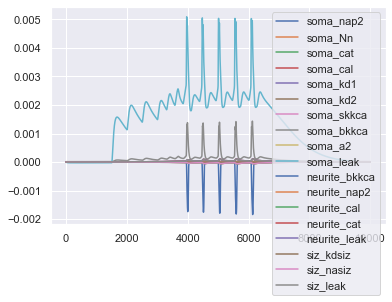

In [552]:
LC2currents = []
cellNo = 1
for i in range(len(Is)):
    if 'LCs['+str(cellNo)+']' in cList[i]:
        LC2currents.append(np.array(Is[i]).reshape(-1,1))
LC2currents = np.concatenate(LC2currents,axis=1)
recVars[0][4] = 'kd1'
for i in range(len(secName)):
    for j in range(len(recVars[i])):
        labelname = secName[i]+'_'+recVars[i][j]
        plt.plot(LC2currents[:,i+j],label = labelname)
        np.savetxt(labelname+'.txt',LC2currents[:,i+j])
plt.legend()
plt.savefig('LC2currents.png')


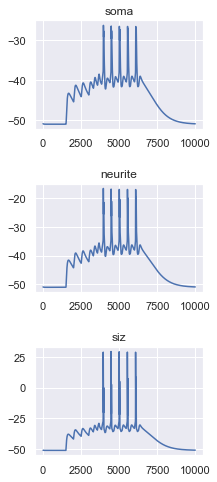

In [551]:
LC2Voltages = []
cellNo = 1
for i in range(len(Vs)):
    if 'LCs['+str(cellNo)+']' in vList[i]:
        LC2Voltages.append(np.array(Vs[i]).reshape(-1,1))
LC2Voltages = np.concatenate(LC2Voltages,axis=1)
fig,axes = plt.subplots(3,figsize=(3,8))
for i in range(LC2Voltages.shape[1]):
    axes[i].plot(LC2Voltages[:,i])
    axes[i].set_title(secName[i])
    plt.subplots_adjust(hspace=0.5)
    np.savetxt(secName[i]+'_voltage.txt',LC2Voltages[:,i])

plt.savefig('LC2sectionvoltages.png')

In [503]:
def plotNet(V):
    
    fig, axs = plt.subplots(5,figsize=(3,10))
    time = np.arange(0,simTime+dt,dt)
    [axs[i].plot(time,V[:,i]) for i in range(5)]
    [axs[i].set_xlabel('ms') for i in range(5)]
    plt.suptitle('network {0}, SC freq {1}'.format(int(netID), int(SCfreq)))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=0.95, wspace=None, hspace=0.5)
    
    plt.savefig("soma voltages.png")
    plt.show()
    

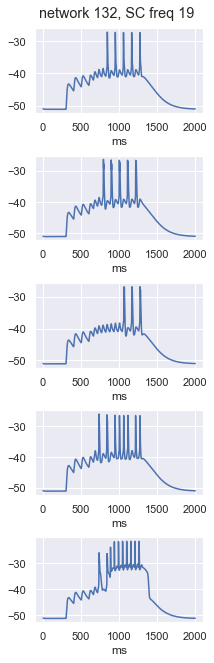

In [550]:
vSomas = []
for i in range(0,len(Vs),3):
    vSomas.append(np.array(Vs[i]).reshape(-1,1))
vSomas = np.concatenate(vSomas,axis=1)  

simTime = 2000
dt = 0.2

plotNet(vSomas)
np.savetxt('voltages.txt',vSomas)

In [326]:

net,Nets,roots = [],[],[]
for idx in sumStatsIDXSDF["maxIDXs"]:
    rootIdx = passidxs[idx]
    roots.append(rootIdx)
    netStart = rootIdx - (rootIdx % 5)
    net.append(LV3Params[:,netStart:netStart+5])
    Nets.append(np.array(net))
    
Nets = np.array(Nets,dtype=object)

In [164]:
Net1 = np.concatenate(Nets[0].T,axis=1)

In [89]:
for i in range(LV3Params.shape[1]):
    if np.all(LV3Params[:,i] == LV3Params[:,passIdxs[594]]) == True:
        NetIDX = i
        break
        

In [239]:
NetNo = (NetIDX - NetIDX%5)/80+3
freq = NetIDX - (int(NetIDX/80)*80) + 16
print(NetNo)
print(freq)

10.0
16


In [50]:
def runNet(seed,netID,SCfreq):
    netIDX = int(getNetIDX(netID,SCfreq))
    netParams = LV3Params[:,netIDX:netIDX + 5]
    passingParamsRepeated = repeatSubarray(netParams, 5,16)
    eventTimes, SCfreqs = makeEventTimes(passingParamsRepeated.shape[1],seed,'LV3')
    params, LCs = makeCellsLV3(netParams,'Control')
    Trials = netParams.shape[1]
    vsAll = [h.VecStim() for i in range(0,Trials)]
    ETs = [h.Vector(eventTimes[int((SCfreq - 16)*5),eventTimes[int((SCfreq - 16)*5),:]!=0]) for i in range(0,Trials)]
    syns = [h.Exp2Syn(LCs[i].siz(1)) for i in range(0,Trials)]
    for i in range(0,Trials):
        vsAll[i].play(ETs[i])
        syns[i].tau1,syns[i].tau2,syns[i].e   = 10,120,-15
    synGains = np.ones(Trials)*0.09
    NetCons = [h.NetCon(vsAll[i],syns[i],-10,0,synGains[i]) for i in range(0,Trials)] 
    RSOMA=2000000#1.54
    RSIZ= 2000000
    g,gSIZ = [],[]
    setGapSoma(0,1,g,LCs,RSOMA)
    setGapSoma(1,0,g,LCs,RSOMA)
    setGapSoma(3,4,g,LCs,RSOMA)
    setGapSoma(4,3,g,LCs,RSOMA)
    perm = permutations(np.arange(0,5),2)
    sizCombos = [i for i in perm]
    [setGapSIZ(sizCombos[i][0],sizCombos[i][1],gSIZ,LCs,RSIZ) for i in range(len(sizCombos))]
    #v = [h.Vector().record(LCs[i].soma(0.5)._ref_v) for i in range(0,Trials)]
    #iSyn = [h.Vector().record(syns[j]._ref_i) for j in range(0,Trials)]
    secName = ["soma","neurite","siz"]
    recVars = [["nap2","Nn","cat","cal","kd2","kd2","skkca","bkkca","a2","leak"],["bkkca","nap2","cal","cat","leak"],["kdsiz","nasiz","leak"]]

    cell = LCs[0]
    voltages,currents = getRec(cell)
    """
    allVvecs = []
    allRefNames = []
    allIvecs = []
    for m in range(len(secName)):
        refVars = []

        for var in recVars[m]:
            res = eval("cell."+secName[m]+"(0.5)."+var+".__dict__")
            for key in list(res.keys()):

                if key[0] == 'i':
                    refVars.append(key)


        refNames = [secName[m]+" "+recVars[m][j]+" "+refVars[j] for j in range(len(recVars[m]))]
        allRefNames.append(refNames)

        recIvecs = ["h.Vector().record(cell."+secName[m]+"(0.5)."+recVars[m][j]+"._ref_"+refVars[j]+")" for j in range(len(recVars[m]))]
        allVvecs.append("h.Vector().record(cell."+secName[m]+"(0.5)._ref_v)")
        allIvecs.append(recIvecs)
        

    currents = [item for sublist in allIvecs for item in sublist]#flatten the list
    voltages = allVvecs
    """
    # does not work w/ list comp for some reason
    currentList = []
    for item in currents:
        currentList.append(eval(item))
    voltageList = []
    for item in voltages:
        voltageList.append(eval(item))
    
    h.dt=dt
    h.finitialize(-51)
    h.continuerun(simTime)
    return voltages,currents,voltageList,currentList



1994

# get a test cell

In [12]:
# according to the pdf cell 17 looks good

In [2]:
h.nrn_load_dll(os.path.join("modFiles","nrnmech.dll"))
h.load_file('stdrun.hoc') #so you can use run command

1.0

In [5]:

archivedPath = os.path.join("..","CGResults","fixed_gSyn")
file = "MedwithLV2"

LV2Params = np.array(pd.read_pickle(os.path.join(archivedPath,file,"output","LV2","passParamsRepeatControl.pkl")))
coded = np.loadtxt(os.path.join(archivedPath,file,"output","LV2","LV2RejectionResults.txt"))
passIdxs,failIdxs,allIdxs = getPassIdxs(coded,"LV2")
passParams = LV2Params[:,passIdxs]


eventTimes = np.array(pd.read_pickle(os.path.join(archivedPath,file,"input","LV2", "EventTimes.pkl"))).T
passingEventTimes = eventTimes[:,passIdxs]

using LV2


In [13]:
TEA = True


cellID =getLV2CellIDX(8,24)
print(cellID)

params = LV2Params[:,cellID]
teaParamsList = [1,2,4,5,14]
if TEA == True:
    for parameter in teaParamsList:
        params[parameter] *= 0.03


ETs = eventTimes[:,cellID]

cell = LargeCellLV2(0)

varNames = list(rangeVarNames().keys())[:len(params)]

#assign the param(:,i) to LC2(i)
for j in range(len(varNames)):
    exec("%s = %f" %("cell."+varNames[j],params[j]))

dt = 0.2
tstop = 2550#ms
maxstep = 10
vinit = -51#mV
Trials = 1
seed  = 32165156


synGain = 0.09

vsAll = h.VecStim()
ETs = h.Vector(ETs[ETs !=0])

syns = h.Exp2Syn(cell.siz(1))

vsAll.play(ETs)
syns.tau1,syns.tau2,syns.e   = 10,120,-15

NetCons = [h.NetCon(vsAll,syns,-10,0,synGain)]

v = h.Vector().record(cell.soma(0.5)._ref_v)
vNeurite = h.Vector().record(cell.neurite(0.5)._ref_v)
vSIZ = h.Vector().record(cell.siz(0.5)._ref_v)

cell.siz.g_leak = 0.001
cell.siz.g_nasiz =  0.300 #
cell.siz.g_kdsiz =  0.074 # 


secName = ["soma","neurite","siz"]
recVars = [["nap2","Nn","cat","cal","kd2","kd2","skkca","bkkca","a2","leak"],["bkkca","nap2","cal","cat","leak"],["kdsiz","nasiz","leak"]]


allVs = []
allRefNames = []
allRecVects = []
for m in range(len(secName)):
    refVars = []
    
    for var in recVars[m]:
        print(secName[m])
        res = eval("cell."+secName[m]+"(0.5)."+var+".__dict__")
        print(res)
        for key in list(res.keys()):
            
            if key[0] == 'i':
                refVars.append(key)
                

    refNames = [secName[m]+" "+recVars[m][j]+" "+refVars[j] for j in range(len(recVars[m]))]
    allRefNames.append(refNames)
    
    recVects = [eval("h.Vector().record(cell."+secName[m]+"(0.5)."+recVars[m][j]+"._ref_"+refVars[j]+")") for j in range(len(recVars[m]))]
    allVs.append(eval("h.Vector().record(cell."+secName[m]+"(0.5)._ref_v)"))
    allRecVects.append(recVects)

synrec = h.Vector().record(syns._ref_i)

h.dt=0.2
h.finitialize(-51)
h.continuerun(2550)

136
soma
{'g': None, 'i': None, 'G': None, 'm': None, 'h': None}
soma
{'gbar': None, 'inn': None, 'w': None}
soma
{'g': None, 'i': None, 'G': None, 'm': None, 'h': None}
soma
{'g': None, 'i': None, 'G': None, 'm': None, 'h': None}
soma
{'g1': None, 'g2': None, 'i': None, 'm1': None, 'h1': None, 'm2': None}
soma
{'g1': None, 'g2': None, 'i': None, 'm1': None, 'h1': None, 'm2': None}
soma
{'gbar': None, 'ik': None, 'w': None}
soma
{'g': None, 'i': None, 'G': None, 'a': None, 'b': None}
soma
{'g': None, 'G': None, 'i': None, 'm': None, 'h': None}
soma
{'g': None, 'e': None, 'il': None}
neurite
{'g': None, 'i': None, 'G': None, 'a': None, 'b': None}
neurite
{'g': None, 'i': None, 'G': None, 'm': None, 'h': None}
neurite
{'g': None, 'i': None, 'G': None, 'm': None, 'h': None}
neurite
{'g': None, 'i': None, 'G': None, 'm': None, 'h': None}
neurite
{'g': None, 'e': None, 'il': None}
siz
{'g': None, 'G': None, 'minf': None, 'taum': None, 'i': None, 'm': None}
siz
{'g': None, 'G': None, 'minf':

0.0

In [15]:
allRefNames[0][4] = 'soma kd1 i'

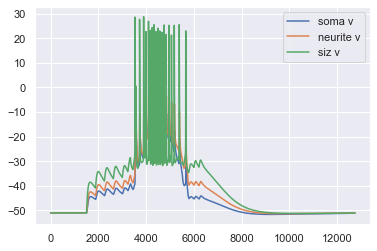

In [16]:
for i in range(len(secName)):
    dat = np.array(allVs[i])
    datName = secName[i]+" v"
    np.savetxt(datName+"Control.txt",dat)
    plt.plot(dat,label=datName)
    plt.legend()
    

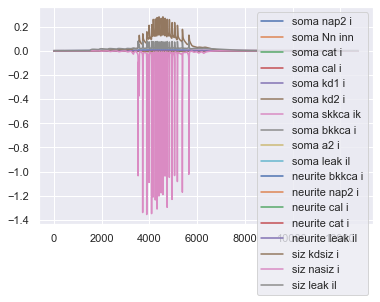

In [18]:

for i in range(len(allRefNames)):
    for j in range(len(allRefNames[i])):
        dat = np.array(allRecVects[i][j])
        np.savetxt(allRefNames[i][j]+"TEA.txt",dat)
        
        plt.plot(dat,label =allRefNames[i][j] )
        plt.legend()

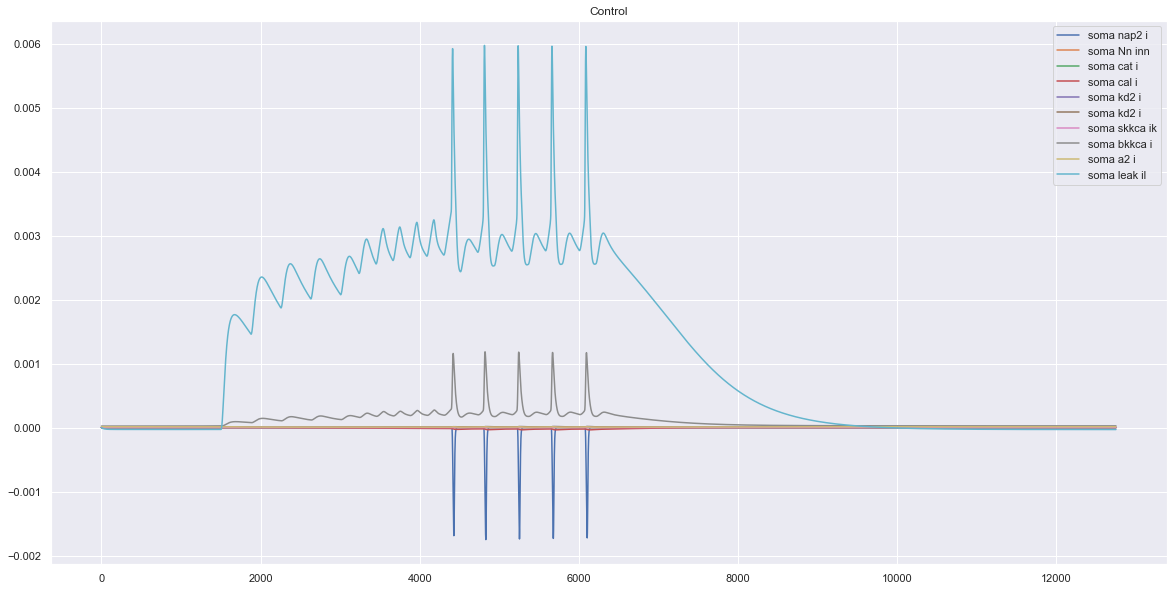

In [9]:
plt.figure(figsize=(20,10))
for i in range(len(allRecVects[0])):
    dat = np.array(allRecVects[0][i])
    plt.plot(dat,label = allRefNames[0][i])
plt.title('Control')
plt.savefig('SomaControlCurrents.png',dpi=200)
plt.legend()

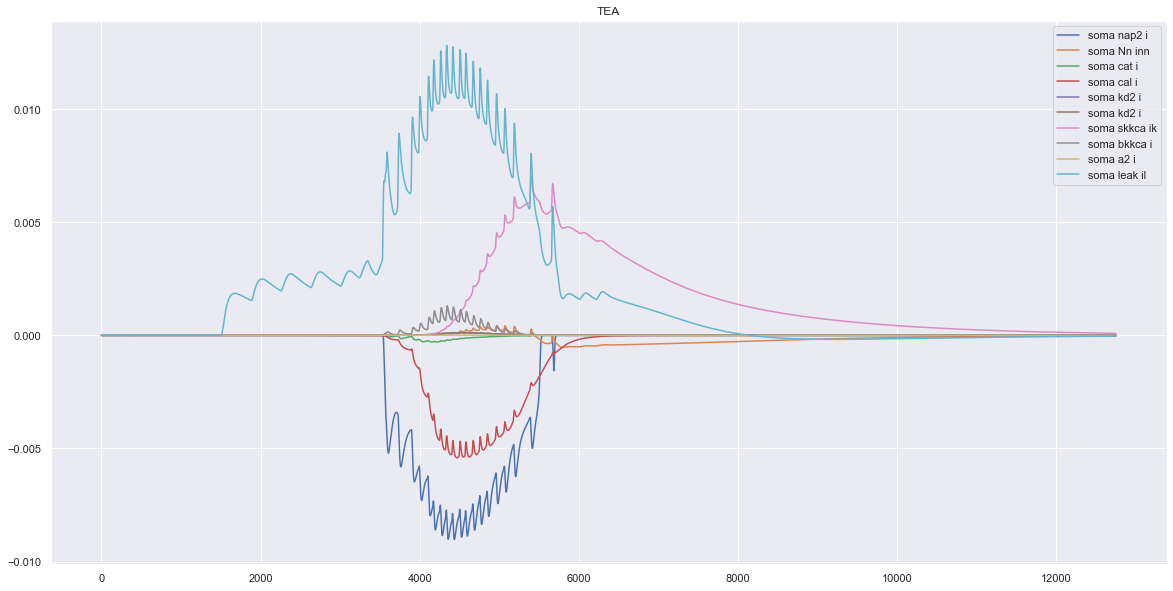

In [26]:
plt.figure(figsize=(20,10))
for i in range(len(allRecVects[0])):
    dat = np.array(allRecVects[0][i])
    plt.plot(dat,label = allRefNames[0][i])
plt.title('TEA')
plt.legend()

# check the saved files


In [24]:
path = r'C:\Users\ddopp\source\repos\CGresults\files_figures\fig 2 data\TEA\voltages'
filenames = os.listdir(path)
filenames

['neurite v.txt', 'siz v.txt', 'soma v.txt']

Text(0.5, 1.0, 'TEA')

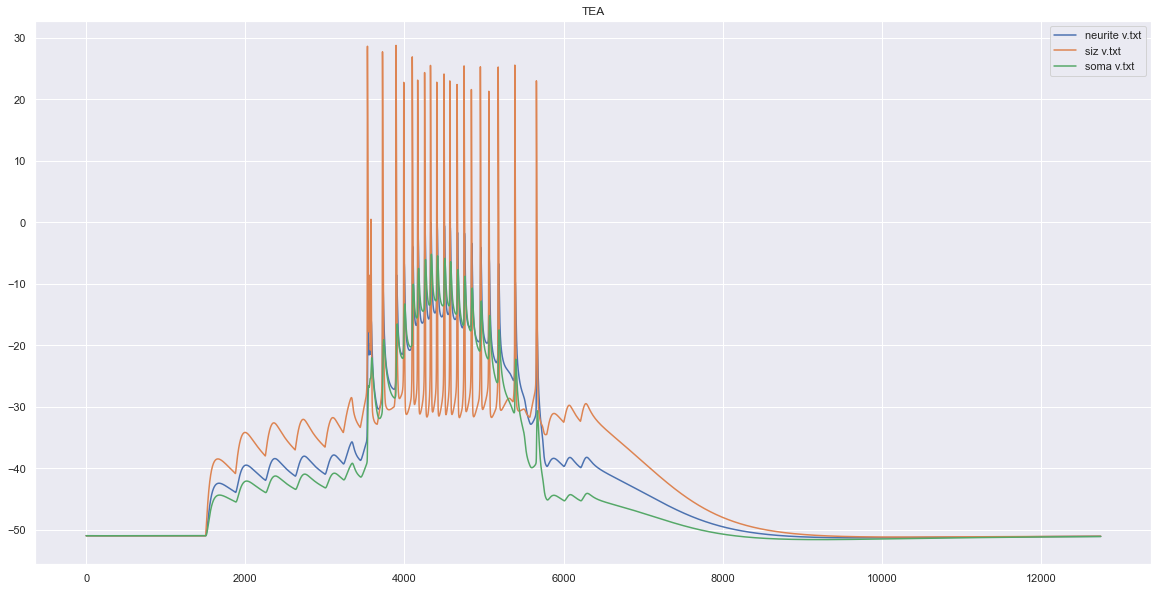

In [25]:
plt.figure(figsize=(20,10))
for i in range(len(filenames)):
    if 'txt' in filenames[i]:
        dat = np.loadtxt(os.path.join(path,filenames[i]))
        plt.plot(dat,label = filenames[i])
plt.legend()
plt.savefig('VoltagesTEA.png')
plt.title('TEA')

In [ ]:
data = np.loadtxt(

# check how many cells passed each stage

In [3]:
archivedPath = os.path.join("..","CGResults","fixed_gSyn")

In [8]:
file = "High115"
LV3out = np.array(pd.read_pickle(os.path.join(archivedPath,file,"output","LV3","passParamsRepeat.pkl")))
coded = np.loadtxt(os.path.join(archivedPath,file,"output","LV3","LV3RejectionResults.txt"))
codedRaw = np.loadtxt(os.path.join(archivedPath,file,"output","LV3","RejectionResultsRaw.txt"))
gSynVal = 0.115

using LV3


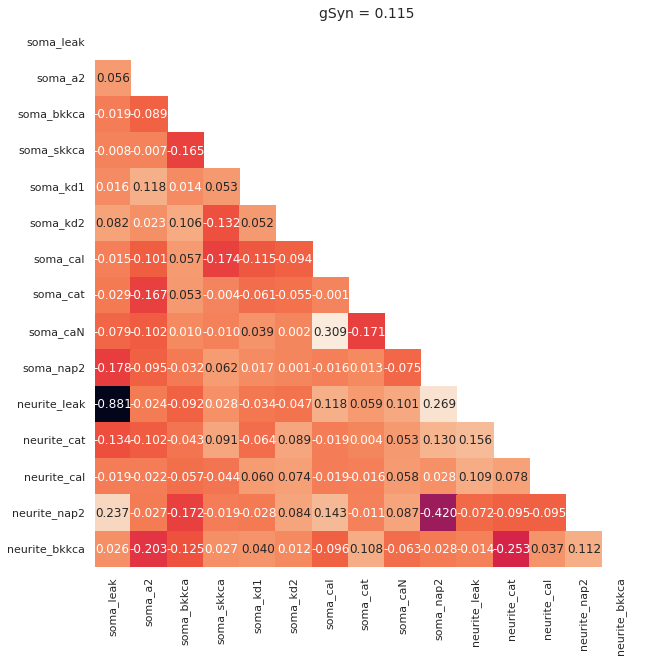

In [70]:
plotPartial(LV3out,coded,Raw,gSynVal)

In [18]:
def plotPartial(array,coded,gVal):
    passIdxs,failIdxs,allIdxs = getPassIdxs(coded,"LVL3")
    passParams = array[:,passIdxs]
    print(passParams.shape)
    print(np.unique(passParams,axis=1).shape)
    params = passParams
    corr = np.corrcoef(params)
    mask = np.zeros((corr.shape[0],corr.shape[1]))
    mask[np.triu_indices_from(mask)] = True
    myList = fullParamsList()
    sns.set(style="white")
    plt.figure(figsize=(15,10))
    ax = sns.heatmap(corr,xticklabels=myList,mask=mask,yticklabels=myList, vmax=.3, fmt="0.3f",square=True,annot=True,cbar=False)
    plt.title('gSyn = {}'.format(gVal),fontsize=14)
    plt.savefig('gSyn{}AVG.png'.format(gVal),dpi=300,bbox_inches='tight')
    plt.show()
    

In [12]:
def getPartials(array,coded):
    passIdxs,failIdxs,allIdxs = getPassIdxs(coded,"LVL3")
    passParams = array[:,passIdxs]
    params = passParams
    corr = np.corrcoef(params)
    return corr
    

In [6]:


LV3 = np.array(pd.read_pickle(os.path.join(archivedPath,"Low075","output","LV3","passParamsRepeat.pkl")))
coded = np.loadtxt(os.path.join(archivedPath,"Low075","output","LV3","LV3RejectionResults.txt"))
Low075 = getPartials(LV3,coded)

LV3 = np.array(pd.read_pickle(os.path.join(archivedPath,"Low08","output","LV3","passParamsRepeat.pkl")))
coded = np.loadtxt(os.path.join(archivedPath,"Low08","output","LV3","LV3RejectionResults.txt"))
Low08 = getPartials(LV3,coded)

LV3 = np.array(pd.read_pickle(os.path.join(archivedPath,"MedwithLV2","output","LV3","passParamsRepeat.pkl")))
coded = np.loadtxt(os.path.join(archivedPath,"MedwithLV2","output","LV3","LV3RejectionResults.txt"))
Low09 = getPartials(LV3,coded)

LV3 = np.array(pd.read_pickle(os.path.join(archivedPath,"High11","output","LV3","passParamsRepeat.pkl")))
coded = np.loadtxt(os.path.join(archivedPath,"High11","output","LV3","LV3RejectionResults.txt"))
High11 = getPartials(LV3,coded)

LV3 = np.array(pd.read_pickle(os.path.join(archivedPath,"High115","output","LV3","passParamsRepeat.pkl")))
coded = np.loadtxt(os.path.join(archivedPath,"High115","output","LV3","LV3RejectionResults.txt"))
High115 = getPartials(LV3,coded)



using LV3
using LV3
using LV3
using LV3
using LV3


In [37]:
allRes = [getPartials(L075Avg,L075Avgcoded),getPartials(L08Avg,L08Avgcoded),getPartials(L09Avg,L09Avgcoded),getPartials(H11Avg,H11Avgcoded),getPartials(H115Avg,H115Avgcoded)]

using LV3
using LV3
using LV3
using LV3
using LV3


In [64]:
greatersR,greatersC,lessersR,lessersC = [],[],[],[]
endVal = len(allRes) - 3
alltestVals = []
for i in range(len(allRes[0])):
    
    for j in range(len(allRes[0])):
        if j>=i:
            continue
        check = []
        testVals = []
        for k in range(0,endVal):
            if abs(allRes[k][i][j]) <= abs(allRes[k+1][i][j]):
                check.append(1)
                testVals.append(allRes[k][i][j])
            else:
                check.append(0)

        if check.count(1) == endVal:
            if np.any(np.abs(testVals ) > 0.2):
                greatersR.append(i)
                greatersC.append(j)
                alltestVals.append(testVals)


               


In [65]:
greatersR

[13]

In [66]:
greatersC

[0]

In [46]:
myList = fullParamsList()

In [67]:
for i in range(len(greatersR)):
    if myList[greatersR[i]] != myList[greatersC[i]]:
        print('{0},{1}'.format(myList[greatersR[i]],myList[greatersC[i]]))

neurite_nap2,soma_leak


In [91]:
archivedPath = os.path.join("..","CGResults","fixed_gSyn")
LV2 = np.array(pd.read_pickle(os.path.join(archivedPath,"MedwithLV2","output","LV2","passParamsRepeatControl.pkl")))
LV2coded = np.loadtxt(os.path.join(archivedPath,"MedwithLV2","output","LV2","LV2RejectionResults.txt"))

In [ ]:
passIdxs,failIdxs,allIdxs = getPassIdxs(L09Avgcoded,"LVL3")
passParams = array[:,passIdxs]
failParams = array[:,failIdxs]

In [21]:
archivedPath = os.path.join("..","CGResults","fixed_gSyn")
L075Avg = np.array(pd.read_pickle(os.path.join(archivedPath,"Low075","output","LV3","Avg","passParamsRepeat.pkl")))
L08Avg  = np.array(pd.read_pickle(os.path.join(archivedPath,"Low08","output","LV3","Avg","passParamsRepeat.pkl")))
L09Avg = np.array(pd.read_pickle(os.path.join(archivedPath,"MedwithLV2","output","LV3","Avg","passParamsRepeat.pkl")))
H11Avg  = np.array(pd.read_pickle(os.path.join(archivedPath,"High11","output","LV3","Avg", "passParamsRepeat.pkl")))
H115Avg = np.array(pd.read_pickle(os.path.join(archivedPath,"High115","output","LV3", "Avg","passParamsRepeat.pkl")))


L075Avgcoded = np.loadtxt(os.path.join(archivedPath,"Low075","output","LV3","Avg","LV3RejectionResults.txt"))
L08Avgcoded  = np.loadtxt(os.path.join(archivedPath,"Low08","output","LV3","Avg","LV3RejectionResults.txt"))
L09Avgcoded = np.loadtxt(os.path.join(archivedPath,"MedwithLV2","output","LV3","Avg","LV3RejectionResults.txt"))
H11Avgcoded  = np.loadtxt(os.path.join(archivedPath,"High11","output","LV3","Avg", "LV3RejectionResults.txt"))
H115Avgcoded = np.loadtxt(os.path.join(archivedPath,"High115","output","LV3", "Avg","LV3RejectionResults.txt"))

using LV3
(15, 1440)
(15, 18)


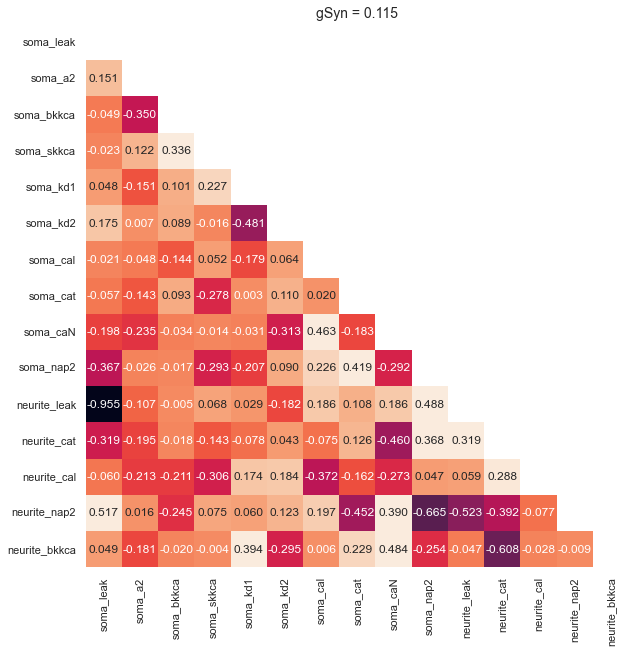

In [24]:
file = "H11Avg"
LV3out = H115Avg
coded = H115Avgcoded
gSynVal = 0.115
plotPartial(LV3out,coded,gSynVal)

using LV3


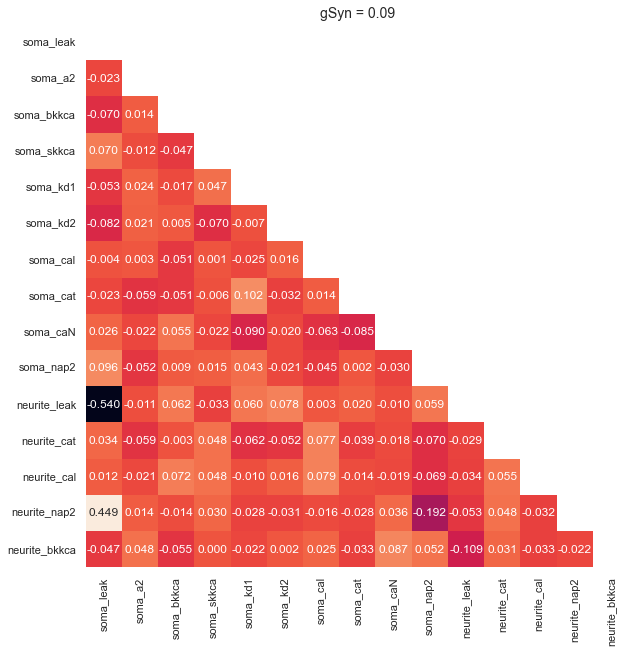

In [73]:
L09Avg = np.array(pd.read_pickle(os.path.join(archivedPath,"MedwithLV2","output","LV3","passParamsRepeat.pkl")))
L09Avgcoded = np.loadtxt(os.path.join(archivedPath,"MedwithLV2","output","LV3","LV3RejectionResults.txt"))
gVal = 0.09
array = L09Avg
passIdxs,failIdxs,allIdxs = getPassIdxs(L09Avgcoded,"LVL3")
passParams = array[:,passIdxs]
failParams = array[:,failIdxs]

params = passParams
corr = np.corrcoef(params)
mask = np.zeros((corr.shape[0],corr.shape[1]))
mask[np.triu_indices_from(mask)] = True
myList = fullParamsList()
sns.set(style="white")
plt.figure(figsize=(15,10))
ax = sns.heatmap(corr,xticklabels=myList,mask=mask,yticklabels=myList, vmax=.3, fmt="0.3f",square=True,annot=True,cbar=False)
plt.title('gSyn = {}'.format(gVal),fontsize=14)
#plt.savefig('gSyn{}AVG.png'.format(gVal),dpi=300,bbox_inches='tight')
plt.show()

using LV3


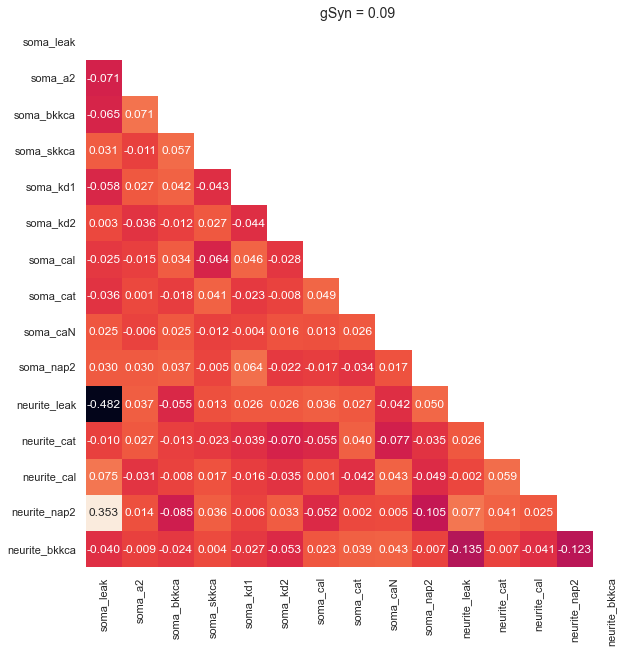

In [81]:
L09Avg = np.array(pd.read_pickle(os.path.join(archivedPath,"MedwithLV2","output","LV3","passParamsRepeat.pkl")))
L09Avgcoded = np.loadtxt(os.path.join(archivedPath,"MedwithLV2","output","LV3","LV3RejectionResults.txt"))
gVal = 0.09
array = L09Avg
passIdxs,failIdxs,allIdxs = getPassIdxs(L09Avgcoded,"LVL3")
passParams = array[:,passIdxs]
failParams = array[:,failIdxs]

params = failParams
corr = np.corrcoef(params)
mask = np.zeros((corr.shape[0],corr.shape[1]))
mask[np.triu_indices_from(mask)] = True
myList = fullParamsList()
sns.set(style="white")
plt.figure(figsize=(15,10))
ax = sns.heatmap(corr,xticklabels=myList,mask=mask,yticklabels=myList, vmax=.3, fmt="0.3f",square=True,annot=True,cbar=False)
plt.title('gSyn = {}'.format(gVal),fontsize=14)
#plt.savefig('gSyn{}AVG.png'.format(gVal),dpi=300,bbox_inches='tight')
plt.show()

In [89]:
for i in range(len(corr)):
    for j in range(len(corr)):
        if j>=i:
            break
        if(np.abs(corr[i,j]) >= 0.1):
            print('{0} and {1}  = {2:.2f}'.format(myList[i],myList[j],corr[i,j]))

neurite_leak and soma_leak  = -0.48
neurite_nap2 and soma_leak  = 0.35
neurite_nap2 and soma_nap2  = -0.10
neurite_bkkca and neurite_leak  = -0.13
neurite_bkkca and neurite_nap2  = -0.12


In [131]:
#check the number tested according to voltage traces and parameter shapes:


LV1in = np.array(pd.read_pickle(os.path.join("output","LV1","Vsoma.pkl")))
LV3in = np.array(pd.read_pickle(os.path.join("output","LV3","passParamsRepeat.pkl")))
LV2in = np.array(pd.read_pickle(os.path.join("input","LV2", "passParams.pkl")))
LV2out = np.array(pd.read_pickle(os.path.join("output","LV2","passParams.pkl")))
LV3 = np.array(pd.read_pickle(os.path.join("output","LV3","VsomaControl.pkl")))


In [24]:

LV3passParamsAVG = np.array(pd.read_pickle(os.path.join("output","LV3","Avg","passParamsRepeat.pkl")))
codedAVG = np.loadtxt(os.path.join("output","LV3","AVG","LV3RejectionResults.txt"))
passIdxsAVG,failIdxsAVG,allIdxsAVG = getPassIdxs(codedAVG)
allAVGnetspassIdxs = getEveryFirstNet(allIdxsAVG)
passParamsAVGIDXs = np.where(allAVGnetspassIdxs==1)[0]


LV3passParams = np.array(pd.read_pickle(os.path.join("output","LV3","passParamsRepeat.pkl")))#the set used to make the average params
coded = np.loadtxt(os.path.join("output","LV3","LV3RejectionResults.txt"))
passIdxs,failIdxs,allIdxs = getPassIdxs(coded)
passParams = getEveryFirstNet(LV3passParams[:,passIdxs])


LV2numTested = (LV2in.shape)[1]/16
LV3AVGdpassed = (LV3passParamsAVG.shape)[1]/5
LV3inputnum = (LV3in.shape)[1]
print('starting with %d cells, %d passed LV1\n%d cells passed LV2 which forms %d networks\nof which %d networks passed  ' %(LV1in.shape[0],LV2in.shape[1],(LV2out.shape)[1],(LV2out.shape)[1]/5,(passParams.shape)[1]/5))
print('from the %d networks, an averaged network was formed for each, of which %d passed' %((passParams.shape)[1]/5,passParamsAVGIDXs.shape[0]/5))

starting with 6000 cells, 4541 passed LV1
1958 cells passed LV2 which forms 391 networks
of which 251 networks passed  
from the 251 networks, an averaged network was formed for each, of which 213 passed


### save unique parameter sets for Rstudio plotting

In [103]:
archivedPath1 = os.path.join("..","CGResults","fixed_gSyn","MedwithLV2")
LV3passParams = np.array(pd.read_pickle(os.path.join(archivedPath1,"output","LV3","passParamsRepeat.pkl")))#the set used to make the average params
coded = np.loadtxt(os.path.join(archivedPath1,"output","LV3","LV3RejectionResults.txt"))
passIdxs,failIdxs,allIdxs = getPassIdxs(coded,"LV3")
passParams = getEveryFirstNet(LV3passParams[:,passIdxs])
with h5py.File('LV3PassParams.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = passParams)
f.close()

using LV3


## check basic stats about the data

In [105]:
archivedPath = os.path.join("output")
archivedPath1 = os.path.join("..","CGResults","fixed_gSyn","MedwithLV2","output")
archivedPath2 =  os.path.join("..","CGResults","fixed_gSyn","MedwithoutLV2")
                            

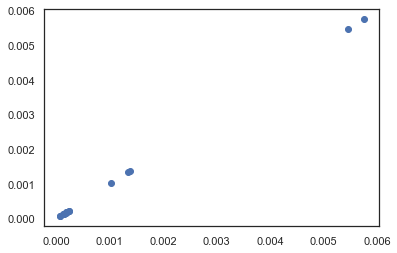

In [107]:
plt.scatter(params[:,9],params[:,14])

In [5]:
archivedPath1 = os.path.join("..","CGResults","fixed_gSyn","MedwithLV2","output","LV3","AVG")
scfreqs = np.loadtxt(os.path.join(archivedPath1,"SCfreqs"))
RejectionResults = np.loadtxt(os.path.join(archivedPath1,"LV3RejectionRaw.txt"))
LV3passParams = np.array(pd.read_pickle(os.path.join(archivedPath1,"passParamsRepeat.pkl")))#the set used to make the average params
coded = np.loadtxt(os.path.join(archivedPath1,"LV3RejectionResults.txt"))
######################################
#choose weighted or un weighted. note that unweighted will not give accurate results for SCfreqs or rejectionresults since it is only grabbing the nets which passed at 16 hz
passIdxs,failIdxs,allIdxs = getPassIdxs(coded,'LV3')
passI = passIdxs#weighted
#passI = getEveryFirstNet(passIdxs).astype(int)#nonweighted
###############################


using LV3


In [8]:
LV3passParams.shape

(15, 10400)

In [9]:
np.savetxt("LV3 pass Idxs AVG.txt",passI)
np.savetxt("LV3ParamsAVG.txt",LV3passParams)


In [10]:
fullParamsList()

['soma_leak',
 'soma_a2',
 'soma_bkkca',
 'soma_skkca',
 'soma_kd1',
 'soma_kd2',
 'soma_cal',
 'soma_cat',
 'soma_caN',
 'soma_nap2',
 'neurite_leak',
 'neurite_cat',
 'neurite_cal',
 'neurite_nap2',
 'neurite_bkkca']

##  plot correlograms

using LV3


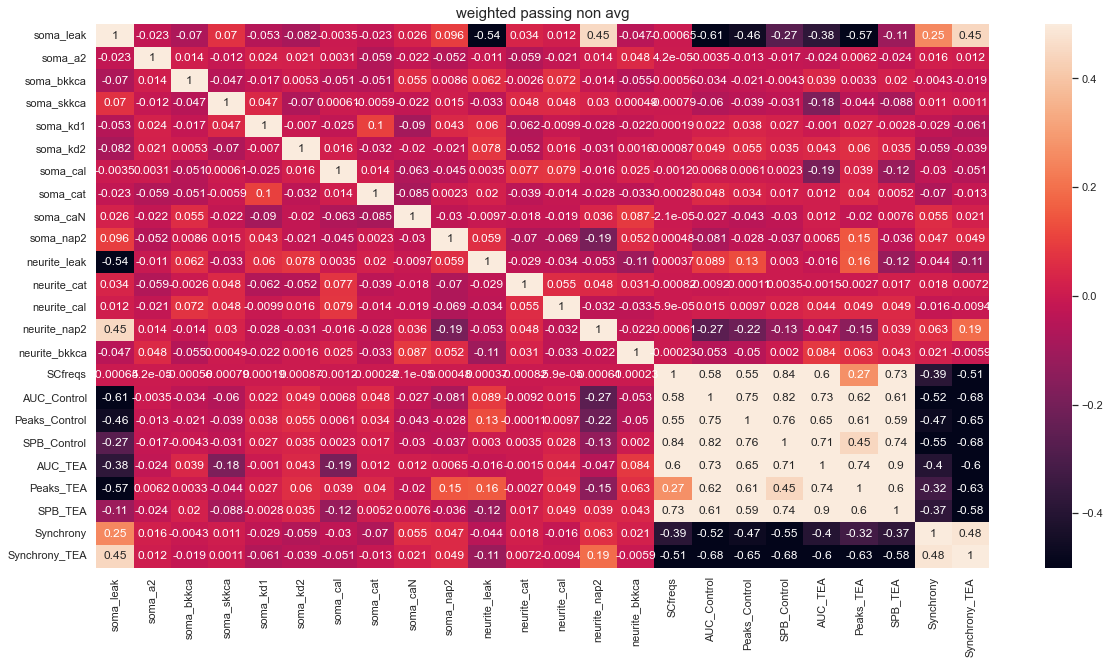

In [106]:
######################################

scfreqs = np.loadtxt(os.path.join(archivedPath1,"LV3","SCfreqs"))
RejectionResults = np.loadtxt(os.path.join(archivedPath1,"LV3","LV3RejectionRaw.txt"))
LV3passParams = np.array(pd.read_pickle(os.path.join(archivedPath1,"LV3","passParamsRepeat.pkl")))#the set used to make the average params
coded = np.loadtxt(os.path.join(archivedPath1,"LV3","LV3RejectionResults.txt"))
######################################
#choose weighted or un weighted. note that unweighted will not give accurate results for SCfreqs or rejectionresults since it is only grabbing the nets which passed at 16 hz
passIdxs,failIdxs,allIdxs = getPassIdxs(coded,'LV3')
passI = passIdxs#weighted
#passI = getEveryFirstNet(passIdxs).astype(int)#nonweighted
###############################
params = LV3passParams[:,passI]
scfreqs = scfreqs[passI]
RejectionResults = RejectionResults[:,passI]

args = [params,scfreqs.reshape(1,-1),RejectionResults]
Params = np.concatenate(args,axis=0)
myList = fullParamsList() + ['SCfreqs'] + LV3CritList()

title = 'weighted passing non avg'
plotCorrelogram(Params,myList,title)
plt.show()

using LV3


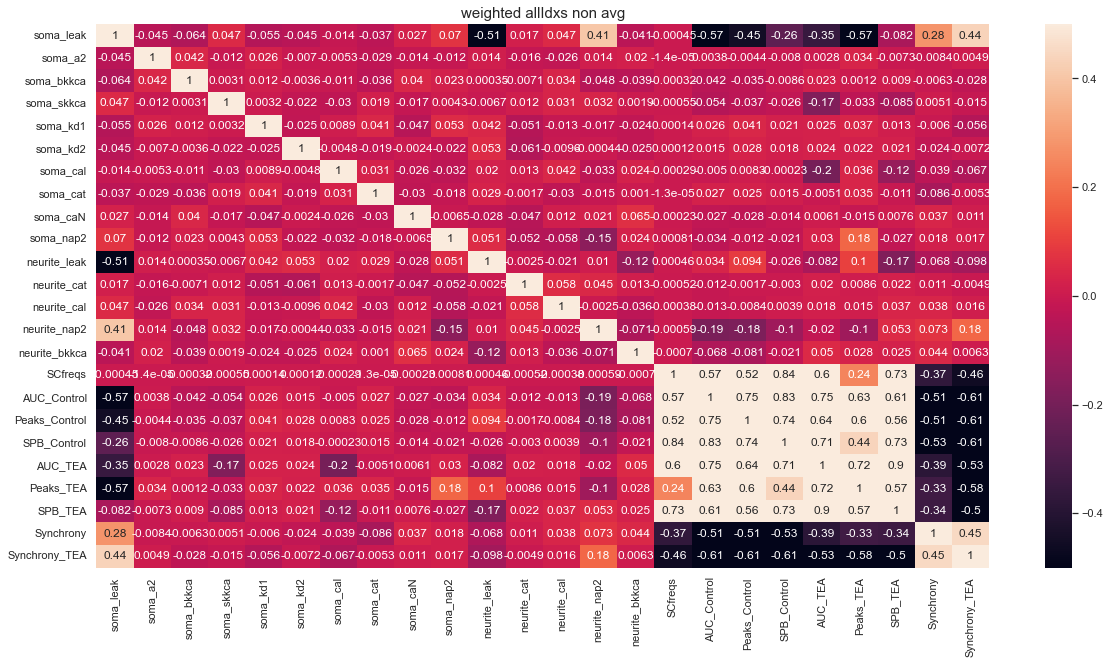

In [88]:

scfreqs = np.loadtxt(os.path.join(archivedPath1,"LV3","SCfreqs"))
RejectionResults = np.loadtxt(os.path.join(archivedPath1,"LV3","LV3RejectionRaw.txt"))
LV3passParams = np.array(pd.read_pickle(os.path.join(archivedPath1,"LV3","passParamsRepeat.pkl")))#the set used to make the average params
coded = np.loadtxt(os.path.join(archivedPath1,"LV3","LV3RejectionResults.txt"))
######################################
#choose weighted or un weighted. note that unweighted will not give accurate results for SCfreqs or rejectionresults since it is only grabbing the nets which passed at 16 hz
passIdxs,failIdxs,allIdxs = getPassIdxs(coded,'LV3')
passI = np.arange(0,len(allIdxs))#failIdxs#weighted
#passI = getEveryFirstNet(passIdxs).astype(int)#nonweighted
###############################
params = LV3passParams[:,passI]
scfreqs = scfreqs[passI]
RejectionResults = RejectionResults[:,passI]

args = [params,scfreqs.reshape(1,-1),RejectionResults]
Params = np.concatenate(args,axis=0)
myList = fullParamsList() + ['SCfreqs'] + LV3CritList()

title = 'weighted allIdxs non avg'
plotCorrelogram(Params,myList,title)
plt.show()

In [102]:

scfreqs = np.loadtxt(os.path.join(archivedPath1,"LV3","SCfreqs"))
RejectionResults = np.loadtxt(os.path.join(archivedPath1,"LV3","LV3RejectionRaw.txt"))
LV3passParams = np.array(pd.read_pickle(os.path.join(archivedPath1,"LV3","passParamsRepeat.pkl")))#the set used to make the average params
coded = np.loadtxt(os.path.join(archivedPath1,"LV3","LV3RejectionResults.txt"))
######################################
#choose weighted or un weighted. note that unweighted will not give accurate results for SCfreqs or rejectionresults since it is only grabbing the nets which passed at 16 hz
passIdxs,failIdxs,allIdxs = getPassIdxs(coded,'LV3')
passI = failIdxs#weighted
#passI = getEveryFirstNet(passIdxs).astype(int)#nonweighted
###############################
params = LV3passParams[:,passI]
scfreqs = scfreqs[passI]
RejectionResults = RejectionResults[:,passI]

args = [params,scfreqs.reshape(1,-1),RejectionResults]
Params = np.concatenate(args,axis=0)
myList = fullParamsList() + ['SCfreqs'] + LV3CritList()

title = 'weighted failIdxs non avg'
plotCorrelogram(Params,myList,title)
plt.show()

NameError: name 'archivedPath1' is not defined

(20160,)


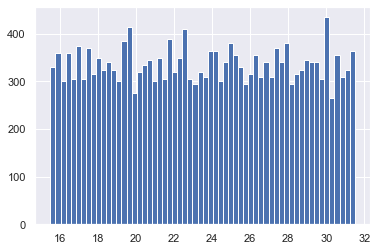

In [52]:
scfreqs = np.loadtxt(os.path.join(archivedPath1,"LV3","SCfreqs"))
plt.hist(scfreqs,bins=60)
print(scfreqs.shape)
plt.show()

using LV3
(10400,)


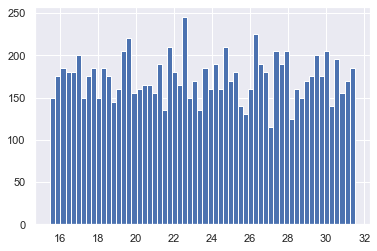

In [82]:
scfreqs = np.loadtxt(os.path.join(archivedPath1,"LV3","SCfreqs"))
coded = np.loadtxt(os.path.join(archivedPath1,"LV3","LV3RejectionResults.txt"))
passIdxs,failIdxs,allIdxs = getPassIdxs(coded,'LV3')
plt.hist(scfreqs[passIdxs],bins=60)
print(scfreqs[passIdxs].shape)
plt.show()

using LV3


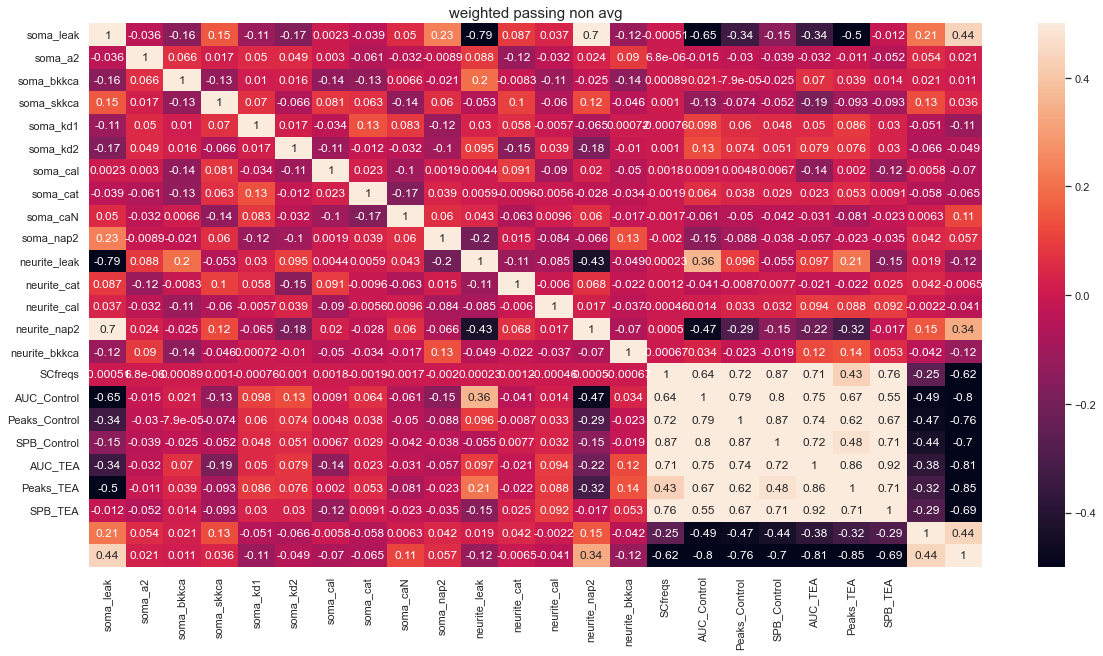

In [100]:
archivedPath = os.path.join("..","CGResults","fixed_Gsyn","MedwithLV2","output","LV3","AVG")
scfreqs = np.loadtxt(os.path.join(archivedPath,"SCfreqs"))
RejectionResults = np.loadtxt(os.path.join(archivedPath,"LV3RejectionRaw.txt"))
LV3passParams = np.array(pd.read_pickle(os.path.join(archivedPath,"passParamsRepeat.pkl")))#the set used to make the average params
coded = np.loadtxt(os.path.join(archivedPath,"LV3RejectionResults.txt"))
######################################
#choose weighted or un weighted. note that unweighted will not give accurate results for SCfreqs or rejectionresults since it is only grabbing the nets which passed at 16 hz
passIdxs,failIdxs,allIdxs = getPassIdxs(coded,'LV3')
passI = passIdxs#weighted
#passI = getEveryFirstNet(passIdxs).astype(int)#nonweighted
###############################
params = LV3passParams[:,passI]
scfreqs = scfreqs[passI]
RejectionResults = RejectionResults[:,passI]

args = [params,scfreqs.reshape(1,-1),RejectionResults]
Params = np.concatenate(args,axis=0)
myList = fullParamsList() + ['SCfreqs'] + LV2CritList()

title = 'weighted passing non avg'
plotCorrelogram(Params,myList,title)
plt.show()

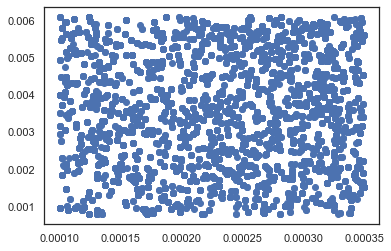

In [113]:
plt.scatter(Params[9,:],Params[14,:])

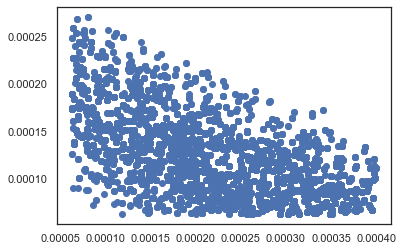

In [114]:
plt.scatter(Params[0,:],Params[10,:])

using LV2


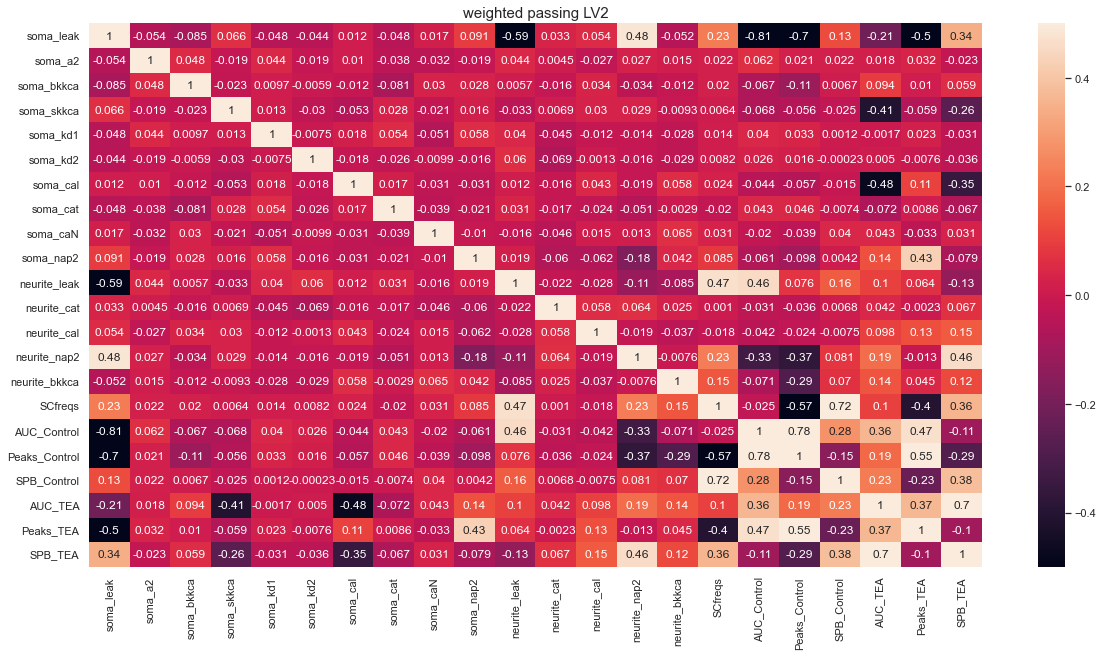

In [108]:
archivedPath = os.path.join("..","CGResults","fixed_gSyn","MedwithLV2","output")
#LV2 = np.array(pd.read_pickle(os.path.join(archivedPath,"MedwithLV2","output","LV2","passParamsRepeatControl.pkl")))
scfreqs = np.loadtxt(os.path.join(archivedPath,"LV2","SCfreqs"))
RejectionResults = np.loadtxt(os.path.join(archivedPath,"LV2","LV2RejectionRaw.txt"))
LV2passParams = np.array(pd.read_pickle(os.path.join(archivedPath,"LV2","passParamsRepeatControl.pkl")))#the set used to make the average params
coded = np.loadtxt(os.path.join(archivedPath,"LV2","LV2RejectionResults.txt"))
######################################
#choose weighted or un weighted. note that unweighted will not give accurate results for SCfreqs or rejectionresults since it is only grabbing the nets which passed at 16 hz
passIdxs,failIdxs,allIdxs = getPassIdxs(coded,'LV2')
passI = passIdxs#weighted
#passI = getEveryFirstNet(passIdxs).astype(int)#nonweighted
###############################
params = LV2passParams[:,passI]
scfreqs = scfreqs[passI]
RejectionResults = RejectionResults[:,passI]

args = [params,scfreqs.reshape(1,-1),RejectionResults]
Params = np.concatenate(args,axis=0)
myList = fullParamsList() + ['SCfreqs'] + LV2CritList()

title = 'weighted passing LV2'
plotCorrelogram(Params,myList,title)
plt.show()

using LV2


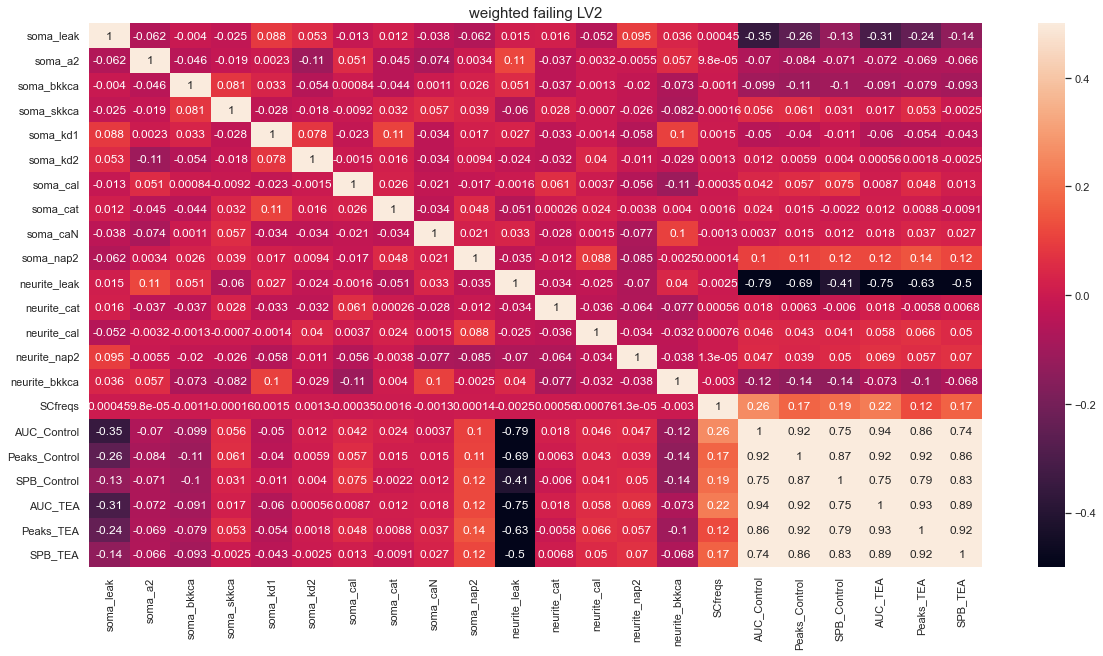

In [93]:
archivedPath = os.path.join("..","CGResults","fixed_gSyn","MedwithLV2","output")
#LV2 = np.array(pd.read_pickle(os.path.join(archivedPath,"MedwithLV2","output","LV2","passParamsRepeatControl.pkl")))
scfreqs = np.loadtxt(os.path.join(archivedPath,"LV2","SCfreqs"))
RejectionResults = np.loadtxt(os.path.join(archivedPath,"LV2","LV2RejectionRaw.txt"))
LV2passParams = np.array(pd.read_pickle(os.path.join(archivedPath,"LV2","passParamsRepeatControl.pkl")))#the set used to make the average params
coded = np.loadtxt(os.path.join(archivedPath,"LV2","LV2RejectionResults.txt"))
######################################
#choose weighted or un weighted. note that unweighted will not give accurate results for SCfreqs or rejectionresults since it is only grabbing the nets which passed at 16 hz
passIdxs,failIdxs,allIdxs = getPassIdxs(coded,'LV2')
passI = failIdxs#weighted
#passI = getEveryFirstNet(passIdxs).astype(int)#nonweighted
###############################
params = LV2passParams[:,passI]
scfreqs = scfreqs[passI]
RejectionResults = RejectionResults[:,passI]

args = [params,scfreqs.reshape(1,-1),RejectionResults]
Params = np.concatenate(args,axis=0)
myList = fullParamsList() + ['SCfreqs'] + LV2CritList()

title = 'weighted failing LV2'
plotCorrelogram(Params,myList,title)
plt.show()

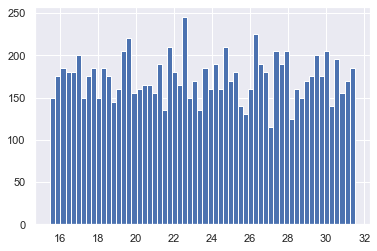

In [18]:
plt.hist(scfreqs,bins=60)
plt.show()

In [1]:
scfreqs = np.loadtxt(os.path.join(archivedPath1,"LV2","SCfreqs"))
RejectionResults = np.loadtxt(os.path.join(archivedPath1,"LV2","LV3RejectionRaw.txt"))
LV3passParams = np.array(pd.read_pickle(os.path.join(archivedPath1,"LV2","passParamsRepeat.pkl")))#the set used to make the average params
coded = np.loadtxt(os.path.join(archivedPath1,"LV2","LV2RejectionResults.txt"))
######################################
#choose weighted or un weighted. note that unweighted will not give accurate results for SCfreqs or rejectionresults since it is only grabbing the nets which passed at 16 hz
passIdxs,failIdxs,allIdxs = getPassIdxs(coded,'LV2')
passI = passIdxs#weighted
#passI = getEveryFirstNet(passIdxs).astype(int)#nonweighted
###############################
params = LV3passParams[:,passI]
scfreqs = scfreqs[passI]
RejectionResults = RejectionResults[:,passI]

args = [params,scfreqs.reshape(1,-1),RejectionResults]
Params = np.concatenate(args,axis=0)
myList = fullParamsList() + ['SCfreqs'] + LV3CritList()

title = 'weighted passing non avg'
plotCorrelogram(Params,myList,title)
plt.show()

NameError: name 'np' is not defined

In [83]:
RejectionResults = np.loadtxt(os.path.join("output","LV3","LV3RejectionRaw.txt"))

In [77]:
######################################
scfreqs = np.loadtxt(os.path.join("output","LV3","Avg","SCfreqs"))
RejectionResults = np.loadtxt(os.path.join("output","LV3","Avg","LV3RejectionRaw.txt"))
LV3passParams = np.array(pd.read_pickle(os.path.join("output","LV3","Avg","passParamsRepeat.pkl")))
coded = np.loadtxt(os.path.join("output","LV3","Avg","LV3RejectionResults.txt"))

######################################
#choose weighted or un weighted. note that unweighted will not give accurate results for SCfreqs or rejectionresults since it is only grabbing the nets which passed at 16 hz
passIdxs,failIdxs,allIdxs = getPassIdxs(coded)
passI = passIdxs#weighted
#passI = getEveryFirstNet(passIdxs).astype(int)#nonweighted
###############################
params = LV3passParams[:,passI]
scfreqs = scfreqs[passI]
RejectionResults = RejectionResults[:,passI]

args = [params,scfreqs.reshape(1,-1),RejectionResults]
ParamsAVG = np.concatenate(args,axis=0)
myList = fullParamsList() + ['SCfreqs'] + LV3CritList()

CorrsDiff = abs(np.corrcoef(ParamsAVG)) - abs(np.corrcoef(Params))#assuming Params is the correlation matrix used to make the non averaged plots

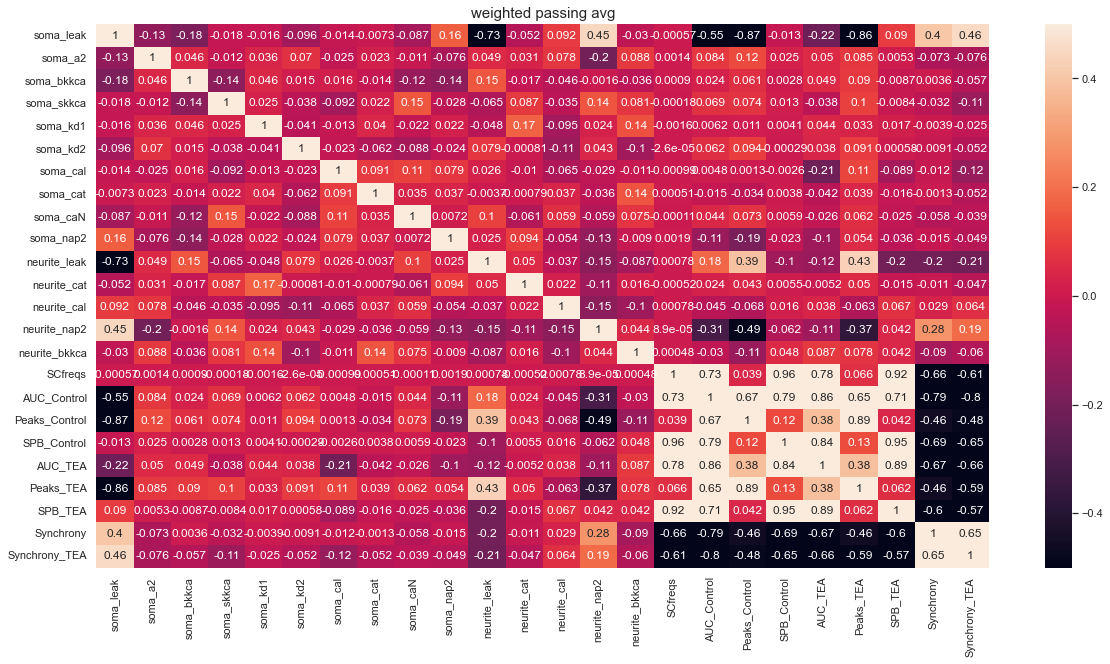

In [72]:
plotCorrelogram(ParamsAVG,myList,'weighted passing avg')
plt.savefig('weighted passing avg.png',dpi=500)
plt.show()

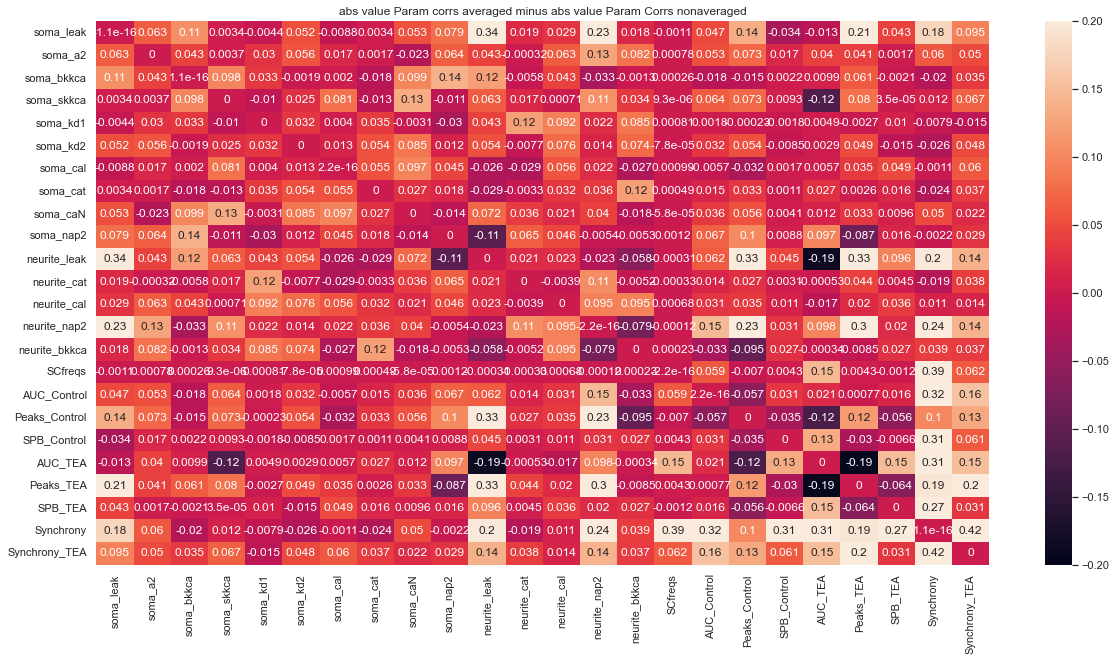

In [78]:
plt.figure(figsize=(20,10))
ax = sns.heatmap(CorrsDiff,xticklabels=myList,yticklabels = myList,vmin=-0.2,vmax=0.2,annot=True)
plt.title('abs value Param corrs averaged minus abs value Param Corrs nonaveraged')
plt.savefig('weighted passing diff.png')
plt.show()

### find the averaged networks and unaverage them

In [46]:
#get the averaged networks which pass
LV3passParamsAVG = np.array(pd.read_pickle(os.path.join("output","LV3","Avg","passParamsRepeat.pkl")))
codedAVG = np.loadtxt(os.path.join("output","LV3","Avg","LV3RejectionResults.txt"))
passIdxsAVG,failIdxsAVG,allIdxsAVG = getPassIdxs(codedAVG)
passParamsAVG = getEveryFirstNet(LV3passParamsAVG[:,passIdxsAVG])


#get the nonaveraged networks which pass
LV3passParams = np.array(pd.read_pickle(os.path.join("output","LV3","passParamsRepeat.pkl")))#the set used to make the average params
coded = np.loadtxt(os.path.join("output","LV3","LV3RejectionResults.txt"))
passIdxs,failIdxs,allIdxs = getPassIdxs(coded)
passParams = getEveryFirstNet(LV3passParams[:,passIdxs])

#get the averaged networks which fail
failParamsAVG = getEveryFirstNet(LV3passParamsAVG[:,failIdxsAVG])
#get the nonaveraged networks which fail
failParams = getEveryFirstNet(LV3passParams[:,failIdxs])
#compare the ranges of the failing networks with the nonfailing networks

allIdxsAVG#this is the 1 or 0 for every network at every frequency, 24160 recordings that form 302 networks, 1 if passed, 0 if failed
allAVGnetspassIdxs = getEveryFirstNet(allIdxsAVG)#1510 forming 302 networks
p = np.where(allAVGnetspassIdxs==1)[0]#1405 forming 281 networks
f =  np.where(allAVGnetspassIdxs!=1)[0]#105 forming 21 networks
t1 = passParams[:,p]# un averaged networks corresponding to the averaged networks that pass
t2 = passParams[:,f] # un averaged networks corresponding to the averaged networks that fail

In [47]:
LV3passParams = np.array(pd.read_pickle(os.path.join("output","LV3","passParamsRepeat.pkl")))#the set used to make the average params
coded = np.loadtxt(os.path.join("output","LV3","LV3RejectionResults.txt"))
passIdxs,failIdxs,allIdxs = getPassIdxs(coded)
passParams = getEveryFirstNet(LV3passParams[:,passIdxs])
passParams.shape

(15, 1255)

## kurtosis

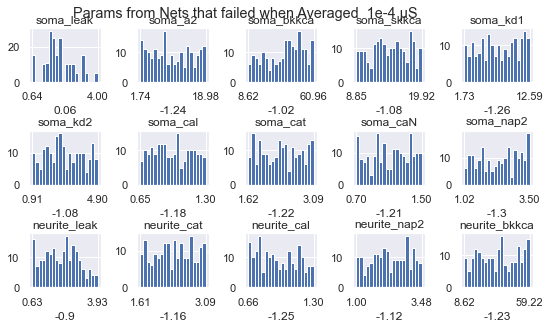

In [73]:
#t1 is the averaged networks that passed, but unaveraged
#t2 is the averaged networks that failed, but unaveraged
from scipy.stats import skew
t1Kurts = [kurtosis(t1[i,:],bias=False) for i in range((t1.shape)[0])]
t1Kurts = np.round(t1Kurts,2)
t1Skews = [skew(t1[i,:]) for i in range((t1.shape)[0])]
t1Skews = np.round(t1Skews,2)

t2Kurts = [kurtosis(t2[i,:],bias=False) for i in range((t2.shape)[0])]
t2Kurts = np.round(t2Kurts,2)
t2Skews = [skew(t2[i,:]) for i in range((t2.shape)[0])]
t2Skews = np.round(t2Skews,2)
plotDistributions(t2,fullParamsList(),20,'Params from Nets that failed when Averaged  ',t2Kurts)
plt.savefig('params from nets that failed when averaged')

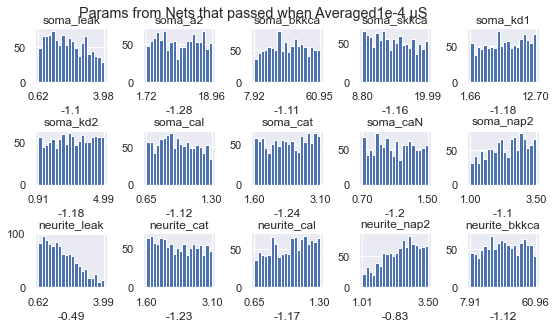

In [74]:
t1Kurts = [kurtosis(t1[i,:],bias=True) for i in range((t1.shape)[0])]
t1Kurts = np.round(t1Kurts,2)
t1Skews = [skew(t1[i,:]) for i in range((t1.shape)[0])]
t1Skews = np.round(t1Skews,2)

plotDistributions(t1,fullParamsList(),20,' Params from Nets that passed when Averaged',t1Kurts)
plt.savefig('params from nets that passed when averaged')

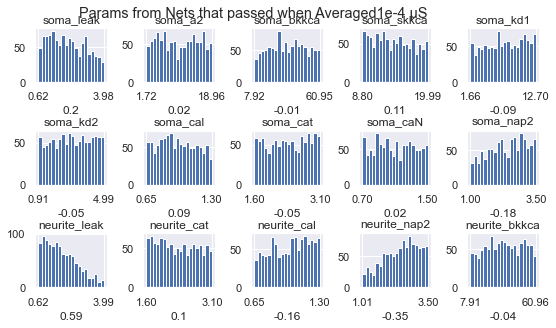

In [50]:
plotDistributions(t1,fullParamsList(),20,' Params from Nets that passed when Averaged',t1Skews)

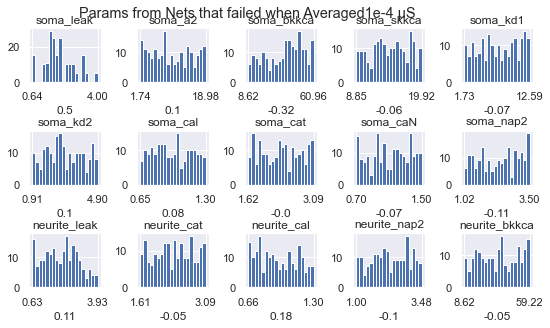

In [75]:
plotDistributions(t2,fullParamsList(),20,' Params from Nets that failed when Averaged',t2Skews)

In [52]:
AvgFailKurt = np.mean(t2Kurts)
AvgPassKurt = np.mean(t1Kurts)
AvgFailSkew = np.mean(t2Skews)
AvgPassSkew = np.mean(t1Skews)
print('Failing:\nAvg Kurt = {0:>15.4}\nAvg Skew = {1:>15.4}\n\nPassing:\nAvg Kurt = {2:>15.4}\nAvg Skew = {3:>17.4}'.format(AvgFailKurt,AvgFailSkew,AvgPassKurt,AvgPassSkew))

Failing:
Avg Kurt =          -1.079
Avg Skew =           0.016

Passing:
Avg Kurt =          -1.101
Avg Skew =           0.01333


In [53]:
DistMetricFail = abs(t2Kurts) + abs(t2Skews)
DistMetricPass = abs(t1Kurts) + abs(t1Skews)

In [62]:
DistMetricFail

array([0.56, 1.34, 1.34, 1.14, 1.33, 1.18, 1.26, 1.22, 1.28, 1.41, 1.01,
       1.21, 1.43, 1.22, 1.28])

In [63]:
print('skew/kurt measurement for failing = %.6f\nskew/kurt measurement for passing = %.6f' %(np.mean(DistMetricFail),np.mean(DistMetricPass)))
stats.ttest_ind(DistMetricFail, DistMetricPass, equal_var=False)

skew/kurt measurement for failing = 1.214000
skew/kurt measurement for passing = 1.238000


Ttest_indResult(statistic=-0.4163469682084544, pvalue=0.6821901545922873)

## euclidean distance between LCs in a network

In [258]:
archivedPath = os.path.join("..","CGResults","fixed_Gsyn","MedwithLV2")
# get a list of LC1-2 avg, LC3, and LC3-4 avg:
LV3passParams = np.array(pd.read_pickle(os.path.join(archivedPath,"LV3","output","passParamsRepeat.pkl")))#the set used to make the average params
coded = np.loadtxt(os.path.join(archivedPath,"LV3","output","LV3RejectionResults.txt"))
passIdxs,failIdxs,allIdxs = getPassIdxs(coded,"LV3")
LV3passParamsUnique = getEveryFirstNet(LV3passParams[:,passIdxs])
LV3passParamsUnique.shape

using LV3


(15, 650)

In [259]:
Dist_12_3,Dist_45_3,Dist_1_2,Dist_4_5 = [],[],[],[]
D13,D23,D43,D53 = [],[],[],[]
for i in range(0,LV3passParamsUnique.shape[1],5):
    #get the cells
    LC1,LC2,LC3,LC4,LC5 = LV3passParamsUnique[:,i+0], LV3passParamsUnique[:,i+1],LV3passParamsUnique[:,i+2],LV3passParamsUnique[:,i+3],LV3passParamsUnique[:,i+4]
    #standardize if desired
    #LC1 = LC1/max(abs(LC1))
    #LC2 = LC2/max(abs(LC2))
    #LC3 = LC3/max(abs(LC3))
    #LC4 = LC4/max(abs(LC4))
    #LC5 = LC5/max(abs(LC5))
    #calc the euclidean distance for this network:
    Dist_1_3 = distance.euclidean(LC1,LC3)
    Dist_2_3 = distance.euclidean(LC2,LC3)
    D13.append(Dist_1_3)
    D23.append(Dist_2_3)
    #Dist_12_3.append((Dist_1_3 + Dist_2_3)/2)
    Dist_12_3.append(distance.euclidean((LC1+LC2)/2,LC3))
    
    Dist_4_3 = distance.euclidean(LC4,LC3)
    Dist_5_3 = distance.euclidean(LC5,LC3)
    D43.append(Dist_4_3)
    D53.append(Dist_5_3)
    #Dist_45_3.append((Dist_4_3 + Dist_5_3)/2)
    Dist_45_3.append(distance.euclidean((LC4+LC5)/2,LC3))
    
    Dist_1_2.append(distance.euclidean(LC1,LC2))
    Dist_4_5.append(distance.euclidean(LC4,LC5))
    

In [260]:
print('Dist_12_3 = {0:>10.6f}\nDist_45_3 = {1:>10.6f}\nDist_1_2 = {2:>11.6f}\nDist_4_5 = {3:>11.6f}'.format(np.mean(Dist_12_3),np.mean(Dist_45_3),np.mean(Dist_1_2),np.mean(Dist_4_5)))
print('\n\n')
print('Dist_1_3 = {0:>11.6f}\nDist_2_3 = {1:>11.6f}\nDist_4_3 = {2:>11.6f}\nDist_5_3 = {3:>11.6f}\nDist_1_2 = {4:>11.6f}\nDist_4_5 = {5:>11.6f}'.format(np.mean(D13),np.mean(D23),np.mean(D43),np.mean(D53),np.mean(Dist_1_2),np.mean(Dist_4_5)))

Dist_12_3 =   0.002445
Dist_45_3 =   0.002392
Dist_1_2 =    0.002998
Dist_4_5 =    0.003106



Dist_1_3 =    0.002953
Dist_2_3 =    0.002770
Dist_4_3 =    0.002827
Dist_5_3 =    0.002870
Dist_1_2 =    0.002998
Dist_4_5 =    0.003106


In [261]:
print('std LC12 and LC3 distance = ',np.std(Dist_12_3))
print('std LC1 LC2 distance = ',np.std(Dist_1_2))
print('p-value = ',stats.ttest_ind(Dist_12_3,Dist_1_2,equal_var=False)[1])

std LC12 and LC3 distance =  0.0010122708359060722
std LC1 LC2 distance =  0.0012465834980741122
p-value =  0.00011613083071558344


In [262]:
print('std LC45 and LC3 distance = ',np.std(Dist_45_3))
print('std LC4 LC5 distance = ',np.std(Dist_4_5))
print('p-value = ',stats.ttest_ind(Dist_45_3,Dist_4_5,equal_var=False)[1])


std LC45 and LC3 distance =  0.0010155844297957636
std LC4 LC5 distance =  0.0011156260323262257
p-value =  1.7075438484341165e-07


In [60]:
stats.ttest_ind(Dist_4_5,Dist_45_3,equal_var=False)

Ttest_indResult(statistic=3.3077496088384697, pvalue=0.0010099381096042024)

In [19]:
Dist_X_3 = (np.mean(D13)+np.mean(D23)+np.mean(D43)+np.mean(D53))/4
Dist_LC12_LC45 = (np.mean(Dist_1_2) + np.mean(Dist_4_5))/2
print("average distance between LCs and LC3 is %.6f\nAverage distance between LCs coupled is %.6f" %(Dist_X_3,Dist_LC12_LC45))

average distance between LCs and LC3 is 0.001920
Average distance between LCs coupled is 0.001863


In [403]:
stats.ttest_ind(np.mean(np.concatenate([np.array(D13).reshape(-1,1),np.array(D23).reshape(-1,1),np.array(D43).reshape(-1,1),np.array(D53).reshape(-1,1)],axis=1),axis=0),np.mean(np.concatenate([np.array(Dist_1_2).reshape(-1,1),np.array(Dist_4_5).reshape(-1,1)],axis=1),axis=0))

Ttest_indResult(statistic=1.034187799535715, pvalue=0.3594730024173741)

# frequency and network ID

In [29]:
coded = np.loadtxt(os.path.join(archivedPath1,"LV3","LV3RejectionResults.txt"))
SCfreqs = np.loadtxt(os.path.join(archivedPath1,"LV3","SCfreqs"))
[a,b] = coded.shape
netPassI = np.array([1 if(np.all(coded[:,i:i+5]==1)) else 0 for i in range(0,b,5)])# mark 1 if all cells in a net passed#11200
netPassIdxs = np.repeat(netPassI,5)#repeat so that each index is the same for all the cells in a single network, back to 56000
#netPassIdxs = np.where(netPassIdxs==1)[0]

In [30]:
netPassIdxs.shape

(20160,)

In [37]:
np.where(netPassIdxs==1)[0].shape

(3045,)

In [6]:
    passnetIDs,passnetIDXs = getpassingNetIDXs(coded)#
    #get the frequencies at the passing network indicies
    [a,b] = coded.shape
    netPassI = np.array([1 if(np.all(coded[:,i:i+5]==1)) else 0 for i in range(0,b,5)])# mark 1 if all cells in a net passed#11200
    netPassIdxs = np.repeat(netPassI,5)#repeat so that each index is the same for all the cells in a single network, back to 56000
    netPassIdxs = np.where(netPassIdxs==1)[0]#find where in the array of 56000 passing+nonpassing where the whole network passes
    freqsnonavgpassing = SCfreqs[netPassIdxs]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [4]:
coded = np.loadtxt(os.path.join(archivedPath1,"LV3","LV3RejectionResults.txt"))
SCfreqs = np.loadtxt(os.path.join(archivedPath1,"LV3","SCfreqs"))
mappedIDxs,freqsnonavgpassing = getRasterData(coded,SCfreqs)#returns the network ids mapped from 0-#passing networks, and the SC frequencies at which the network id passed
counts, bins = np.histogram(freqsnonavgpassing,bins=np.arange(16,32))
plt.hist(freqsnonavgpassing,bins=50, align='left')
plt.xticks(np.arange(16,32),np.arange(16,32))
plt.title('non average passing')
plt.savefig('non average passing')

IndexError: index -1 is out of bounds for axis 0 with size 0

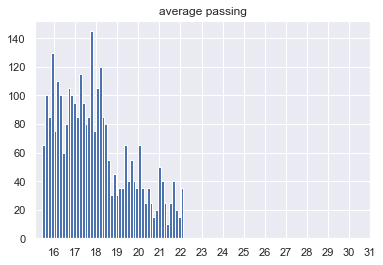

In [65]:
coded = np.loadtxt(os.path.join("output","LV3","Avg","LV3RejectionResults.txt"))
SCfreqs = np.loadtxt(os.path.join("output","LV3","Avg","SCfreqs"))
mappedIDxs,freqsAVGpassing = getRasterData(coded,SCfreqs)#returns the network ids mapped from 0-#passing networks, and the SC frequencies at which the network id passed

counts, bins = np.histogram(freqsAVGpassing,bins=np.arange(16,32))
plt.hist(freqsAVGpassing,bins=50, align='left')
plt.xticks(np.arange(16,32),np.arange(16,32))
plt.title('average passing')
plt.savefig('average passing')

In [67]:
len(freqsAVGpassing)

3120

In [68]:
len(freqsnonavgpassing)

3865

In [211]:
a1 = np.where(freqsAVGpassing >18 )[0] 
a2 = np.where(freqsAVGpassing < 21)[0]

In [212]:
a1Ina2 = [1 if a1[i] in a2 else 0 for i in range(len(a1))]

In [213]:
a1Ina2.count(1)

2780

In [124]:
print('%d averaged parameter sets including repetitions passed\n%d nonaveraged parameter sets including repetitions passed' %(freqsAVGpassing.shape[0],freqsnonavgpassing.shape[0]))

4955 averaged parameter sets including repetitions passed
4815 nonaveraged parameter sets including repetitions passed


In [193]:
freqsAVGpassing.shape

(5145,)

### raster plot of frequencies that cells pass

file saved as cellIdsfreq.png


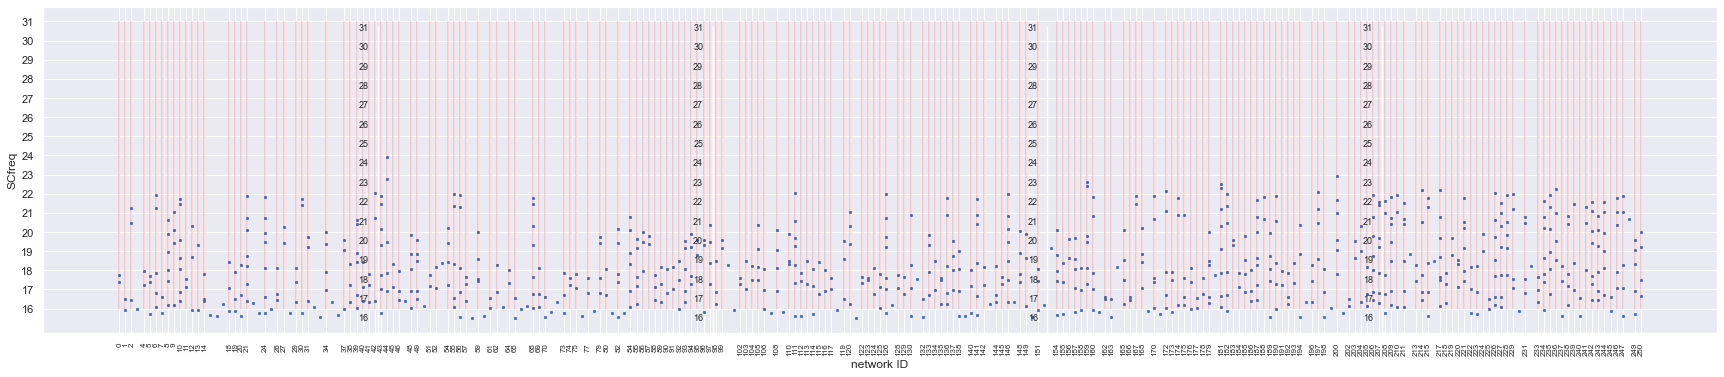

In [69]:
coded = np.loadtxt(os.path.join("output","LV3","LV3RejectionResults.txt"))
SCfreqsnonavg = np.loadtxt(os.path.join("output","LV3","SCfreqs"))
mappedIDxs,freqsnonavgpassing = getRasterData(coded,SCfreqsnonavg)
plotRaster(mappedIDxs,freqsnonavgpassing)

## find and plot the network in the original data from the network id in the raster

In [8]:
coded = np.loadtxt(os.path.join(archivedPath,"output","LV3","LV3RejectionResults.txt"))
passnetIDs,passnetIDXs = getpassingNetIDXs(coded)
mappedIDxs,IDxs = mapping(passnetIDXs)
unMap(mappedIDxs,IDxs,passnetIDs,9)

-1

In [244]:
Trials = LV2Params.shape[1]
LVL = 'LV3'
seed = 222
SCfreqs = []
bufferSize = 50
np.random.seed(int(seed))
for j in range(0,int(Trials/16/5)):
    for i in range(0,16):
        SCfreqs.append(np.random.uniform(15.5+i,16.5+i))
if LVL == 'LV3':
    SCfreqs = np.repeat(SCfreqs,5)


In [238]:
All = []
for j in range(0,int(Trials/16)):
    for i in range(0,16):
        freq = SCfreqs[(j*16)+i]*0.6
        spikeNo = math.ceil(freq*.300)#the frequency for the 300 ms beginning
        firstPart = np.linspace(300,600,spikeNo)

        freq = SCfreqs[(j*16)+i]*0.9
        spikeNo = math.ceil(freq*0.600)#the freq for the 600 ms middle
        secondPart = np.linspace(600,1200,spikeNo)
        secondSpace = math.floor(secondPart[3] - secondPart[2])#we want the first event of the middle of the burst to be the same distance from the last spike of the first time..
        secondPart = np.linspace(firstPart[len(firstPart)-1]+secondSpace ,1200,spikeNo)#..so the spikes remain relatively even

        freq = SCfreqs[(j*16)+i]*0.4
        spikeNo = math.ceil(freq*.100)#freq for the 100 ms end 
        thirdPart = np.linspace(1200,1300,spikeNo)
        thirdSpace = math.floor(secondPart[len(secondPart)-1] - secondPart[len(secondPart)-2])
        thirdPart = np.linspace(secondPart[len(secondPart)-1] + thirdSpace,1200,spikeNo)
        

        args = [firstPart,secondPart,thirdPart,np.zeros((bufferSize-(len(firstPart)+ len(secondPart) + len(thirdPart))))]
        All.append(np.concatenate(args,axis=0))

All = np.array(All,dtype=object)

In [4]:
VsomaControl = np.array(pd.read_pickle(r"C:\Users\ddopp\source\repos\CGresults\notAVG\output\LV3\VsomaControl.pkl")).T
VsomaTEA = np.array(pd.read_pickle(r"C:\Users\ddopp\source\repos\CGresults\notAVG\output\LV3\VsomaTEA.pkl")).T

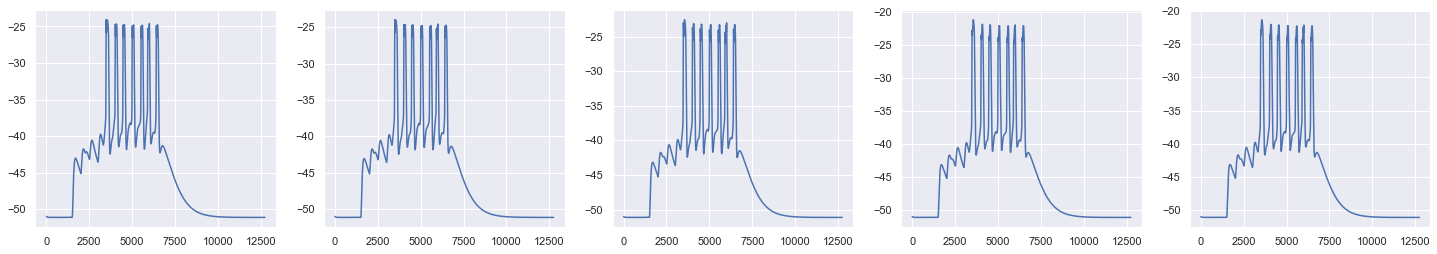

In [156]:

plotNet(VsomaControl,neworkID,16)
plt.show()

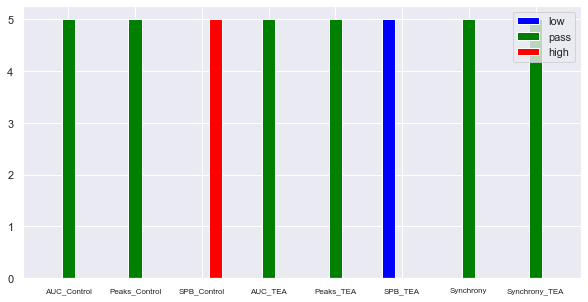

In [153]:
plotFailCrit(coded[:,neworkID*80+10:neworkID*80+15],LV3CritList())
plt.show()

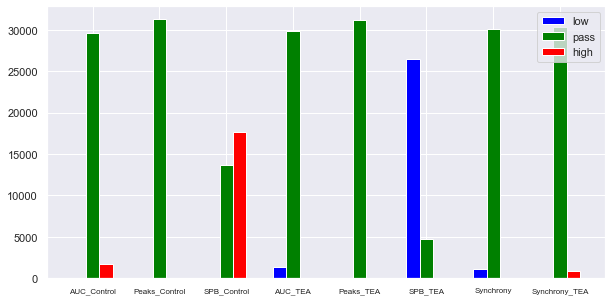

In [174]:
rejectionResults = np.loadtxt(os.path.join("output","LV3","LV3RejectionResults.txt"))
plotFailCrit(rejectionResults,LV3CritList())
plt.savefig('rejection criteria LV3')
plt.show()

### development

In [67]:
#plot boxplots of all parameters of interest for passing or nonpassing cells

In [91]:
def getStats(paramsDF,failCriteriaRaw,failCriteriacoded,passing):#unused
    
    [a,b] = failCriteriacoded.shape
    if passing == 'passing':
        IDXs = np.where(failCriteriacoded[a-1,:]==1)[0]
    elif passing == 'low':
        IDXs = np.where(failCriteriacoded[a-1,:]<1)[0]
    elif passing == 'high':
        IDXs = np.where(failCriteriacoded[a-1,:] > 1)[0]
    
    selected_df = pd.DataFrame([paramsDF[key][IDXs] for key in paramsDF]).T
        

In [92]:
def summaryStats(selecteddf,pair):   
    
    AVG = np.mean(selecteddf[pair[0]])
    STD = np.std(selecteddf[pair[0]])
    #Skew = stats.skew(selecteddf)
   # Kurt = stats.kurtosis(selecteddf, fisher=True)
    retDict = {'parameter' : pair[0],
               'rCriteria': pair[1],
               'AVG' : AVG,
               'STD': STD,
               #'Skew' : Skew,
               #'Kurt' : Kurt
              }
    return retDict

In [93]:
def tTest(passDf,failDf,pair):
    eqVar = True
    if abs(np.std(passDf[pair[0]]) - np.std(passDf[pair[1]]) ) < abs(np.std(passDf[pair[0]]))/ 2:
        eqVar = False
    return stats.ttest_ind(passDf[pair[0]], failDf[pair[0]], equal_var=eqVar)

In [122]:
def makestatsDict(paramsDF,failCriteriacoded,pairList,passing):
    
    allStats = []
    for i in range(len(pairList)):
        passIDXs = failCriteriacoded[pairList[i][1]] == 1
        lowIDXs = failCriteriacoded[pairList[i][1]] < 1
        highIDXs = failCriteriacoded[pairList[i][1]] > 1

        passdf = pd.DataFrame([paramsDF[key][passIDXs] for key in paramsDF]).T
        lowdf = pd.DataFrame([paramsDF[key][lowIDXs] for key in paramsDF]).T
        highdf = pd.DataFrame([paramsDF[key][highIDXs] for key in paramsDF]).T
        

        if passing == 'passing':
            statsDict = summaryStats(passdf,pairList[i])
            lowtest = tTest(passdf,lowdf,pairList[i])
            hightest = tTest(passdf,highdf,pairList[i])
            statsDict.update({'fail low p-value':lowtest[1]})
            statsDict.update({'fail high p-value': hightest[1]})
        elif passing == 'low':
            statsDict = summaryStats(lowdf,pairList[i])
        elif passing == 'high':
            statsDict = summaryStats(highdf,pairList[i])
        allStats.append(statsDict)
    allStats = pd.DataFrame(allStats)
    return allStats

In [154]:

rejectionResultsRaw = np.loadtxt(os.path.join("output","LV3","LV3RejectionRaw.txt"))
rejectionResults = np.loadtxt(os.path.join("output","LV3","LV3RejectionResults.txt"))
params = np.array(pd.read_pickle(os.path.join("output","LV3","passParamsRepeat"  + ".pkl")))

In [164]:
paramsDF = pd.DataFrame(np.vstack((params,rejectionResultsRaw)).T,columns = fullParamsList() + LV3CritList())
#concat params with rejection results data, and make a df with the columns as variables
passIdxs,failIdxs,allIdxs = getPassIdxs(rejectionResults)
passParams = getEveryFirstNet(LV3passParams[:,passIdxs])
# get only the passing parameters into a dataframe keeping columns as variables
passParamsDF = pd.DataFrame([paramsDF[key][passIdxs] for key in paramsDF]).T
flParamsDF = pd.DataFrame([paramsDF[key][failIdxs] for key in paramsDF]).T

In [96]:
# get the df with pass or fail idxs, get a list of the pass pairs and for each pair, get sum stats. print(this is the mean for passpair 0  that passed)

In [165]:
#get a df of the correlogram but with only the correlations between intrinsic parameters and rejection criteria that are above 0.2
dfCorr = passParamsDF.corr(method='pearson')
maskedDFCorr = np.array(dfCorr)
mask = (abs(dfCorr) > 0.1) & (abs(dfCorr < 1))
mask = np.array(mask)
for i in range(len(mask)):
    for j in range(len(mask)):
        if (i < len(fullParamsList())) & (j <len(fullParamsList())):
            maskedDFCorr[i][j] = np.nan

maskedDFCorr = pd.DataFrame(maskedDFCorr)
maskedDFCorr = maskedDFCorr[pd.DataFrame(mask)]
maskedDFCorr.columns = fullParamsList() + LV3CritList()
maskedDFCorr.index = fullParamsList() + LV3CritList()

In [166]:
#get a list of the pairs of parameters and rejection criteria that are above 0.2
passpairs = []
for param1 in maskedDFCorr:
    for i in range(len(maskedDFCorr[param1])):
        if not np.isnan(maskedDFCorr[param1][i]):
            passpairs.append((param1,(maskedDFCorr.keys())[i]))
passpairs = list(set(passpairs))
pairList = []
for pair in passpairs:
    if pair[0] in fullParamsList():       
        pairList.append(pair)

In [167]:
failCriteriacoded = pd.DataFrame(rejectionResults).T
failCriteriacoded.columns = LV3CritList()

In [168]:
lowDict = makestatsDict(paramsDF,failCriteriacoded,pairList,'low')
passDict = makestatsDict(paramsDF,failCriteriacoded,pairList,'passing')
highDict = makestatsDict(paramsDF,failCriteriacoded,pairList,'high')
passDict.columns = ['parameter','rCriteria','AVG_passing','STD_passing','fail low p-value','fail high p-value']
lowDict.columns = ['parameter','rCriteria','AVG_Low','STD_Low']
highDict.columns = ['parameter','rCriteria','AVG_High','STD_High']
allDF = pd.merge(passDict,lowDict)
allDF = pd.merge(allDF,highDict)
allDF = allDF[['parameter','rCriteria','AVG_passing','STD_passing','AVG_Low','STD_Low','AVG_High','STD_High','fail low p-value','fail high p-value']]

In [169]:
allDF

parameter      rCriteria  AVG_passing  STD_passing   AVG_Low  \
0       soma_leak        AUC_TEA     0.000230     0.000093  0.000250   
1       soma_leak      Synchrony     0.000234     0.000093  0.000144   
2    neurite_leak    AUC_Control     0.000190     0.000082       NaN   
3      soma_skkca        AUC_TEA     0.001429     0.000320  0.001494   
4       soma_leak    AUC_Control     0.000238     0.000091       NaN   
5       soma_leak  Synchrony_TEA     0.000228     0.000093       NaN   
6        soma_cal        AUC_TEA     0.000097     0.000018  0.000102   
7       soma_leak  Peaks_Control     0.000231     0.000094       NaN   
8       soma_nap2      Peaks_TEA     0.000233     0.000071  0.000132   
9    neurite_leak        AUC_TEA     0.000185     0.000082  0.000236   
10   neurite_leak        SPB_TEA     0.000183     0.000083  0.000188   
11  neurite_bkkca  Peaks_Control     0.003407     0.001496       NaN   
12   neurite_nap2  Peaks_Control     0.000242     0.000067       NaN   
13      soma_leak      Peaks_TEA     0.000231     0.000094  0.000320   
14   neurite_nap2    AUC_Control     0.000244     0.000066       NaN   

     STD_Low  AVG_High      STD_High  fail low p-value  fail high p-value  
0   0.000100  0.000091  8.782207e-06      3.067343e-14       2.259020e-05  
1   0.000066       NaN           NaN     6.242721e-231                NaN  
2        NaN  0.000146  7.473124e-05               NaN      1.032361e-101  
3   0.000330  0.001324  2.380062e-04      1.201955e-13       3.540920e-01  
4        NaN  0.000118  4.642737e-05               NaN       0.000000e+00  
5        NaN  0.000318  5.937218e-05               NaN      1.858927e-180  
6   0.000019  0.000068  5.250477e-07      2.130853e-25       8.872969e-06  
7        NaN       NaN           NaN               NaN                NaN  
8   0.000056       NaN           NaN      5.277541e-22                NaN  
9   0.000077  0.000089  3.606051e-05     2.847716e-111       8.913501e-04  
10  0.000082       NaN           NaN      1.246979e-05                NaN  
11       NaN       NaN           NaN               NaN                NaN  
12       NaN       NaN           NaN               NaN                NaN  
13  0.000040       NaN           NaN      1.004592e-10                NaN  
14       NaN  0.000221  7.160578e-05               NaN       7.809727e-41

In [9]:
allDF.to_csv('rejectionStatsAVG.csv')

# plot passing network SIZ and Isyn under the Voltage trace. And event times

In [2]:
LV3SIZ = np.array(pd.read_pickle(os.path.join("output","LV3","VSIZControl.pkl")))
LV3SIZ.shape
LV3ISYN = np.array(pd.read_pickle(os.path.join("output","LV3","ISYNControl.pkl")))
LV3Soma = np.array(pd.read_pickle(os.path.join("output","LV3","VSomaControl.pkl")))
ET = np.array(pd.read_pickle(os.path.join("output","LV3","EventTimesControl.pkl")))

In [21]:
times = np.linspace(0,2550,LV3SIZ.shape[1])

In [4]:
ET.shape

(80, 25)

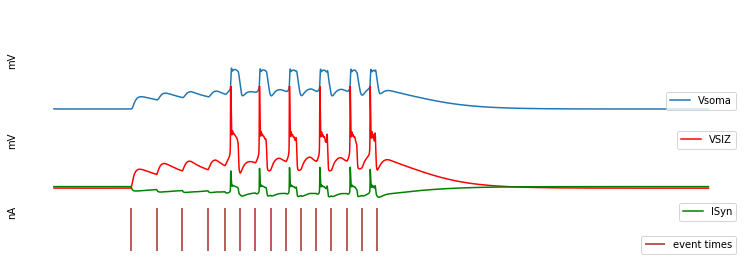

In [23]:
cellNum = 1
freqNo = 18
IDX = (freqNo-16)*5 +cellNum


fig,axs = plt.subplots(4,figsize=(10,5),sharex=True,sharey=True, subplot_kw=dict(frameon=False))
axs[0].plot(times,LV3Soma[IDX,:],label='Vsoma')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_ylim([-52,-20])
axs[0].set_position([0,1,1,0.3])
axs[0].legend(loc='lower right')
axs[0].set_ylabel('mV')

axs[1].plot(times,LV3SIZ[IDX,:],label='VSIZ',color='r')
axs[1].set_ylim([-55,20])
axs[1].set_position([0,0.78,1,0.3])
axs[1].legend(loc='right')
axs[1].set_ylabel('mV')

axs[2].plot(times,LV3ISYN[IDX,:],label='ISyn',color='g')
axs[2].set_position([0,0.58,1,0.3])
axs[2].legend(loc='right')
axs[2].set_ylabel('nA')

axs[3].vlines((ET[IDX,:]/.2).T,ymin=-50,ymax=-20,label='event times',color='brown')
axs[3].set_position([0,0.6,1,0.3])
axs[3].legend(loc='lower right')
plt.savefig('traces.png',dpi=500,facecolor='w',bbox_inches='tight')
plt.show()

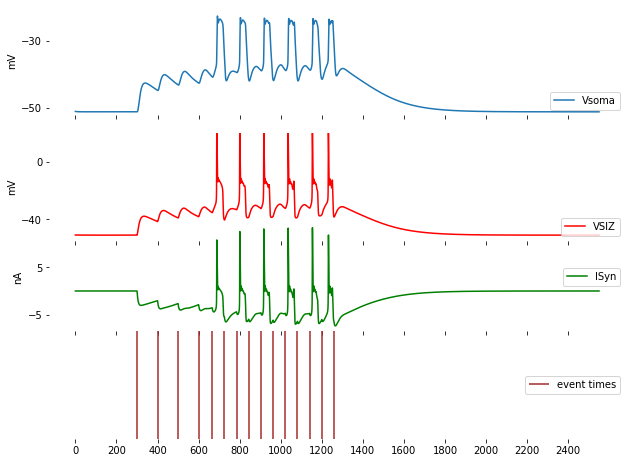

In [54]:
cellNum = 1
freqNo = 18
IDX = (freqNo-16)*5 +cellNum
ETIDX = freqNo-16

fig,axs = plt.subplots(4,figsize=(8,5),sharex=True, subplot_kw=dict(frameon=False))
axs[0].plot(times,LV3Soma[IDX,:],label='Vsoma')
axs[0].set_xticks(list(np.arange(0,2550,200)))
axs[0].set_yticks([-50,-30])
axs[0].set_ylim([-52,-20])
axs[0].set_position([0,1,1,0.3])
axs[0].legend(loc='lower right')
axs[0].set_ylabel('mV')

axs[1].plot(times,LV3SIZ[IDX,:],label='VSIZ',color='r')
axs[1].set_ylim([-55,20])
axs[1].set_position([0,0.65,1,0.3])
axs[1].set_yticks([-40,0])
axs[1].legend(loc='lower right')
axs[1].set_ylabel('mV')

axs[2].plot(times,LV3ISYN[IDX,:],label='ISyn',color='g')
axs[2].set_position([0,0.40,1,0.3])
axs[2].set_yticks([-5,5])
axs[2].legend(loc='right')
axs[2].set_ylabel('nA')

axs[3].vlines((ET[IDX,:]).T,ymin=0,ymax=1,label='event times',color='brown')
axs[3].set_ylim([0,1])
axs[3].set_position([0,0.1,1,0.3])
axs[3].set_yticks([])
axs[3].legend(loc='right')

plt.savefig('traces.png',dpi=500,facecolor='w',bbox_inches='tight')
plt.show()

# find the synaptic conductances that give passing networks:

## LV2

In [57]:
archivedPathLow = os.path.join("..","CGresults","fixed_Gsyn","Low")
archivedPathMed = os.path.join("..","CGresults","fixed_Gsyn","Med")
archivedPathHigh = os.path.join("..","CGresults","fixed_Gsyn","High")
#C:\Users\ddopp\source\repos\CGresults\fixed_Gsyn\Low\LV3
#archivedPath  = "output"
LV2ParamsLow =  np.array(pd.read_pickle(os.path.join(archivedPathLow,"LV2","passParamsRepeatControl.pkl")))
LV2ParamsMed = np.array(pd.read_pickle(os.path.join(archivedPathMed,"LV2","passParamsRepeatControl.pkl")))
LV2ParamsHigh = np.array(pd.read_pickle(os.path.join(archivedPathHigh,"LV2","passParamsRepeatControl.pkl")))

LV2codedLow = np.loadtxt(os.path.join(archivedPathLow,"LV2","LV2RejectionResults.txt"))
LV2codedMed = np.loadtxt(os.path.join(archivedPathMed,"LV2","LV2RejectionResults.txt"))
LV2codedHigh = np.loadtxt(os.path.join(archivedPathHigh,"LV2","LV2RejectionResults.txt"))

LV2passIdxsLow,LV2failIdxsLow,LV2allIdxsLow = getPassIdxs(LV2codedLow,'LV2')#indices of each cell that passed including repeats at different freqs, same for fail, 1 marked at all 16 freqs at which a cell passed
LV2passIdxsMed,LV2failIdxsMed,LV2allIdxsMed = getPassIdxs(LV2codedMed,'LV2')
LV2passIdxsHigh,LV2failIdxsHigh,LV2allIdxsHigh = getPassIdxs(LV2codedHigh,'LV2')


paramsLV2PassingLow = LV2ParamsLow[:,LV2passIdxsLow]
paramsLV2PassingMed = LV2ParamsMed[:,LV2passIdxsMed]
paramsLV2PassingHigh = LV2ParamsHigh[:,LV2passIdxsHigh]

using LV2
using LV2
using LV2


In [117]:
%matplotlib widget

In [119]:
%matplotlib inline

In [ ]:
testparams = paramsLV2PassingLow
plt.figure(figsize=(20,5))
plt.hist(testparams)
plt.title('LV2 passing networks')
plt.xlabel('uS')
plt.ylabel('# cells')
plt.show()

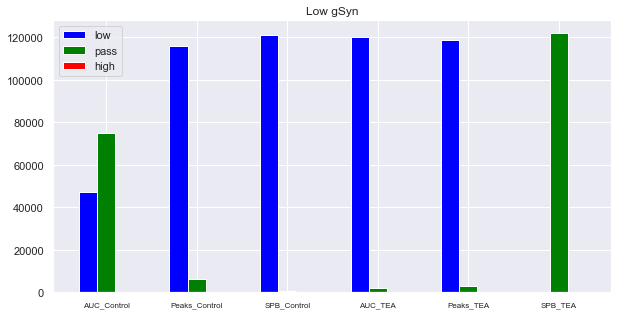

In [62]:
testCoded  = LV2codedLow
testCodedList = LV2CritList()
plotFailCrit(testCoded,testCodedList)
plt.title('Low gSyn')
plt.show()

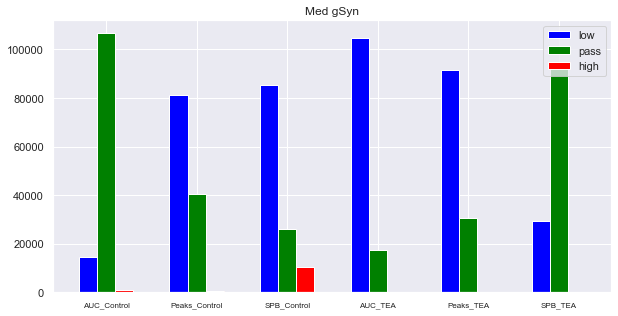

In [63]:
testCoded  = LV2codedMed
testCodedList = LV2CritList()
plotFailCrit(testCoded,testCodedList)
plt.title('Med gSyn')
plt.show()

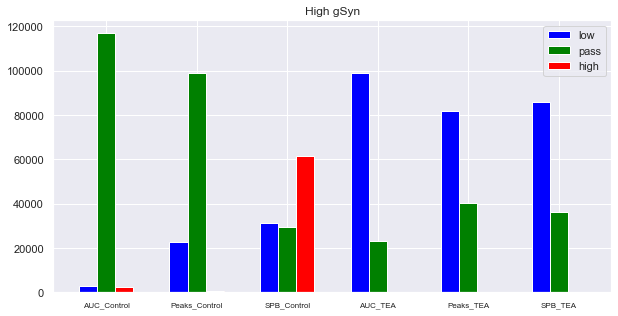

In [64]:
testCoded  = LV2codedHigh
testCodedList = LV2CritList()
plotFailCrit(testCoded,testCodedList)
plt.title('High gSyn')
plt.show()

In [5]:
SCfreqs = np.loadtxt(os.path.join(archivedPath,"LV2",'SCfreqs'))
SCfreqsPassing = SCfreqs[passIdxs]

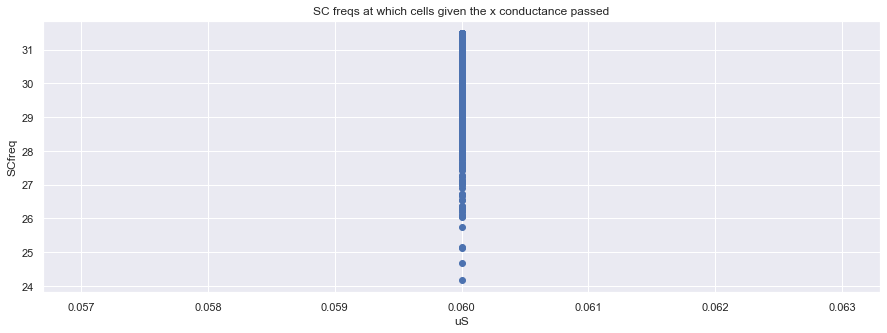

In [6]:
plt.figure(figsize=(15,5))
plt.scatter(LV2Params[paramsLV2Passing.shape[0]-1,passIdxs],SCfreqsPassing)
plt.title('SC freqs at which cells given the x conductance passed')
plt.xlabel('uS')
plt.ylabel('SCfreq')
plt.savefig('scfreq vs gSyn.png',dpi=200)
plt.show()

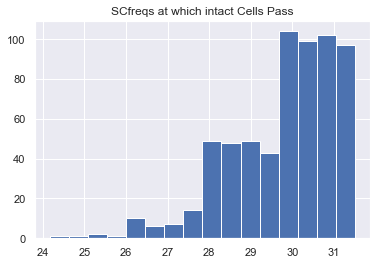

In [7]:
plt.hist(SCfreqsPassing,bins=16)
plt.title('SCfreqs at which intact Cells Pass')
plt.show()

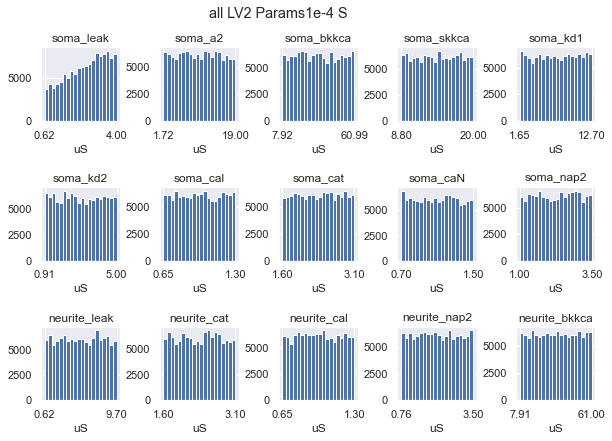

In [11]:
plotDistributions(LV2Params,fullParamsList(),20,title = 'all LV2 Params',xlabels='uS')

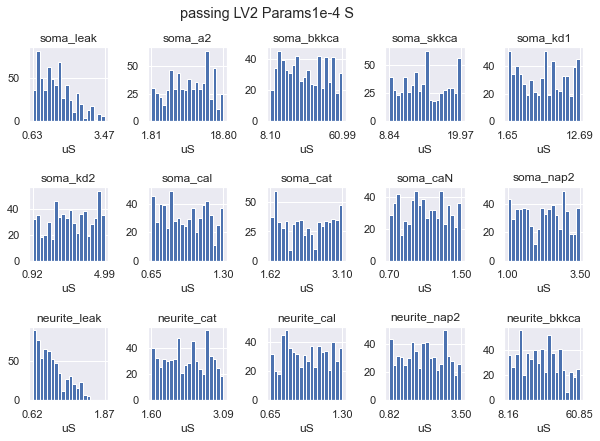

In [12]:
plotDistributions(LV2Params[:,passIdxs],fullParamsList(),20,title = 'passing LV2 Params',xlabels='uS')

## LV3

In [121]:
#archivedPathLV3 = os.path.join("..","CGresults","fixed_Gsyn","Med")
archivedPathLV3 = os.path.join("..","CGresults","fixed_Gsyn","MedwithLV2")
#LV3Params =  np.array(pd.read_pickle(os.path.join(archivedPath,"LV3","passParamsRepeat.pkl")))
#coded = np.loadtxt(os.path.join(archivedPath,"LV3","LV3RejectionResults.txt"))

LV3Params = np.array(pd.read_pickle(os.path.join(archivedPathLV3,"AVG","passParamsRepeat.pkl")))
codedLV3 = np.loadtxt(os.path.join(archivedPathLV3,"AVG","LV3RejectionResults.txt"))
rawLV3 = np.loadtxt(os.path.join(archivedPathLV3,"AVG","LV3RejectionRaw.txt"))
SCfreqsLV3 = np.loadtxt(os.path.join(archivedPathLV3,"AVG",'SCfreqs'))
totalParamsLV3 = np.concatenate((LV3Params,SCfreqsLV3.reshape(1,-1),rawLV3),axis=0)
passIdxsLV3,failIdxs,allIdxs = getPassIdxs(codedLV3,'LV3')
passParamsLV3 = LV3Params[:,passIdxsLV3]

using LV3


In [124]:
passParamsLV3.shape

(15, 10320)

In [51]:

#passParams = getEveryFirstNet(LV3passParams[:,passIdxs])
archivedPathLow = os.path.join("..","CGresults","fixed_Gsyn","Low")
archivedPathMed = os.path.join("..","CGresults","fixed_Gsyn","Med")
archivedPathHigh = os.path.join("..","CGresults","fixed_Gsyn","High")
archivedPathLowgSynLowRSIZ = os.path.join("..","CGresults","fixed_Gsyn","LowgSynLowRSIZ")
#C:\Users\ddopp\source\repos\CGresults\fixed_Gsyn\Low\LV3
#archivedPath  = "output"
LV3ParamsLow =  np.array(pd.read_pickle(os.path.join(archivedPathLow,"LV3","passParamsRepeat.pkl")))
LV3ParamsMed = np.array(pd.read_pickle(os.path.join(archivedPathMed,"LV3","passParamsRepeat.pkl")))
LV3ParamsHigh = np.array(pd.read_pickle(os.path.join(archivedPathHigh,"LV3","passParamsRepeat.pkl")))
LV3ParamsLowgSynLowRSIZ = np.array(pd.read_pickle(os.path.join(archivedPathLowgSynLowRSIZ,"LV3","passParamsRepeat.pkl")))

LV3codedLow = np.loadtxt(os.path.join(archivedPathLow,"LV3","LV3RejectionResults.txt"))
LV3codedMed = np.loadtxt(os.path.join(archivedPathMed,"LV3","LV3RejectionResults.txt"))
LV3codedHigh = np.loadtxt(os.path.join(archivedPathHigh,"LV3","LV3RejectionResults.txt"))
LV3codedLowgSynLowRSIZ = np.loadtxt(os.path.join(archivedPathLowgSynLowRSIZ,"LV3","LV3RejectionResults.txt"))

LV3RawLow = np.loadtxt(os.path.join(archivedPathLow,"LV3","LV3RejectionRaw.txt"))
LV3RawMed = np.loadtxt(os.path.join(archivedPathMed,"LV3","LV3RejectionRaw.txt"))
LV3RawHigh = np.loadtxt(os.path.join(archivedPathHigh,"LV3","LV3RejectionRaw.txt"))
LV3RawLowgSynLowRSIZ = np.loadtxt(os.path.join(archivedPathLowgSynLowRSIZ,"LV3","LV3RejectionRaw.txt"))


LV3passIdxsLow,LV3failIdxsLow,LV3allIdxsLow = getPassIdxs(LV3codedLow,'LV3')#indices of each cell that passed including repeats at different freqs, same for fail, 1 marked at all 16 freqs at which a cell passed
LV3passIdxsMed,LV3failIdxsMed,LV3allIdxsMed = getPassIdxs(LV3codedMed,'LV3')
LV3passIdxsHigh,LV3failIdxsHigh,LV3allIdxsHigh = getPassIdxs(LV3codedHigh,'LV3')
LV3passIdxsLowgSynLowRSIZ,LV3failIdxsLowgSynLowRSIZ,LV3allIdxsLowgSynLowRSIZ = getPassIdxs(LV3codedLowgSynLowRSIZ,'LV3')

paramsLV3PassingLow = LV3ParamsLow[:,LV3passIdxsLow]
paramsLV3PassingMed = LV3ParamsMed[:,LV3passIdxsMed]
paramsLV3PassingHigh = LV3ParamsHigh[:,LV3passIdxsHigh]
paramsLV3PassingLowgSynLowRSIZ = LV3ParamsLowgSynLowRSIZ[:,LV3passIdxsLowgSynLowRSIZ]

totalParamsLV3PassingLow = np.vstack((paramsLV3PassingLow,LV3RawLow[:,LV3passIdxsLow]))#for use in Correlogram
totalParamsLV3PassingMed = np.vstack((paramsLV3PassingMed,LV3RawMed[:,LV3passIdxsMed]))
totalParamsLV3PassingHigh = np.vstack((paramsLV3PassingHigh,LV3RawHigh[:,LV3passIdxsHigh]))
totalParamsLV3PassingLowgSynLowRSIZ = np.vstack((paramsLV3PassingLowgSynLowRSIZ,LV3RawLowgSynLowRSIZ[:,LV3passIdxsLowgSynLowRSIZ]))


using LV3
using LV3
using LV3
using LV3


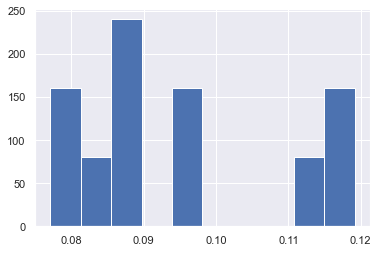

In [7]:
plt.hist(passParamsLV3[16,:])
plt.show()

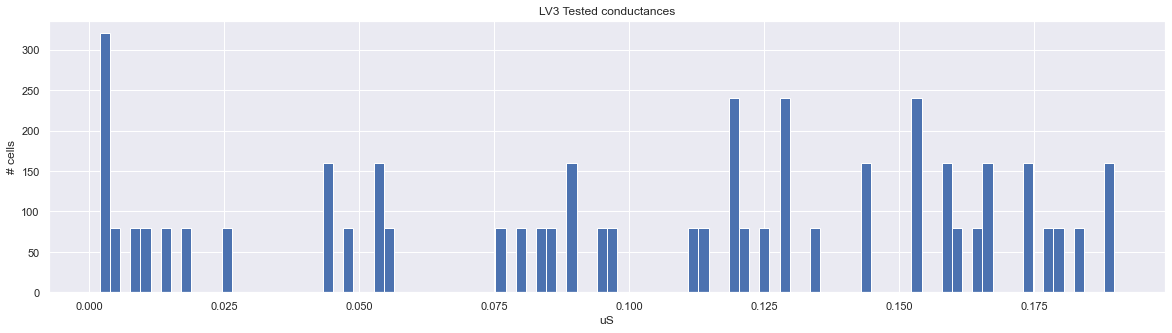

In [8]:
plt.figure(figsize=(20,5))
plt.hist(LV3Params[LV3Params.shape[0]-1,:],bins=100)
plt.title('LV3 Tested conductances')
plt.xlabel('uS')
plt.ylabel('# cells')
plt.show()

In [69]:
#%matplotlib widget
%matplotlib inline

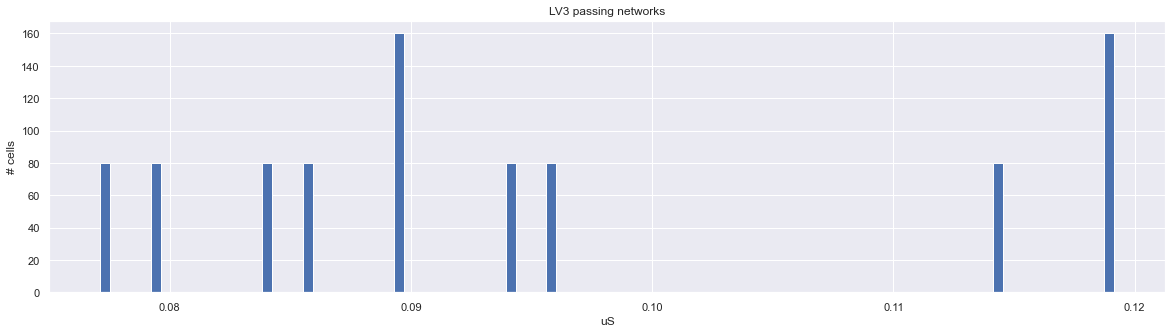

In [9]:
#34 passing networks
#160 means two networks passed, 80 means 1 network passed
plt.figure(figsize=(20,5))
plt.hist(passParamsLV3[passParamsLV3.shape[0]-1,:],bins=100)
plt.title('LV3 passing networks')
plt.xlabel('uS')
plt.ylabel('# cells')
plt.savefig('passing conductances.png')
plt.show()

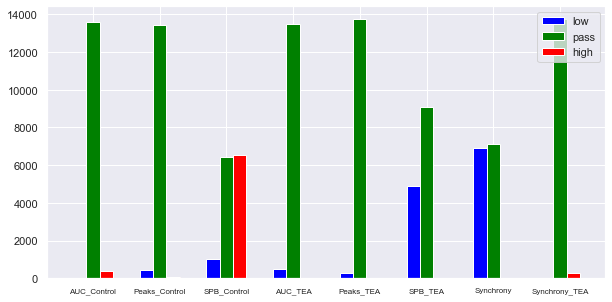

In [13]:
plotFailCrit(codedLV3,LV3CritList())

plt.show()

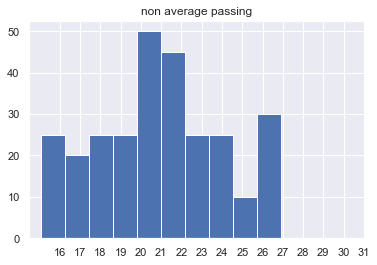

In [11]:
mappedIDxs,freqsnonavgpassing = getRasterData(codedLV3,SCfreqsLV3)#returns the network ids mapped from 0-#passing networks, and the SC frequencies at which the network id passed
counts, bins = np.histogram(freqsnonavgpassing,bins=np.arange(16,32))
plt.hist(freqsnonavgpassing, align='left')
plt.xticks(np.arange(16,32),np.arange(16,32))
plt.title('non average passing')
plt.savefig('non average passing')

In [21]:
min(passParamsLV3[passParamsLV3.shape[0]-1,:])

0.0007942664

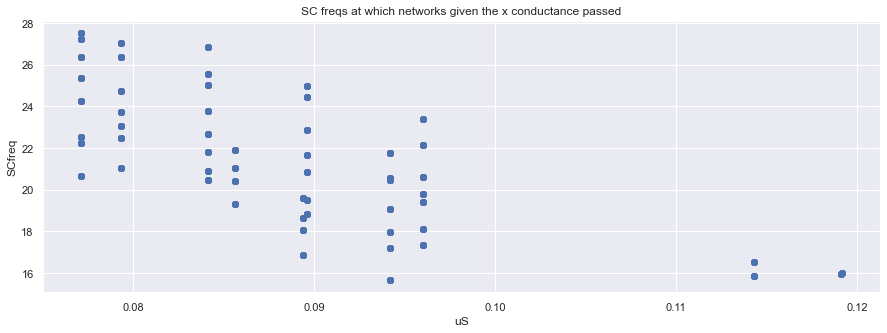

In [12]:
plt.figure(figsize=(15,5))
plt.scatter(passParamsLV3[passParamsLV3.shape[0]-1,mappedIDxs*80],freqsnonavgpassing)
plt.title('SC freqs at which networks given the x conductance passed')
plt.xlabel('uS')
plt.ylabel('SCfreq')
plt.show()

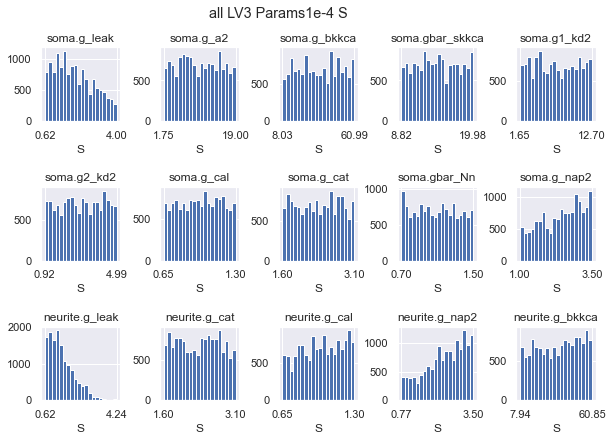

In [17]:
LV3Params = 
paramsList = list(rangeVarNames().keys())
plotDistributions(LV3Params,paramsList,20,xlabels='S',title = 'all LV3 Params')

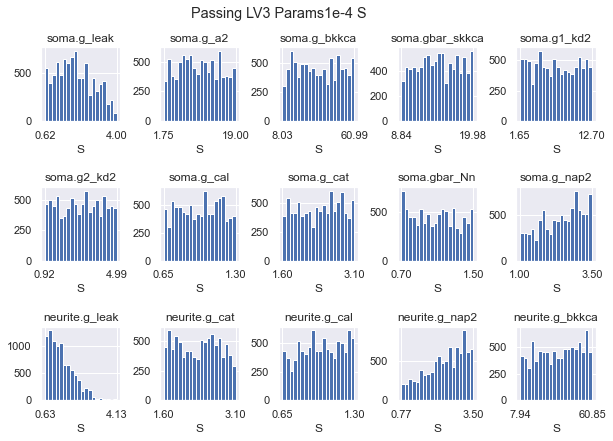

In [18]:
plotDistributions(LV3Params[:,passIdxsLV3],paramsList,20,xlabels='S',title = 'Passing LV3 Params')

from 129 Passing Networks
0.09 uS


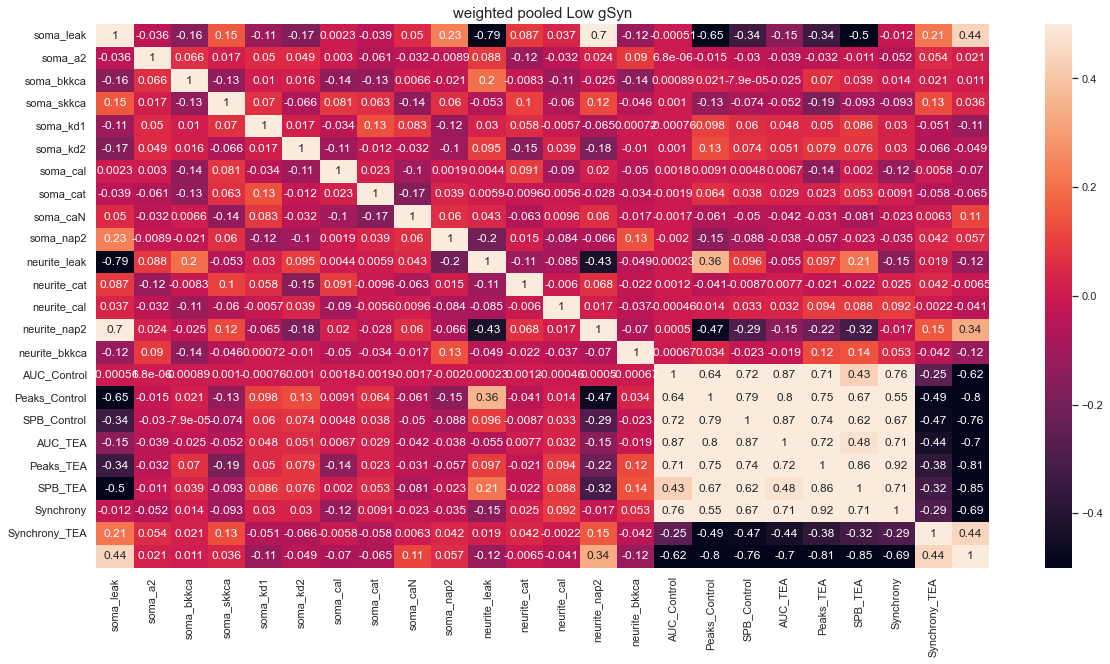

In [126]:
TestpassParams = totalParamsLV3[:,passIdxsLV3]
TestparamsList = fullParamsList()+LV3CritList()
plotCorrelogram(TestpassParams,TestparamsList,'weighted pooled Low gSyn')
print("from %d Passing Networks" %(int(TestpassParams.shape[1]/80)))
print("0.09 uS")
plt.show()

from 113 Passing Networks
0.09 uS


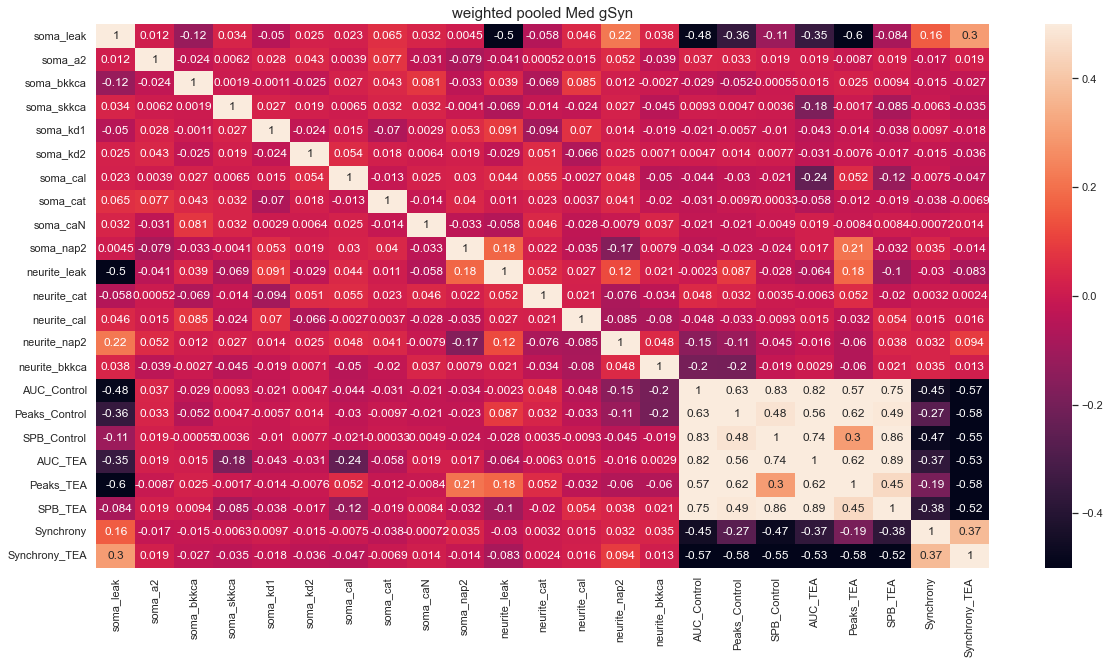

In [20]:
TestpassParams = totalParamsLV3PassingMed
TestparamsList = fullParamsList()+LV3CritList()
plotCorrelogram(TestpassParams,TestparamsList,'weighted pooled Med gSyn')
plt.savefig("Med gSyn.png",dpi=300)
print("from %d Passing Networks" %(int(TestpassParams.shape[1]/80)))
print("0.09 uS")
plt.show()

from 42 Passing Networks
0.12 uS


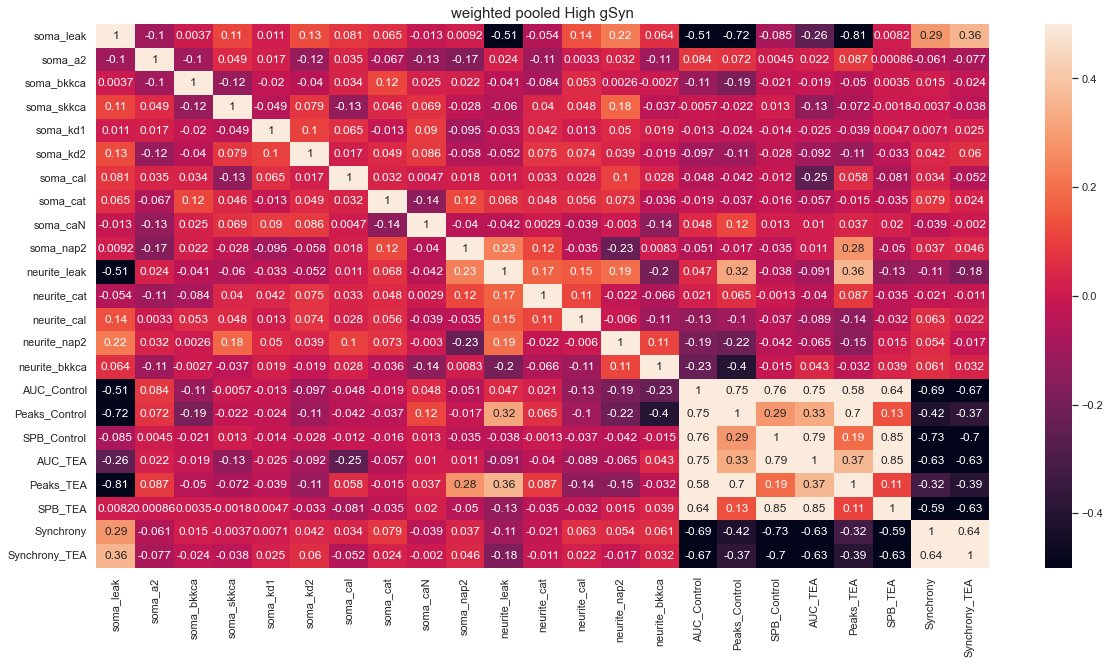

In [21]:
TestpassParams = totalParamsLV3PassingHigh
TestparamsList = fullParamsList()+LV3CritList()
plotCorrelogram(TestpassParams,TestparamsList,'weighted pooled High gSyn')
print("from %d Passing Networks" %(int(TestpassParams.shape[1]/80)))
print("0.12 uS")
plt.show()

# generate a table of the parameters according to compartment that has  values in a certain range

In [26]:
cTest = pd.DataFrame(np.corrcoef(paramsLV3PassingLow),index = fullParamsList(),columns = fullParamsList())

In [ ]:
cTest[np.logical_and(cTest > 0.1,cTest < 0.99)]

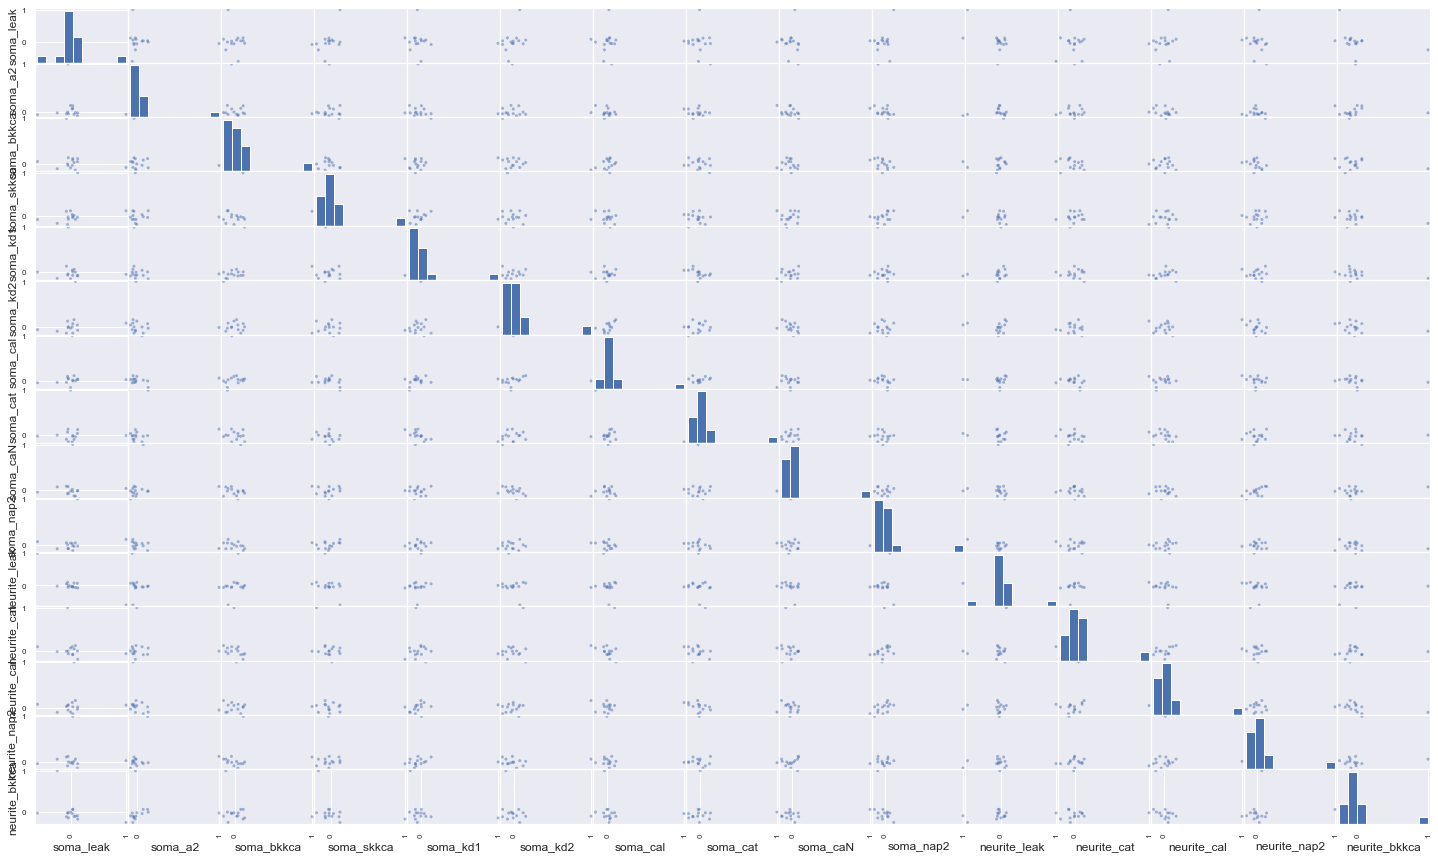

In [36]:
pd.plotting.scatter_matrix(cTest,figsize=(25,15))
plt.show()

In [113]:
def getRes(rType):
    var = "paramsLV3Passing" + rType
    TestpassParams = globals()[var]
    TestparamsList = fullParamsList()
    CorrRange = [0.06,0.999]
    
    def Report(df,Key):# so we can easily get soma or neurite
        r1 = [True if Key in CorrsDF.loc['conductance1'][i] else False for i in range(len(CorrsDF.loc['conductance1']))]
        r2 = [True if Key in CorrsDF.loc['conductance2'][i] else False for i in range(len(CorrsDF.loc['conductance2']))]
        query = np.logical_and(r1,r2)
        return pd.DataFrame([CorrsDF.loc['conductance1'][query],CorrsDF.loc['conductance2'][query],CorrsDF.loc['Pearsons_R'][query]])
# gets a data frame of all the values on the left lower diagonal which are in the CorrRange of interest 

    TestpassParamsCorr = np.corrcoef(TestpassParams)
    rList,cList,corrVals = [],[],[]
    for i in range(len(TestparamsList)):
        for j in range(len(TestparamsList)):
            if i >= j:#then we are in the right side of the correlogram
                pass
            elif CorrRange[0] < np.abs(TestpassParamsCorr[i][j]) < CorrRange[1]:
                rList.append(TestparamsList[i])
                cList.append(TestparamsList[j])
                corrVals.append(TestpassParamsCorr[i][j])

    CorrsDF = pd.DataFrame(data = [rList,cList,corrVals]).dropna(axis=1)
    CorrsDF.index = ["conductance1","conductance2","Pearsons_R"]

    somaCorrs = Report(CorrsDF,'soma')
    neuriteCorrs = Report(CorrsDF,'neurite')
    somaList = list(somaCorrs.columns)# the column keys so we can drop them to find soma x neurite combos
    neuriteList = list(neuriteCorrs.columns)
    somaXneuriteList =  list(CorrsDF.drop(somaList + neuriteList,axis=1).columns)

    sortedDF = CorrsDF[somaList + neuriteList + somaXneuriteList]
    sortedDFList =  ["soma"]  * sortedDF[somaList].shape[1] +  ["neurite"]  * sortedDF[neuriteList].shape[1] + ["somaXneurite"] * sortedDF[somaXneuriteList].shape[1]

    sortedDF.columns = sortedDFList
    return sortedDF.T

In [8]:
LowPass = getRes('Low')
MedPass = getRes('Med')
HighPass = getRes('High')

In [22]:
LowPass.to_csv('LowPass.csv')
MedPass.to_csv('MedPass.csv')
HighPass.to_csv('HighPass.csv')

In [9]:
rLow = list(LowPass[LowPass.keys()[0]])
cLow = list(LowPass[LowPass.keys()[1]])
valLow = list(LowPass[LowPass.keys()[2]])

rMed = list(MedPass[MedPass.keys()[0]])
cMed = list(MedPass[MedPass.keys()[1]])
valMed = list(MedPass[MedPass.keys()[2]])

rHigh = list(HighPass[HighPass.keys()[0]])
cHigh = list(HighPass[HighPass.keys()[1]])
valHigh = list(HighPass[HighPass.keys()[2]])

comboLow = [(rLow[i],cLow[i]) for i in range(len(rLow))]
comboMed = [(rMed[i],cMed[i]) for i in range(len(rMed))]
comboHigh = [(rHigh[i],cHigh[i]) for i in range(len(rHigh))]

In [10]:
# Low and Med
myList = []
print("{0:12} {1:15} {2:11} {3:10}".format("g1","g2","Low xcorr", "Med Xcorr"))
print("")
for i in range(len(comboLow)):
    if (comboLow[i] in comboMed):
        print(("{0:12} {1:13} {2:10.4f} {3:10.4f}".format(comboLow[i][0],comboLow[i][1],valLow[i],valMed[comboMed.index(comboLow[i])])))
        myList.append((comboLow[i][0],comboLow[i][1],valLow[i],valMed[comboMed.index(comboLow[i])]))
medLow = pd.DataFrame(myList,columns = ["g1","g2","Low xcorr", "Med Xcorr"])

g1           g2              Low xcorr   Med Xcorr 

soma_leak    neurite_leak     -0.6089    -0.4965
soma_nap2    neurite_nap2     -0.1293    -0.1652


In [11]:
medLow.to_csv('medLow.csv')

In [12]:
# Low and High
myList = []
print("{0:12} {1:15} {2:11} {3:10}".format("g1","g2","Low xcorr", "High Xcorr"))
print("")
for i in range(len(comboLow)):
    if (comboLow[i] in comboHigh):
        print(("{0:12} {1:13} {2:10.4f} {3:10.4f}".format(comboLow[i][0],comboLow[i][1],valLow[i],valHigh[comboHigh.index(comboLow[i])])))
        myList.append((comboLow[i][0],comboLow[i][1],valLow[i],valHigh[comboHigh.index(comboLow[i])]))
lowHigh = pd.DataFrame(myList,columns = ["g1","g2","Low xcorr", "High Xcorr"])

g1           g2              Low xcorr   High Xcorr

soma_leak    soma_skkca        0.1220     0.1118
soma_bkkca   soma_skkca        0.1100    -0.1227
neurite_cal  neurite_bkkca    -0.1024    -0.1091
soma_leak    neurite_leak     -0.6089    -0.5145
soma_nap2    neurite_nap2     -0.1293    -0.2306


In [13]:
lowHigh.to_csv('lowHigh.csv')

In [14]:
# Med and High
myList = []
print("{0:12} {1:15} {2:11} {3:10}".format("g1","g2","Med xcorr", "High Xcorr"))
print("")
for i in range(len(comboMed)):
    if (comboMed[i] in comboHigh):

        print(("{0:12} {1:10} {2:10.4f} {3:10.4f}".format(comboMed[i][0],comboMed[i][1],valMed[i],valHigh[comboHigh.index(comboMed[i])])))
        myList.append((comboMed[i][0],comboMed[i][1],valMed[i],valHigh[comboHigh.index(comboMed[i])]))
medHigh =  pd.DataFrame(myList,columns = ["g1","g2","Med xcorr", "High Xcorr"])

g1           g2              Med xcorr   High Xcorr

neurite_leak neurite_nap2     0.1224     0.1942
soma_leak    neurite_leak    -0.4965    -0.5145
soma_leak    neurite_nap2     0.2184     0.2200
soma_nap2    neurite_leak     0.1782     0.2311
soma_nap2    neurite_nap2    -0.1652    -0.2306


In [15]:
medHigh.to_csv('medHigh.csv')

# use data from Low run and Low Run large merged

In [13]:
archivedPathLow = os.path.join("..","CGresults","fixed_Gsyn","Low")
archivedPathLowLarge = os.path.join("..","CGresults","fixed_Gsyn","LowLarge")

In [14]:
LV3ParamsLow =  np.array(pd.read_pickle(os.path.join(archivedPathLow,"LV3","passParamsRepeat.pkl")))
LV3ParamsLowLarge = np.array(pd.read_pickle(os.path.join(archivedPathLowLarge,"LV3","passParamsRepeat.pkl")))

LV3codedLow = np.loadtxt(os.path.join(archivedPathLow,"LV3","LV3RejectionResults.txt"))
LV3codedLowLarge = np.loadtxt(os.path.join(archivedPathLowLarge,"LV3","LV3RejectionResults.txt"))

LV3RawLow = np.loadtxt(os.path.join(archivedPathLow,"LV3","LV3RejectionRaw.txt"))
LV3RawLowLarge = np.loadtxt(os.path.join(archivedPathLowLarge,"LV3","LV3RejectionRaw.txt"))

LV3passIdxsLow,LV3failIdxsLow,LV3allIdxsLow = getPassIdxs(LV3codedLow,'LV3')
LV3passIdxsLowLarge,LV3failIdxsLowLarge,LV3allIdxsLowLarge = getPassIdxs(LV3codedLowLarge,'LV3')

paramsLV3PassingLow = LV3ParamsLow[:,LV3passIdxsLow]
paramsLV3PassingLowLarge = LV3ParamsLowLarge[:,LV3passIdxsLowLarge]

totalParamsLV3PassingLow = np.vstack((paramsLV3PassingLow,LV3RawLow[:,LV3passIdxsLow]))
totalParamsLV3PassingLowLarge = np.vstack((paramsLV3PassingLowLarge,LV3RawLowLarge[:,LV3passIdxsLowLarge]))

SCfreqsLow = np.loadtxt(os.path.join(archivedPathLow,"LV3",'SCfreqs'))
SCfreqsLowLarge = np.loadtxt(os.path.join(archivedPathLowLarge,"LV3",'SCfreqs'))

SCfreqsLowPassing = SCfreqsLow[LV3passIdxsLow]
SCfreqsLowPassingLarge = SCfreqsLowLarge[LV3passIdxsLowLarge]




using LV3
using LV3


In [20]:
LV3Vsoma = np.array(pd.read_pickle(os.path.join("output","LV3","VsomaControl.pkl"))).T
LV3Params = np.array(pd.read_pickle(os.path.join("output","LV3","passParamsRepeat.pkl")))
#LV3VSIZ = np.array(pd.read_pickle(os.path.join(archivedPathLow,"LV3","VSIZControl.pkl"))).T

In [57]:
pd.DataFrame(LV3Params[:,40:45])

0         1         2         3         4
0   0.000247  0.000548  0.000551  0.000581  0.000664
1   0.000318  0.000254  0.001506  0.001062  0.000267
2   0.002804  0.002362  0.002419  0.001185  0.003427
3   0.000990  0.001942  0.001221  0.001953  0.001918
4   0.000640  0.001046  0.000174  0.000436  0.001075
5   0.000455  0.000244  0.000211  0.000151  0.000312
6   0.000118  0.000103  0.000077  0.000128  0.000093
7   0.000262  0.000296  0.000230  0.000176  0.000294
8   0.000081  0.000128  0.000095  0.000071  0.000110
9   0.000112  0.000269  0.000082  0.000210  0.000332
10  0.000247  0.000548  0.000551  0.000581  0.000664
11  0.000167  0.000276  0.000307  0.000168  0.000173
12  0.000085  0.000107  0.000098  0.000090  0.000084
13  0.000127  0.000096  0.000212  0.000336  0.000159
14  0.005879  0.005711  0.001314  0.000834  0.004103

In [23]:
LV3inParams = np.array(pd.read_pickle(os.path.join("input","LV3","passParamsRepeat.pkl")))

In [5]:
LV3Vsoma.shape

(12751, 1200)

In [6]:
LV3Params.shape

(15, 1200)

In [54]:
getNetIDX(1,24)

40

In [31]:
LV3inParams[:,40]

array([2.4671870e-04, 3.1828036e-04, 2.8040924e-03, 9.9047797e-04,
       6.3953397e-04, 4.5514168e-04, 1.1811855e-04, 2.6240369e-04,
       8.0782731e-05, 1.1204198e-04, 2.4671870e-04, 1.6712394e-04,
       8.4944695e-05, 1.2719404e-04, 5.8794273e-03], dtype=float32)

In [34]:
testParams = np.tile(LV3inParams[:,40],5).reshape(5,15)

In [51]:
df = pd.DataFrame(LV3Params[:,35:40])

In [53]:
df

0         1         2         3         4
0   0.000247  0.000548  0.000551  0.000581  0.000664
1   0.000318  0.000254  0.001506  0.001062  0.000267
2   0.002804  0.002362  0.002419  0.001185  0.003427
3   0.000990  0.001942  0.001221  0.001953  0.001918
4   0.000640  0.001046  0.000174  0.000436  0.001075
5   0.000455  0.000244  0.000211  0.000151  0.000312
6   0.000118  0.000103  0.000077  0.000128  0.000093
7   0.000262  0.000296  0.000230  0.000176  0.000294
8   0.000081  0.000128  0.000095  0.000071  0.000110
9   0.000112  0.000269  0.000082  0.000210  0.000332
10  0.000247  0.000548  0.000551  0.000581  0.000664
11  0.000167  0.000276  0.000307  0.000168  0.000173
12  0.000085  0.000107  0.000098  0.000090  0.000084
13  0.000127  0.000096  0.000212  0.000336  0.000159
14  0.005879  0.005711  0.001314  0.000834  0.004103

In [31]:
LV3LowAll = np.hstack((LV3ParamsLow,LV3ParamsLowLarge))
LV3codedLowAll = np.hstack((LV3codedLow,LV3codedLowLarge))
LV3RawLowAll= np.hstack((LV3RawLow,LV3RawLowLarge))
LV3passIdxsLowAll= np.hstack((LV3passIdxsLow,LV3passIdxsLowLarge))
paramsLV3PassingLowAll= np.hstack((paramsLV3PassingLow,paramsLV3PassingLowLarge))
totalParamsLV3PassingLowAll= np.hstack((totalParamsLV3PassingLow,totalParamsLV3PassingLowLarge))
SCfreqsPassingAll = np.hstack((SCfreqsLowPassing,SCfreqsLowPassingLarge))


from 129 Passing Networks
0.06 uS


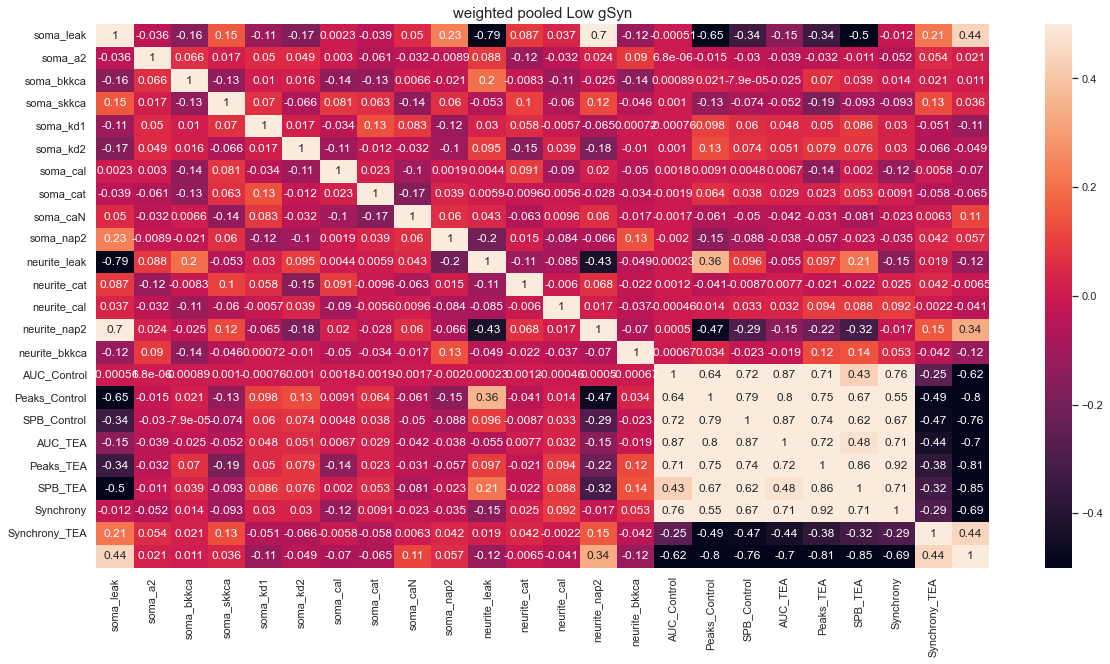

In [131]:
TestpassParams = passingParams
TestparamsList = fullParamsList()+LV3CritList()
plotCorrelogram(TestpassParams,TestparamsList,'weighted pooled Low gSyn')
print("from %d Passing Networks" %(int(TestpassParams.shape[1]/80)))
print("0.06 uS")
plt.show()

In [ ]:
LV3ParamsLow =  np.array(pd.read_pickle(os.path.join(archivedPathLow,"LV3","passParamsRepeat.pkl")))
LV3ParamsLowLarge = np.array(pd.read_pickle(os.path.join(archivedPathLowLarge,"LV3","passParamsRepeat.pkl")))

LV3codedLow = np.loadtxt(os.path.join(archivedPathLow,"LV3","LV3RejectionResults.txt"))
LV3codedLowLarge = np.loadtxt(os.path.join(archivedPathLowLarge,"LV3","LV3RejectionResults.txt"))

LV3RawLow = np.loadtxt(os.path.join(archivedPathLow,"LV3","LV3RejectionRaw.txt"))
LV3RawLowLarge = np.loadtxt(os.path.join(archivedPathLowLarge,"LV3","LV3RejectionRaw.txt"))

LV3passIdxsLow,LV3failIdxsLow,LV3allIdxsLow = getPassIdxs(LV3codedLow,'LV3')
LV3passIdxsLowLarge,LV3failIdxsLowLarge,LV3allIdxsLowLarge = getPassIdxs(LV3codedLowLarge,'LV3')

paramsLV3PassingLow = LV3ParamsLow[:,LV3passIdxsLow]
paramsLV3PassingLowLarge = LV3ParamsLowLarge[:,LV3passIdxsLowLarge]

totalParamsLV3PassingLow = np.vstack((paramsLV3PassingLow,LV3RawLow[:,LV3passIdxsLow]))
totalParamsLV3PassingLowLarge = np.vstack((paramsLV3PassingLowLarge,LV3RawLowLarge[:,LV3passIdxsLowLarge]))

SCfreqsLow = np.loadtxt(os.path.join(archivedPathLow,"LV3",'SCfreqs'))
SCfreqsLowLarge = np.loadtxt(os.path.join(archivedPathLowLarge,"LV3",'SCfreqs'))

SCfreqsLowPassing = SCfreqsLow[LV3passIdxsLow]
SCfreqsLowPassingLarge = SCfreqsLowLarge[LV3passIdxsLowLarge]

using LV3


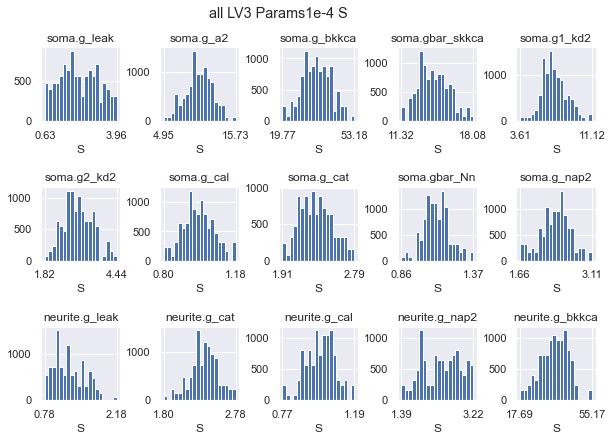

In [129]:
archivedPath1 = os.path.join("..","CGResults","fixed_gSyn","MedwithLV2","AVG")
LV3Params = np.array(pd.read_pickle(os.path.join(archivedPath1,"LV3","passParamsRepeat.pkl")))
LV3Raw= np.loadtxt(os.path.join(archivedPath1,"LV3","LV3RejectionRaw.txt"))
LV3coded = np.loadtxt(os.path.join(archivedPath1,"LV3","LV3RejectionResults.txt"))
SCfreqs = np.loadtxt(os.path.join(archivedPath1,"LV3",'SCfreqs'))

LV3passIdxs,LV3failIdxs,LV3allIdxs = getPassIdxs(LV3coded,'LV3')
paramsAll = np.concatenate((LV3Params,SCfreqs.reshape(1,-1),LV3Raw),axis=0)
passingParams = paramsAll[:,LV3passIdxs]


paramsList = list(rangeVarNames().keys())
plotDistributions(passingParams,paramsList,20,xlabels='S',title = 'all LV3 Params')

In [130]:
def getRes(paramsPassing):
    var = paramsPassing
    TestpassParams = var
    TestparamsList = fullParamsList()
    CorrRange = [0.06,0.999]
    
    def Report(df,Key):# so we can easily get soma or neurite
        r1 = [True if Key in CorrsDF.loc['conductance1'][i] else False for i in range(len(CorrsDF.loc['conductance1']))]
        r2 = [True if Key in CorrsDF.loc['conductance2'][i] else False for i in range(len(CorrsDF.loc['conductance2']))]
        query = np.logical_and(r1,r2)
        return pd.DataFrame([CorrsDF.loc['conductance1'][query],CorrsDF.loc['conductance2'][query],CorrsDF.loc['Pearsons_R'][query]])
# gets a data frame of all the values on the left lower diagonal which are in the CorrRange of interest 

    TestpassParamsCorr = np.corrcoef(TestpassParams)
    rList,cList,corrVals = [],[],[]
    for i in range(len(TestparamsList)):
        for j in range(len(TestparamsList)):
            if i >= j:#then we are in the right side of the correlogram
                pass
            elif CorrRange[0] < np.abs(TestpassParamsCorr[i][j]) < CorrRange[1]:
                rList.append(TestparamsList[i])
                cList.append(TestparamsList[j])
                corrVals.append(TestpassParamsCorr[i][j])

    CorrsDF = pd.DataFrame(data = [rList,cList,corrVals]).dropna(axis=1)
    CorrsDF.index = ["conductance1","conductance2","Pearsons_R"]

    somaCorrs = Report(CorrsDF,'soma')
    neuriteCorrs = Report(CorrsDF,'neurite')
    somaList = list(somaCorrs.columns)# the column keys so we can drop them to find soma x neurite combos
    neuriteList = list(neuriteCorrs.columns)
    somaXneuriteList =  list(CorrsDF.drop(somaList + neuriteList,axis=1).columns)

    sortedDF = CorrsDF[somaList + neuriteList + somaXneuriteList]
    sortedDFList =  ["soma"]  * sortedDF[somaList].shape[1] +  ["neurite"]  * sortedDF[neuriteList].shape[1] + ["somaXneurite"] * sortedDF[somaXneuriteList].shape[1]

    sortedDF.columns = sortedDFList
    return sortedDF.T

In [132]:
getRes(passingParams)

conductance1   conductance2 Pearsons_R
soma             soma_leak     soma_bkkca  -0.155672
soma             soma_leak     soma_skkca    0.14899
soma             soma_leak       soma_kd1  -0.113195
soma             soma_leak       soma_kd2  -0.171816
soma             soma_leak      soma_nap2   0.233021
soma               soma_a2     soma_bkkca   0.065644
soma               soma_a2       soma_cat  -0.061394
soma            soma_bkkca     soma_skkca  -0.128434
soma            soma_bkkca       soma_cal  -0.135385
soma            soma_bkkca       soma_cat   -0.12973
soma            soma_skkca       soma_kd1   0.069609
soma            soma_skkca       soma_kd2  -0.065555
soma            soma_skkca       soma_cal   0.080694
soma            soma_skkca       soma_cat   0.062896
soma            soma_skkca       soma_caN  -0.135731
soma            soma_skkca      soma_nap2   0.060219
soma              soma_kd1       soma_cat   0.133113
soma              soma_kd1       soma_caN   0.083396
soma              soma_kd1      soma_nap2  -0.117184
soma              soma_kd2       soma_cal  -0.109283
soma              soma_kd2      soma_nap2  -0.101353
soma              soma_cal       soma_caN  -0.099727
soma              soma_cat       soma_caN  -0.169107
soma              soma_caN      soma_nap2   0.060068
neurite       neurite_leak    neurite_cat  -0.110484
neurite       neurite_leak    neurite_cal  -0.085294
neurite       neurite_leak   neurite_nap2  -0.429509
neurite        neurite_cat   neurite_nap2   0.067969
neurite       neurite_nap2  neurite_bkkca  -0.069672
somaXneurite     soma_leak   neurite_leak  -0.790746
somaXneurite     soma_leak    neurite_cat   0.087416
somaXneurite     soma_leak   neurite_nap2     0.6995
somaXneurite     soma_leak  neurite_bkkca   -0.11573
somaXneurite       soma_a2   neurite_leak   0.088038
somaXneurite       soma_a2    neurite_cat  -0.116734
somaXneurite       soma_a2  neurite_bkkca   0.089808
somaXneurite    soma_bkkca   neurite_leak   0.196501
somaXneurite    soma_bkkca    neurite_cal  -0.109958
somaXneurite    soma_bkkca  neurite_bkkca  -0.141571
somaXneurite    soma_skkca    neurite_cat   0.104956
somaXneurite    soma_skkca   neurite_nap2   0.118358
somaXneurite      soma_kd1   neurite_nap2  -0.064768
somaXneurite      soma_kd2   neurite_leak   0.095122
somaXneurite      soma_kd2    neurite_cat   -0.15455
somaXneurite      soma_kd2   neurite_nap2  -0.180744
somaXneurite      soma_cal    neurite_cat   0.090531
somaXneurite      soma_cal    neurite_cal  -0.090066
somaXneurite      soma_caN    neurite_cat  -0.062561
somaXneurite      soma_caN   neurite_nap2   0.060275
somaXneurite     soma_nap2   neurite_leak  -0.199581
somaXneurite     soma_nap2    neurite_cal  -0.083781
somaXneurite     soma_nap2   neurite_nap2  -0.066358
somaXneurite     soma_nap2  neurite_bkkca   0.133891

In [249]:
LV3SIZControl = np.array(pd.read_pickle(os.path.join(archivedPath,"LV3","output","VSIZControl.pkl")))

In [250]:
idx = getNetIDX(19,16)
idx

1440

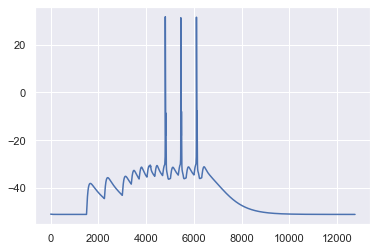

In [251]:
plt.plot(LV3SIZControl[idx,:])
plt.show()

In [252]:
max(LV3SIZControl[idx,:])

31.747833

# Figures

In [2]:
archivedPath = os.path.join("..","CGResults","fixed_gSyn","MedwithLV2")
archivedPathLVL3 = os.path.join("LV3","output")
archivedPathAVG = os.path.join("..","CGResults","fixed_gSyn","MedwithLV2","AVG")
archivedPathAVGLVL = os.path.join("LV3")

### write to h5 if need to use chunking

In [ ]:
LV3SomaControl = np.array(pd.read_pickle(os.path.join(archivedPath,"LV2","VSIZControl.pkl")))
hf = h5py.File('VSIZControl.h5', 'w')
hf.create_dataset('default', data=LV3SomaControl)
hf.close()

In [88]:
def readDat(f,endIDX):
    
    firstdatasetName = list(f.keys())[0]
    number_of_rows = f[firstdatasetName].shape[0]

    myiter = f['default'].__iter__()# __iter__ is a method of the dataset subclass that returns an iterator. when called () this is actually a generator,which moves by next()

    savedDat = []
    #now read in only the data between rows 30 and 40
    for i in range(0,number_of_rows):
        newDat = next(myiter)
        if  i <= endIDX:
            savedDat.append(newDat)
        else:
            pass
    f.close()
    return np.array(savedDat)

## 1C

In [94]:
cellNo,freqNo = 83,17
startNo = getLV2CellIDX(cellNo,freqNo)

In [97]:
f = h5py.File(os.path.join(archivedPath,"LV2","VsomaControl.h5"), 'r')
LV2SomaControl = readDat(f,startNo)
f = h5py.File(os.path.join(archivedPath,"LV2","VsomaTEA.h5"), 'r')
LV2SomaTEA = readDat(f,startNo)

In [245]:
pathname = r'C:\Users\ddopp\Everything_Grad\CGProject\CG ms\FIGURES - Final\FiguresRedone\Figure1C\Figure1C1.txt'
bioControl = np.loadtxt(pathname,dtype=float,delimiter=',')
pathname = r'C:\Users\ddopp\Everything_Grad\CGProject\CG ms\FIGURES - Final\FiguresRedone\Figure1C\Figure1C2.txt'
bioTEA = np.loadtxt(pathname,dtype=float,delimiter=',')
pathname = r'C:\Users\ddopp\Everything_Grad\CGProject\CG ms\FIGURES - Final\FiguresRedone\Figure1C\BioTime.txt'


In [180]:
Time = np.loadtxt(pathname,dtype=float,delimiter=',')
modelTime = getSimTime(LV2SomaControl[startNo,:].T,0.2)/1000
modelControl = LV2SomaControl[startNo,:].T
modelTEA = LV2SomaTEA[startNo,:].T

In [199]:
modelStart,modelEnd = 0,int(2000/0.2)
bioStart,bioEnd = 0,int(20000)

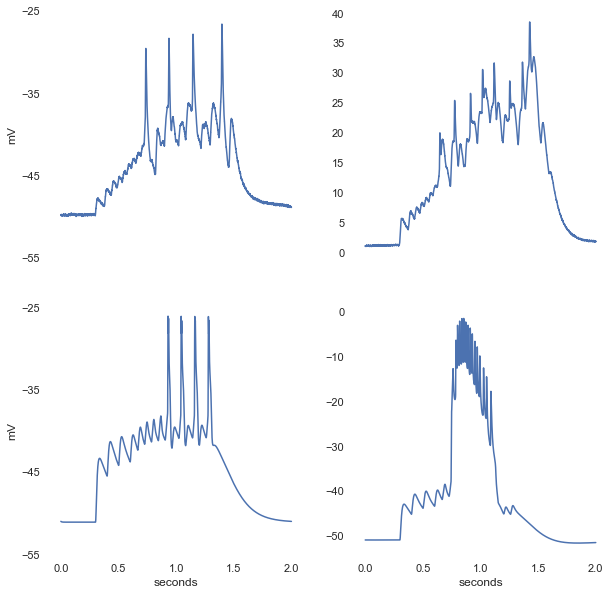

In [244]:
fig,axs = plt.subplots(2,2,sharex=True,figsize=(10,10))
axs[0][0].plot(Time[bioStart:bioEnd],bioControl[bioStart:bioEnd])
axs[0][0].set_ylim([-55,-25])
axs[0][0].set_yticks(np.arange(-55,-20,10))
axs[0][0].grid(False)
axs[0][0].set_facecolor("White")
axs[0][0].set_ylabel('mV')

axs[0][1].plot(Time[bioStart:bioEnd],bioTEA[bioStart:bioEnd])
axs[0][1].grid(False)
axs[0][1].set_facecolor("White")


axs[1][0].plot(modelTime[modelStart:modelEnd],modelControl[modelStart:modelEnd])
axs[1][0].set_ylim([-55,-25])
axs[1][0].set_yticks(np.arange(-55,-20,10))
axs[1][0].grid(False)
axs[1][0].set_facecolor("White")
axs[1][0].set_xlabel('seconds')
axs[1][0].set_ylabel('mV')

axs[1][1].plot(modelTime[modelStart:modelEnd],modelTEA[modelStart:modelEnd])
axs[1][1].grid(False)
axs[1][1].set_facecolor("White")
axs[1][1].set_xlabel('seconds')
plt.savefig('fig1C.png',dpi=500)
plt.show()

# S3

In [319]:
#pathname = os.path.join(archivedPathAVG,archivedPathAVGLVL)
pathname = os.path.join(archivedPath,archivedPathLVL3)
LV3Params =  np.array(pd.read_pickle(os.path.join(pathname,"passParamsRepeat.pkl")))
LV3coded= np.loadtxt(os.path.join(pathname,"LV3RejectionResults.txt"))
LV3Raw = np.loadtxt(os.path.join(pathname,"LV3RejectionRaw.txt"))
SCfreqs = np.loadtxt(os.path.join(pathname,'SCfreqs'))

LV3passIdxs,LV3failIdxs,LV3allIdxs = getPassIdxs(LV3coded,'LV3')

paramsLV3Passing = LV3Params[:,LV3passIdxs]
SCfreqsPassing = SCfreqs[LV3passIdxs]
LV3RawPassing = LV3Raw[:,LV3passIdxs]



using LV3


In [308]:
LV3totalParams = np.concatenate((paramsLV3Passing,SCfreqsPassing.reshape(1,-1),LV3RawPassing),axis=0)

from 129 Passing Networks


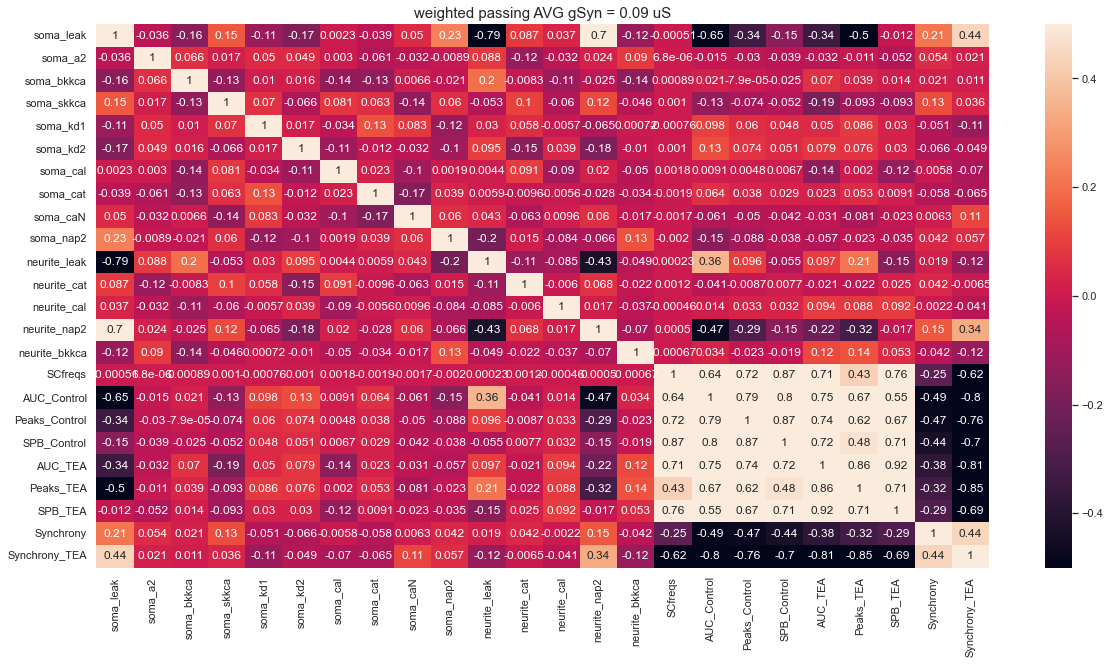

In [310]:
TestpassParams = LV3totalParams
TestparamsList = fullParamsList()+["SCfreqs"] +LV3CritList()
plotCorrelogram(TestpassParams,TestparamsList,'weighted passing AVG gSyn = 0.09 uS')
print("from %d Passing Networks" %(int(TestpassParams.shape[1]/80)))
plt.savefig('S3 weighted passing AVG.png',dpi=500)
plt.show()

# S10

In [367]:
pathname = os.path.join(archivedPath,archivedPathLVL3)
pathnameAVG = os.path.join(archivedPathAVG,archivedPathAVGLVL)


LV3Params =  np.array(pd.read_pickle(os.path.join(pathname,"passParamsRepeat.pkl")))
LV3coded= np.loadtxt(os.path.join(pathname,"LV3RejectionResults.txt"))
LV3Raw = np.loadtxt(os.path.join(pathname,"LV3RejectionRaw.txt"))
SCfreqs = np.loadtxt(os.path.join(pathname,'SCfreqs'))

LV3passIdxs,LV3failIdxs,LV3allIdxs = getPassIdxs(LV3coded,'LV3')

paramsLV3Passing = LV3Params[:,LV3passIdxs]
SCfreqsPassing = SCfreqs[LV3passIdxs]
LV3RawPassing = LV3Raw[:,LV3passIdxs]
LV3totalParams = np.concatenate((paramsLV3Passing,SCfreqsPassing.reshape(1,-1),LV3RawPassing),axis=0)

LV3ParamsAVG =  np.array(pd.read_pickle(os.path.join(pathnameAVG,"passParamsRepeat.pkl")))
LV3codedAVG= np.loadtxt(os.path.join(pathnameAVG,"LV3RejectionResults.txt"))
LV3RawAVG = np.loadtxt(os.path.join(pathnameAVG,"LV3RejectionRaw.txt"))
SCfreqsAVG = np.loadtxt(os.path.join(pathnameAVG,'SCfreqs'))

LV3passIdxsAVG,LV3failIdxsAVG,LV3allIdxsAVG = getPassIdxs(LV3codedAVG,'LV3')

paramsLV3PassingAVG = LV3ParamsAVG[:,LV3passIdxsAVG]
SCfreqsPassingAVG = SCfreqsAVG[LV3passIdxsAVG]
LV3RawPassingAVG = LV3RawAVG[:,LV3passIdxsAVG]
LV3totalParamsAVG = np.concatenate((paramsLV3PassingAVG,SCfreqsPassingAVG.reshape(1,-1),LV3RawPassingAVG),axis=0)

using LV3
using LV3


In [370]:
params = np.corrcoef(LV3totalParams)
paramsAVG = np.corrcoef(LV3totalParamsAVG)
diff =   np.subtract(np.abs(params),np.abs(paramsAVG))

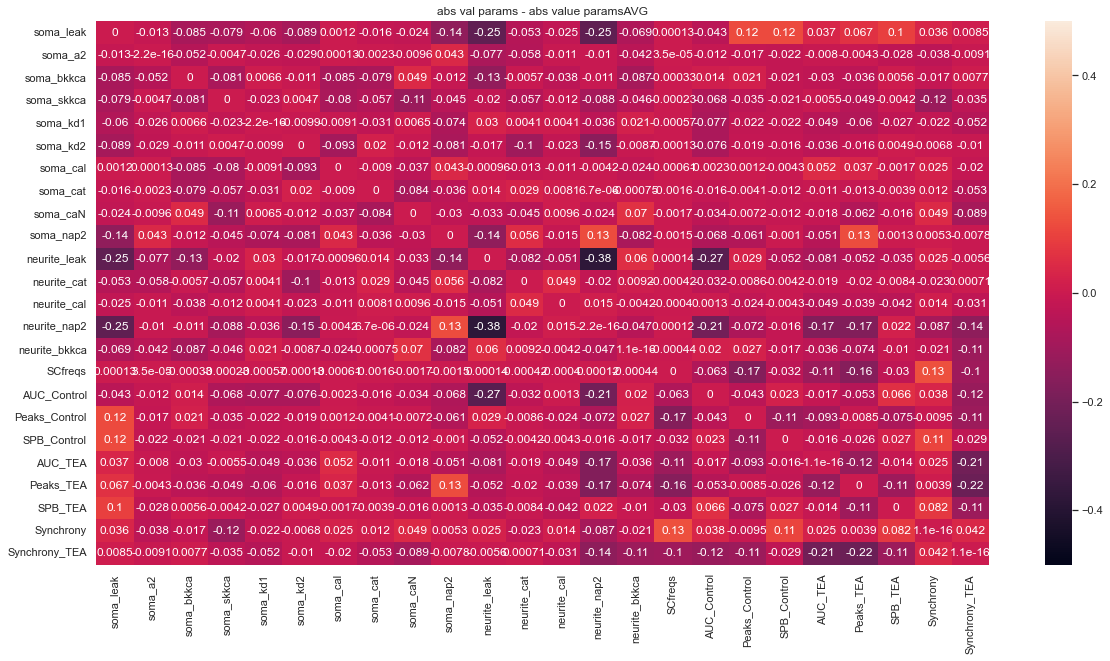

In [371]:
paramsList = fullParamsList()+["SCfreqs"] +LV3CritList()
plt.figure(figsize=(20,10))
plt.title('abs val params - abs value paramsAVG')

sns.heatmap(diff,xticklabels=paramsList,yticklabels = paramsList,vmin=-0.5,vmax=0.5,annot=True)
plt.savefig('abs val params - abs value paramsAVG.png',dpi=500)
plt.show()

# S11

In [7]:
#LV3coded= np.loadtxt(os.path.join(pathname,"LV3RejectionResults.txt"))
LV3coded= np.loadtxt(r'C:\Users\ddopp\Desktop\LV3RejectionResults.txt')

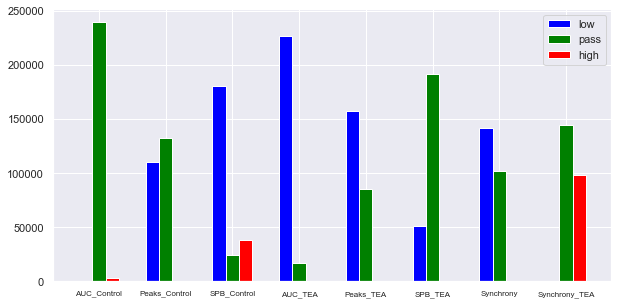

In [8]:
plotFailCrit(LV3coded,LV3CritList())
#plt.savefig('S10 cell counts which failed.png',dpi=500)
plt.show()

# S4

using LV3


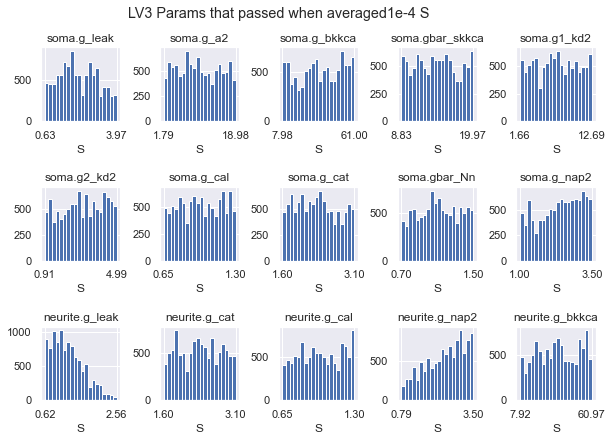

In [3]:
pathname =os.path.join(archivedPath,archivedPathLVL3)
#pathname =os.path.join(archivedPathAVG,archivedPathAVGLVL)
LV3Params = np.array(pd.read_pickle(os.path.join(pathname,"passParamsRepeat.pkl")))
LV3Raw= np.loadtxt(os.path.join(pathname,"LV3RejectionRaw.txt"))
LV3coded = np.loadtxt(os.path.join(pathname,"LV3RejectionResults.txt"))
SCfreqs = np.loadtxt(os.path.join(pathname,'SCfreqs'))

LV3passIdxs,LV3failIdxs,LV3allIdxs = getPassIdxs(LV3coded,'LV3')
paramsAll = np.concatenate((LV3Params,SCfreqs.reshape(1,-1),LV3Raw),axis=0)
passingParams = paramsAll[:,LV3passIdxs]


paramsList = list(rangeVarNames().keys())
plotDistributions(passingParams,paramsList,20,xlabels='S',title = 'LV3 Params that passed when averaged')
plt.savefig('LV3 Passing Parameters',dpi=500)

In [5]:
t1 = passingParams
t2 = paramsAll[:,LV3failIdxs]

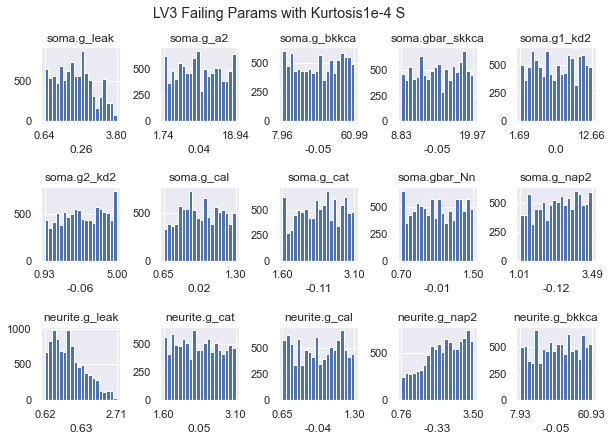

In [18]:
#t1 is the networks that passed
#t2 is the networks that failed
from scipy.stats import skew
t1Kurts = [kurtosis(t1[i,:],bias=False) for i in range((t1.shape)[0])]
t1Kurts = np.round(t1Kurts,2)
t1Skews = [skew(t1[i,:]) for i in range((t1.shape)[0])]
t1Skews = np.round(t1Skews,2)

t2Kurts = [kurtosis(t2[i,:],bias=False) for i in range((t2.shape)[0])]
t2Kurts = np.round(t2Kurts,2)
t2Skews = [skew(t2[i,:]) for i in range((t2.shape)[0])]
t2Skews = np.round(t2Skews,2)
plotDistributions(t2,paramsList,20,title = 'LV3 Failing Params with Kurtosis',xlabels=list(t2Skews))
plt.savefig('LV3 Failing Params with Kurtosis.png',dpi=500)

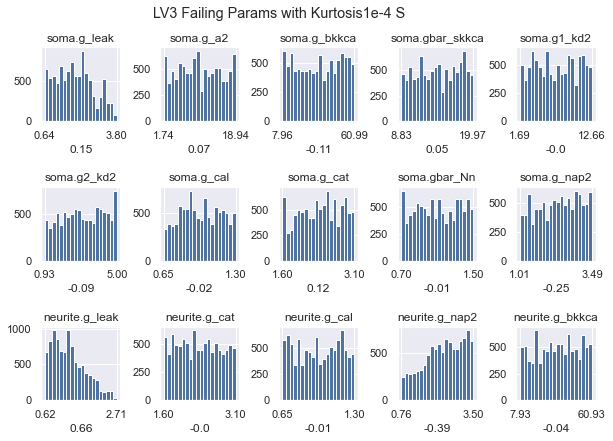

In [19]:
#t2 is the networks that failed
from scipy.stats import skew
t1Kurts = [kurtosis(t1[i,:],bias=False) for i in range((t1.shape)[0])]
t1Kurts = np.round(t1Kurts,2)
t1Skews = [skew(t1[i,:]) for i in range((t1.shape)[0])]
t1Skews = np.round(t1Skews,2)

t2Kurts = [kurtosis(t2[i,:],bias=False) for i in range((t2.shape)[0])]
t2Kurts = np.round(t2Kurts,2)
t2Skews = [skew(t2[i,:]) for i in range((t2.shape)[0])]
t2Skews = np.round(t2Skews,2)
plotDistributions(t2,paramsList,20,title = 'LV3 Failing Params with Kurtosis',xlabels=list(t1Skews))
plt.savefig('LV3 Failing Params with Kurtosis.png',dpi=500)

In [11]:
AvgFailKurt = np.mean(t2Kurts)
AvgPassKurt = np.mean(t1Kurts)
AvgFailSkew = np.mean(t2Skews)
AvgPassSkew = np.mean(t1Skews)
print('Failing:\nAvg Kurt = {0:>15.4}\nAvg Skew = {1:>15.4}\n\nPassing:\nAvg Kurt = {2:>15.4}\nAvg Skew = {3:>17.4}'.format(AvgFailKurt,AvgFailSkew,AvgPassKurt,AvgPassSkew))

Failing:
Avg Kurt =          -0.595
Avg Skew =        -0.06625

Passing:
Avg Kurt =         -0.2754
Avg Skew =           -0.1567


In [12]:
DistMetricFail = abs(t2Kurts) + abs(t2Skews)
DistMetricPass = abs(t1Kurts) + abs(t1Skews)

In [13]:
print('skew/kurt measurement for failing = %.6f\nskew/kurt measurement for passing = %.6f' %(np.mean(DistMetricFail),np.mean(DistMetricPass)))
stats.ttest_ind(DistMetricFail, DistMetricPass, equal_var=False)

skew/kurt measurement for failing = 1.276250
skew/kurt measurement for passing = 1.557917


Ttest_indResult(statistic=-0.9693519232353808, pvalue=0.3405208618910277)

# Figure 5A

In [12]:
netNo,freqNo = 1,19
startNo = getNetIDX(netNo,freqNo)


In [21]:
archivedPath = os.path.join("..","CGResults","fixed_GSyn","MedwithLV2")
archivedPathLVL3 = os.path.join("output","LV3")

##### get the parameter set of 5, and use it to run in CGProject level 3 only

In [14]:
LV3Params = np.array(pd.read_pickle(os.path.join(archivedPath,archivedPathLVL3,"passParamsRepeat.pkl")))

In [15]:
LV3ParamsSelected = LV3Params[:,startNo:startNo+5]
LV3ParamsSelectedDF = pd.DataFrame(LV3ParamsSelected)

In [35]:
LV3ParamsSelectedDF.to_pickle(os.path.join("output","LV2","passParamsRepeatControl.pkl"))

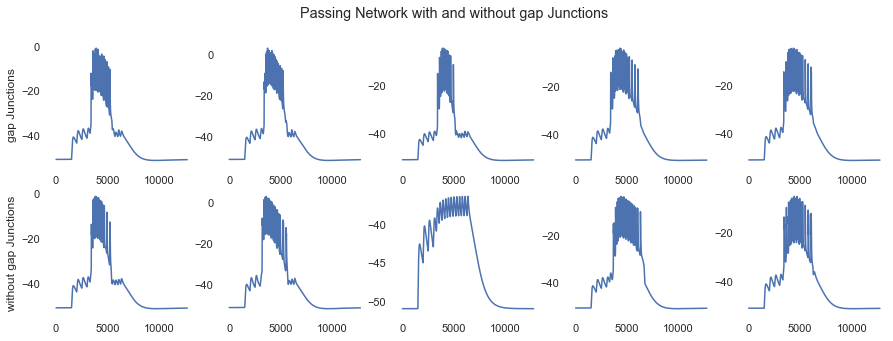

In [55]:
array = np.array(pd.read_pickle(os.path.join("output","LV3","vNeuriteTEA.pkl"))).T
arrayNoNet = np.array(pd.read_pickle(os.path.join("output","LV3","vNeuriteTEANOGAP.pkl"))).T
fig,axs = plt.subplots(2,5,figsize=(15,5))


[axs[0][i].plot(array[:,startNo+i]) for i in range(5)]
[axs[0][i].grid(False) for i in range(5)]
[axs[0][i].set_facecolor("White") for i in range(5)]
axs[0][0].set_ylabel('gap Junctions')

[axs[1][i].plot(arrayNoNet[:,startNo+i]) for i in range(5)]
[axs[1][i].grid(False) for i in range(5)]
[axs[1][i].set_facecolor("White") for i in range(5)]
axs[1][0].set_ylabel('without gap Junctions')

plt.suptitle('Passing Network with and without gap Junctions')
#plt.savefig('figure 5 in and out of network.png',dpi=500)
plt.show()

# convert to txt

In [56]:
array = np.array(pd.read_pickle(os.path.join("output","LV3","VsomaTEA.pkl"))).T
arrayNoNet = np.array(pd.read_pickle(os.path.join("output","LV3","VsomaTEANOGAP.pkl"))).T
np.savetxt('VsomaTEA.txt',array)
np.savetxt('VsomaTEANOGAP.txt',arrayNoNet)
array = np.array(pd.read_pickle(os.path.join("output","LV3","VNeuriteTEA.pkl"))).T
arrayNoNet = np.array(pd.read_pickle(os.path.join("output","LV3","VNeuriteTEANOGAP.pkl"))).T
np.savetxt('VNeuriteTEA.txt',array)
np.savetxt('VNeuriteTEANOGAP.txt',arrayNoNet)
array = np.array(pd.read_pickle(os.path.join("output","LV3","VSIZTEA.pkl"))).T
arrayNoNet = np.array(pd.read_pickle(os.path.join("output","LV3","VSIZTEANOGAP.pkl"))).T
np.savetxt('VSIZTEA.txt',array)
np.savetxt('VSIZTEANOGAP.txt',arrayNoNet)

#### now analyze it:

In [74]:
array = np.array(pd.read_pickle(os.path.join("output","LV3","VsomaControl.pkl"))).T

In [77]:
arrayNoNet = np.array(pd.read_pickle(os.path.join("output","LV3","VsomaControl.pkl"))).T

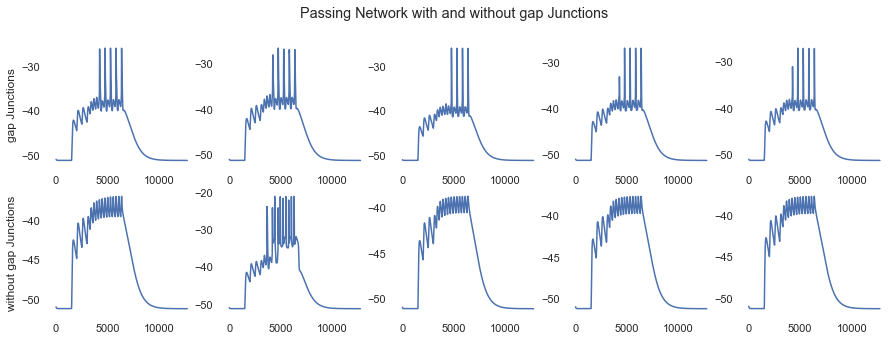

In [97]:
fig,axs = plt.subplots(2,5,figsize=(15,5))


[axs[0][i].plot(array[:,startNo+i]) for i in range(5)]
[axs[0][i].grid(False) for i in range(5)]
[axs[0][i].set_facecolor("White") for i in range(5)]
axs[0][0].set_ylabel('gap Junctions')

[axs[1][i].plot(arrayNoNet[:,startNo+i]) for i in range(5)]
[axs[1][i].grid(False) for i in range(5)]
[axs[1][i].set_facecolor("White") for i in range(5)]
axs[1][0].set_ylabel('without gap Junctions')

plt.suptitle('Passing Network with and without gap Junctions')
plt.savefig('figure 5 in and out of network.png',dpi=500)
plt.show()

# run the simulation for fig 5

In [33]:
ETs = passingEventTimes
ETs[ETs !=0]

array([300.0, 300.0, 300.0, 300.0, 300.0, 400.0, 400.0, 400.0, 400.0,
       400.0, 500.0, 500.0, 500.0, 500.0, 500.0, 600.0, 600.0, 600.0,
       600.0, 600.0, 660.0, 660.0, 660.0, 660.0, 660.0, 714.0, 714.0,
       714.0, 714.0, 714.0, 768.0, 768.0, 768.0, 768.0, 768.0, 822.0,
       822.0, 822.0, 822.0, 822.0, 876.0, 876.0, 876.0, 876.0, 876.0,
       930.0, 930.0, 930.0, 930.0, 930.0, 984.0, 984.0, 984.0, 984.0,
       984.0, 1038.0, 1038.0, 1038.0, 1038.0, 1038.0, 1092.0, 1092.0,
       1092.0, 1092.0, 1092.0, 1146.0, 1146.0, 1146.0, 1146.0, 1146.0,
       1200.0, 1200.0, 1200.0, 1200.0, 1200.0, 1254.0, 1254.0, 1254.0,
       1254.0, 1254.0], dtype=object)

In [ ]:
TEA = False


cellID =getLV2CellIDX(1,19)
print(cellID)
archivedPath = os.path.join("..","CGResults","fixed_GSyn","MedwithLV2")
archivedPathLVL3 = os.path.join("output","LV3")
LV3Params = np.array(pd.read_pickle(os.path.join(archivedPath,archivedPathLVL3,"passParamsRepeat.pkl")))
LV3ParamsSelected = LV3Params[:,startNo:startNo+5]
eventTimes = np.array(pd.read_pickle(os.path.join(archivedPath,"input","LV3", "EventTimes.pkl"))).T
passingEventTimes = eventTimes[:,cellID:cellID+5]


params = LV3ParamsSelected
teaParamsList = [1,2,4,5,14]
if TEA == True:
    for parameter in teaParamsList:
        params[parameter] *= 0.03


ETs = passingEventTimes

cell = LargeCellLV2(0)

varNames = list(rangeVarNames().keys())[:len(params)]

#assign the param(:,i) to LC2(i)
for j in range(len(varNames)):
    exec("%s = %f" %("cell."+varNames[j],params[j]))

dt = 0.2
tstop = 2550#ms
maxstep = 10
vinit = -51#mV
seed  = 32165156


synGain = 0.09

vsAll = h.VecStim()
ETs = h.Vector(ETs[ETs !=0])

syns = h.Exp2Syn(cell.siz(1))

vsAll.play(ETs)
syns.tau1,syns.tau2,syns.e   = 10,120,-15

NetCons = [h.NetCon(vsAll,syns,-10,0,synGain)]

v = h.Vector().record(cell.soma(0.5)._ref_v)
vNeurite = h.Vector().record(cell.neurite(0.5)._ref_v)
vSIZ = h.Vector().record(cell.siz(0.5)._ref_v)

cell.siz.g_leak = 0.001
cell.siz.g_nasiz =  0.300 #
cell.siz.g_kdsiz =  0.074 # 


secName = ["soma","neurite","siz"]
recVars = [["nap2","Nn","cat","cal","kd2","skkca","bkkca","a2","leak"],["bkkca","nap2","cal","cat","leak"],["kdsiz","nasiz","leak"]]


allVs = []
allRefNames = []
allRecVects = []
for m in range(len(secName)):
    refVars = []
    
    for var in recVars[m]:
        res = eval("cell."+secName[m]+"(0.5)."+var+".__dict__")
        
        for key in list(res.keys()):
            
            if key[0] == 'i':
                refVars.append(key)
                

    refNames = [secName[m]+" "+recVars[m][j]+" "+refVars[j] for j in range(len(recVars[m]))]
    allRefNames.append(refNames)
    
    recVects = [eval("h.Vector().record(cell."+secName[m]+"(0.5)."+recVars[m][j]+"._ref_"+refVars[j]+")") for j in range(len(recVars[m]))]
    allVs.append(eval("h.Vector().record(cell."+secName[m]+"(0.5)._ref_v)"))
    allRecVects.append(recVects)

synrec = h.Vector().record(syns._ref_i)

h.dt=0.2
h.finitialize(-51)
h.continuerun(2550)

# Figure 5B

In [61]:
iSyn = np.array(pd.read_pickle(os.path.join("output","LV3","ISYNControl.pkl"))).T

In [62]:
netNo,freqNo = 1,19
startNo = getNetIDX(netNo,freqNo)

In [63]:
iSynSelected = iSyn[:,startNo]

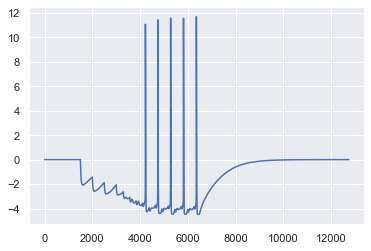

In [64]:
plt.plot(iSynSelected)

#### now get the SIZ current going into SIZ1

In [65]:
VSIZ = np.array(pd.read_pickle(os.path.join("output","LV3","VSIZControl.pkl"))).T
Vsoma = np.array(pd.read_pickle(os.path.join("output","LV3","VsomaControl.pkl"))).T
RSIZ = 200#x10^6
#10e-3 V / 10^6 Ohms = 10^-9 nA

In [66]:
VSIZ1 = VSIZ[:,startNo]
VSIZ2 = VSIZ[:,startNo+1]
VSIZ3 = VSIZ[:,startNo + 2]
VSIZ4 = VSIZ[:,startNo + 3]
VSIZ5 = VSIZ[:,startNo + 4]


In [67]:
SIZgap12 = (VSIZ1 - VSIZ2) / 200 # nA
SIZgap13 = (VSIZ1 - VSIZ3) / 200
SIZgap14 = (VSIZ1 - VSIZ4) / 200
SIZgap15 = (VSIZ1 - VSIZ5) / 200


In [68]:
SIZgapSum = SIZgap12 + SIZgap13 + SIZgap14 + SIZgap15

#### now get the current going into the LC1 soma

In [69]:
VLC1 = Vsoma[:,startNo]
VLC2 = Vsoma[:,startNo+1]
Somagap = (VLC1 - VLC2) / 1.54 #nA

In [70]:
time = np.arange(0,len(iSynSelected) * 0.2,0.2)


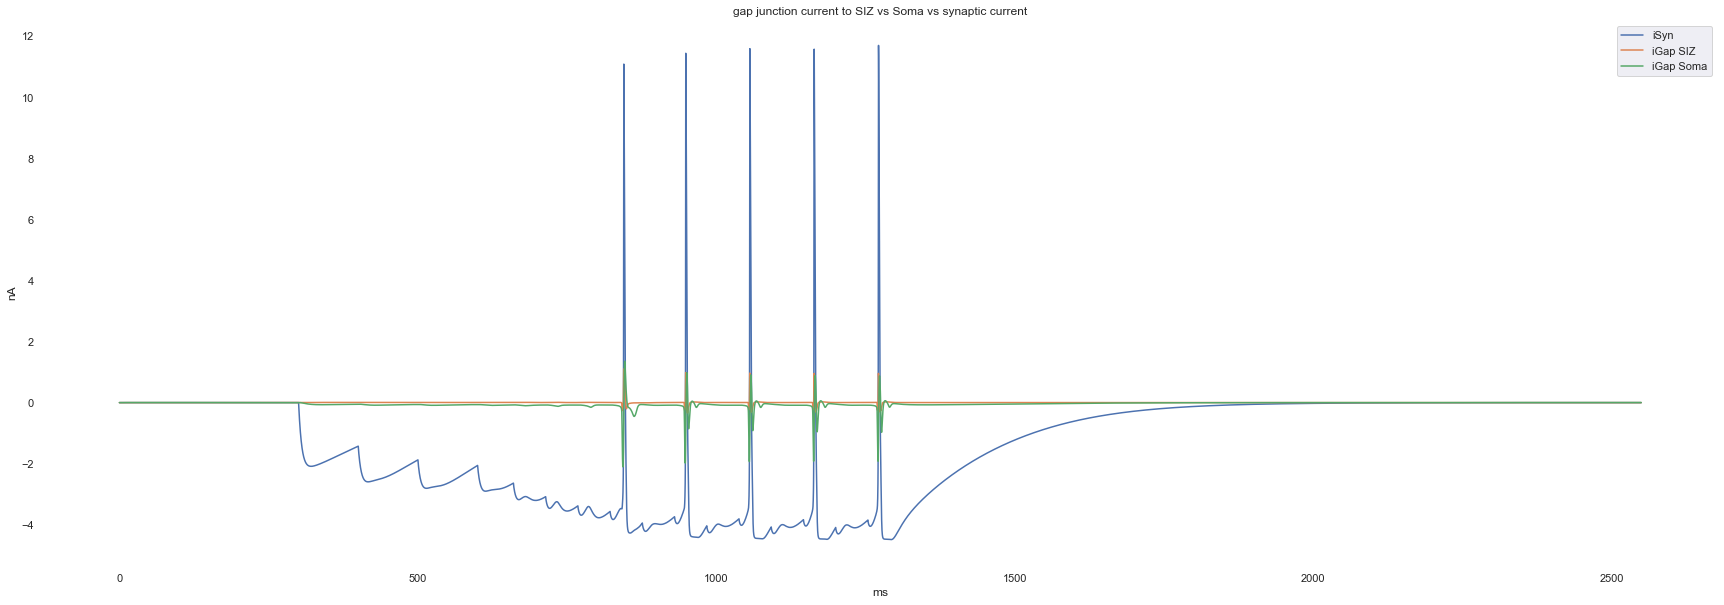

In [76]:
start,end = 0,20000
fig,axs = plt.subplots(1,1,figsize = (30,10))
axs.plot(time[start:end],iSynSelected[start:end],label = 'iSyn')
axs.plot(time[start:end],SIZgapSum[start:end],label = 'iGap SIZ')
axs.plot(time[start:end],Somagap[start:end],label = 'iGap Soma')
axs.set_xlabel('ms')
axs.set_ylabel('nA')
axs.set_title('gap junction current to SIZ vs Soma vs synaptic current')
axs.legend()
axs.grid(False)
axs.set_facecolor('white')
plt.savefig('Figure 5 current comparison zoom.png',dpi=500)
plt.show()

In [74]:
np.savetxt('iSyn.txt',iSynSelected)
np.savetxt('iGap SIZ.txt',SIZgapSum)
np.savetxt('iGap Soma.txt', Somagap)

# debugging

In [41]:
someArray  = np.array([3,4,56])
option = 'y'
if option == 'y':
    someArray = np.array([8,1])
someArray

array([8, 1])

In [11]:
#generate a list of folders
myList = [os.path.join("input","LV1"),
 os.path.join("input","LV2"),
 os.path.join("input","LV3"),
 os.path.join("input","LV3","Avg"),
 os.path.join("output","LV1"),
 os.path.join("output","LV2"),
 os.path.join("output","LV3"),
 os.path.join("output","LV3","Avg")
 ]

In [66]:
def makeAvgNets(LV3passParams):#LV3passParamsRepeat in the LV3 output folder is the file that has the parameters of the networks repeated 16 times each
    [a,b] = LV3passParams.shape

    avgNets = np.ones((a,1))

    for i in range(0,b,5*16):
        avgNets = np.hstack((avgNets,np.mean(LV3passParams[:,i:i+5],axis=1).reshape(-1,1)))
    avgNets = avgNets[:,1:]

    avgNets = np.repeat(avgNets,5,axis=1)

    return avgNets

In [71]:

for folder in folderList():
    #move to the folder, and check if it has folders

input
output


In [224]:
myFolders = np.array([["input","output"],
                      ["LV1","LV2","LV3"]
                      
                      ,
                      ["","","Avg"]
                     ],dtype=object)

myFolders

array([list(['input', 'output']), list(['LV1', 'LV2', 'LV3']),
       list(['', '', 'Avg'])], dtype=object)

In [176]:
treebranch = np.arange(0,(myFolders.shape)[0])
treebranch

array([0, 1, 2])

In [220]:
lvls = []

for j in range(len(myFolders[0])):
    for i in range(len(myFolders[1])):
        if myFolders[2][i] == "":
            path = os.path.join(myFolders[0][j],myFolders[1][i])
        else:
            path = os.path.join(myFolders[0][j],myFolders[1][i],myFolders[2][i])
        print(path)

input\LV1
input\LV2
input\LV3\Avg
output\LV1
output\LV2
output\LV3\Avg


In [227]:
def mkTrunk(myFolders):
    for folder in myFolders[0]:
        print(os.path.join(folder))#mkdir

In [319]:
def mkBranch(myFolders,trunk,branch):
    for i in range(len(myFolders[branch])):
        if myFolders[branch][i] == "":
            a=1
        else:
            print(os.path.join(trunk,myFolders[branch][i]))

In [225]:
mkTrunk(myFolders)

input
output


In [320]:
trunk = 1
branch=2
trunks = np.arange(0,(myFolders.shape)[0]-1)
branches = np.arange(0,(myFolders.shape)[0])

for i in range(len(myFolders[trunk])):
    mkBranch(myFolders,myFolders[trunk][i],branch)

LV1\Avg
LV2\Avg
LV3\Avg


In [270]:
branches = np.arange(0,(myFolders.shape)[0])
for branch in branches:
    
    

0
1
2


In [213]:
def mkLevel(myFolders,level):
    lvl = []
    for j in range(len(myFolders[level])):
        lvl.append(os.path.join(myFolders[level][j]))
    return lvl

In [214]:
lvl = []
for i in range(len(myFolders)):
    print(i)
    
    lvl.append(mkLevel(myFolders,i))

0
1
2


In [215]:
lvl

[['input', 'output', ''], ['LV1', 'LV2', 'LV3'], ['', '', 'Avg']]

In [325]:
avgN = makeAvgNets(getEveryFirstNet(LV3passParams))

In [78]:
VsomaControl = np.load(os.path.join(archivedPath,"output","LV2","VsomaControl.pkl.npy"),allow_pickle=True).T
VsomaTEA = np.load(os.path.join(archivedPath,"output","LV2","VsomaTEA.pkl.npy"),allow_pickle=True).T
LV2RejectionResults = np.loadtxt(os.path.join(archivedPath,"output","LV2","LV2RejectionResults.txt"))

In [20]:
Vsoma = np.array(pd.read_pickle(os.path.join(archivedPath,"output","LV1","Vsoma.pkl"))).T
LV1RejectionResults = np.loadtxt(os.path.join(archivedPath,"output","LV1","LV1RejectionResults.txt"))

In [30]:
passIdxs = np.where(np.array([1 if np.all(LV1RejectionResults[:,i] ==1) else 0 for i in range(LV1RejectionResults.shape[1])]))[0]
len(passIdxs)

5751

In [32]:
LV1PassVoltages = Vsoma[:,passIdxs]
Time = getSimTime(LV1PassVoltages[:,0],0.2)

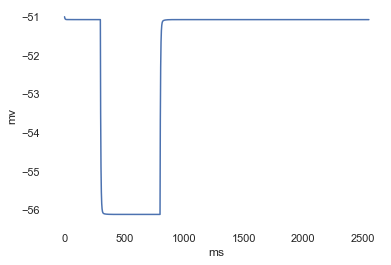

In [33]:
fig, axs = plt.subplots()
axs.set_facecolor("white")
plt.plot(Time,LV1PassVoltages[:,0])
plt.grid=False
plt.xlabel('ms')
plt.ylabel('mv')
plt.savefig('model LV2 TEA Passing.png',dpi=500)